In [5]:
import osmnx as ox
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, Normalize
import networkx as nx
import pandana
import keplergl
import IPython
import base64
from shapely import Point
import geopandas as gpd
from shapely.geometry import Polygon
import warnings
import folium
import mapclassify
from scipy.stats import kendalltau, pearsonr, spearmanr, linregress, stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro, kstest, norm
import json

In [6]:
# Notebook themes
#!jt -l

In [7]:
# Notebook themes
#!jt -t chesterish
#!jt -t onedork -fs 115 -nfs 125 -tfs 115 -dfs 115 -ofs 115 -cursc r -cellw 80% -lineh 115 -altmd  -kl -T -N
#!jt -t monokai -f fira -fs 10 -nf ptsans -nfs 11 -N -kl -cursw 2 -cursc r -cellw 95% -T

#### Importing the network

In [8]:
#place = 'Venice, Italy'
#G = ox.graph_from_place(place, network_type='walk', simplify = True)

# Define the bounding box coordinates (south, north, west, east)
bbox = (45.419281, 45.449945, 12.298992, 12.368158)
# Create a graph from the bounding box using the bbox parameter
G = ox.graph_from_bbox(north=bbox[1], south=bbox[0], east=bbox[3], west=bbox[2], network_type='walk', simplify=True)

C:\Users\mario\AppData\Local\Temp\ipykernel_11188\1317270295.py:7: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(north=bbox[1], south=bbox[0], east=bbox[3], west=bbox[2], network_type='walk', simplify=True)


In [9]:
# Get the geometry of the city polygon
city_total_polygon = ox.geocode_to_gdf("Venezia")['geometry'].iloc[0]

# Create a polygon from the bounding box
min_lat, max_lat, min_lon, max_lon = bbox
sub_polygon_coords = [
    (min_lon, min_lat),
    (min_lon, max_lat),
    (max_lon, max_lat),
    (max_lon, min_lat),
    (min_lon, min_lat)
]
sub_polygon = Polygon(sub_polygon_coords)

# Ensure the sub-polygon is within the city polygon
if sub_polygon.within(city_total_polygon):
    print("Sub-polygon is within the city polygon.")
else:
    print("Sub-polygon is not within the city polygon.")

# Create GeoDataFrames for plotting
city_gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[city_total_polygon])
sub_gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[sub_polygon])
city_polygon = sub_gdf['geometry'].iloc[0]

Sub-polygon is within the city polygon.


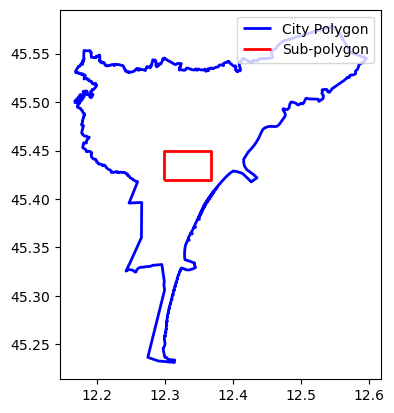

In [10]:
# Plot the city polygon and the sub-polygon
fig, ax = plt.subplots()
city_gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, label='City Polygon')
sub_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2, label='Sub-polygon')
plt.legend()
plt.show()

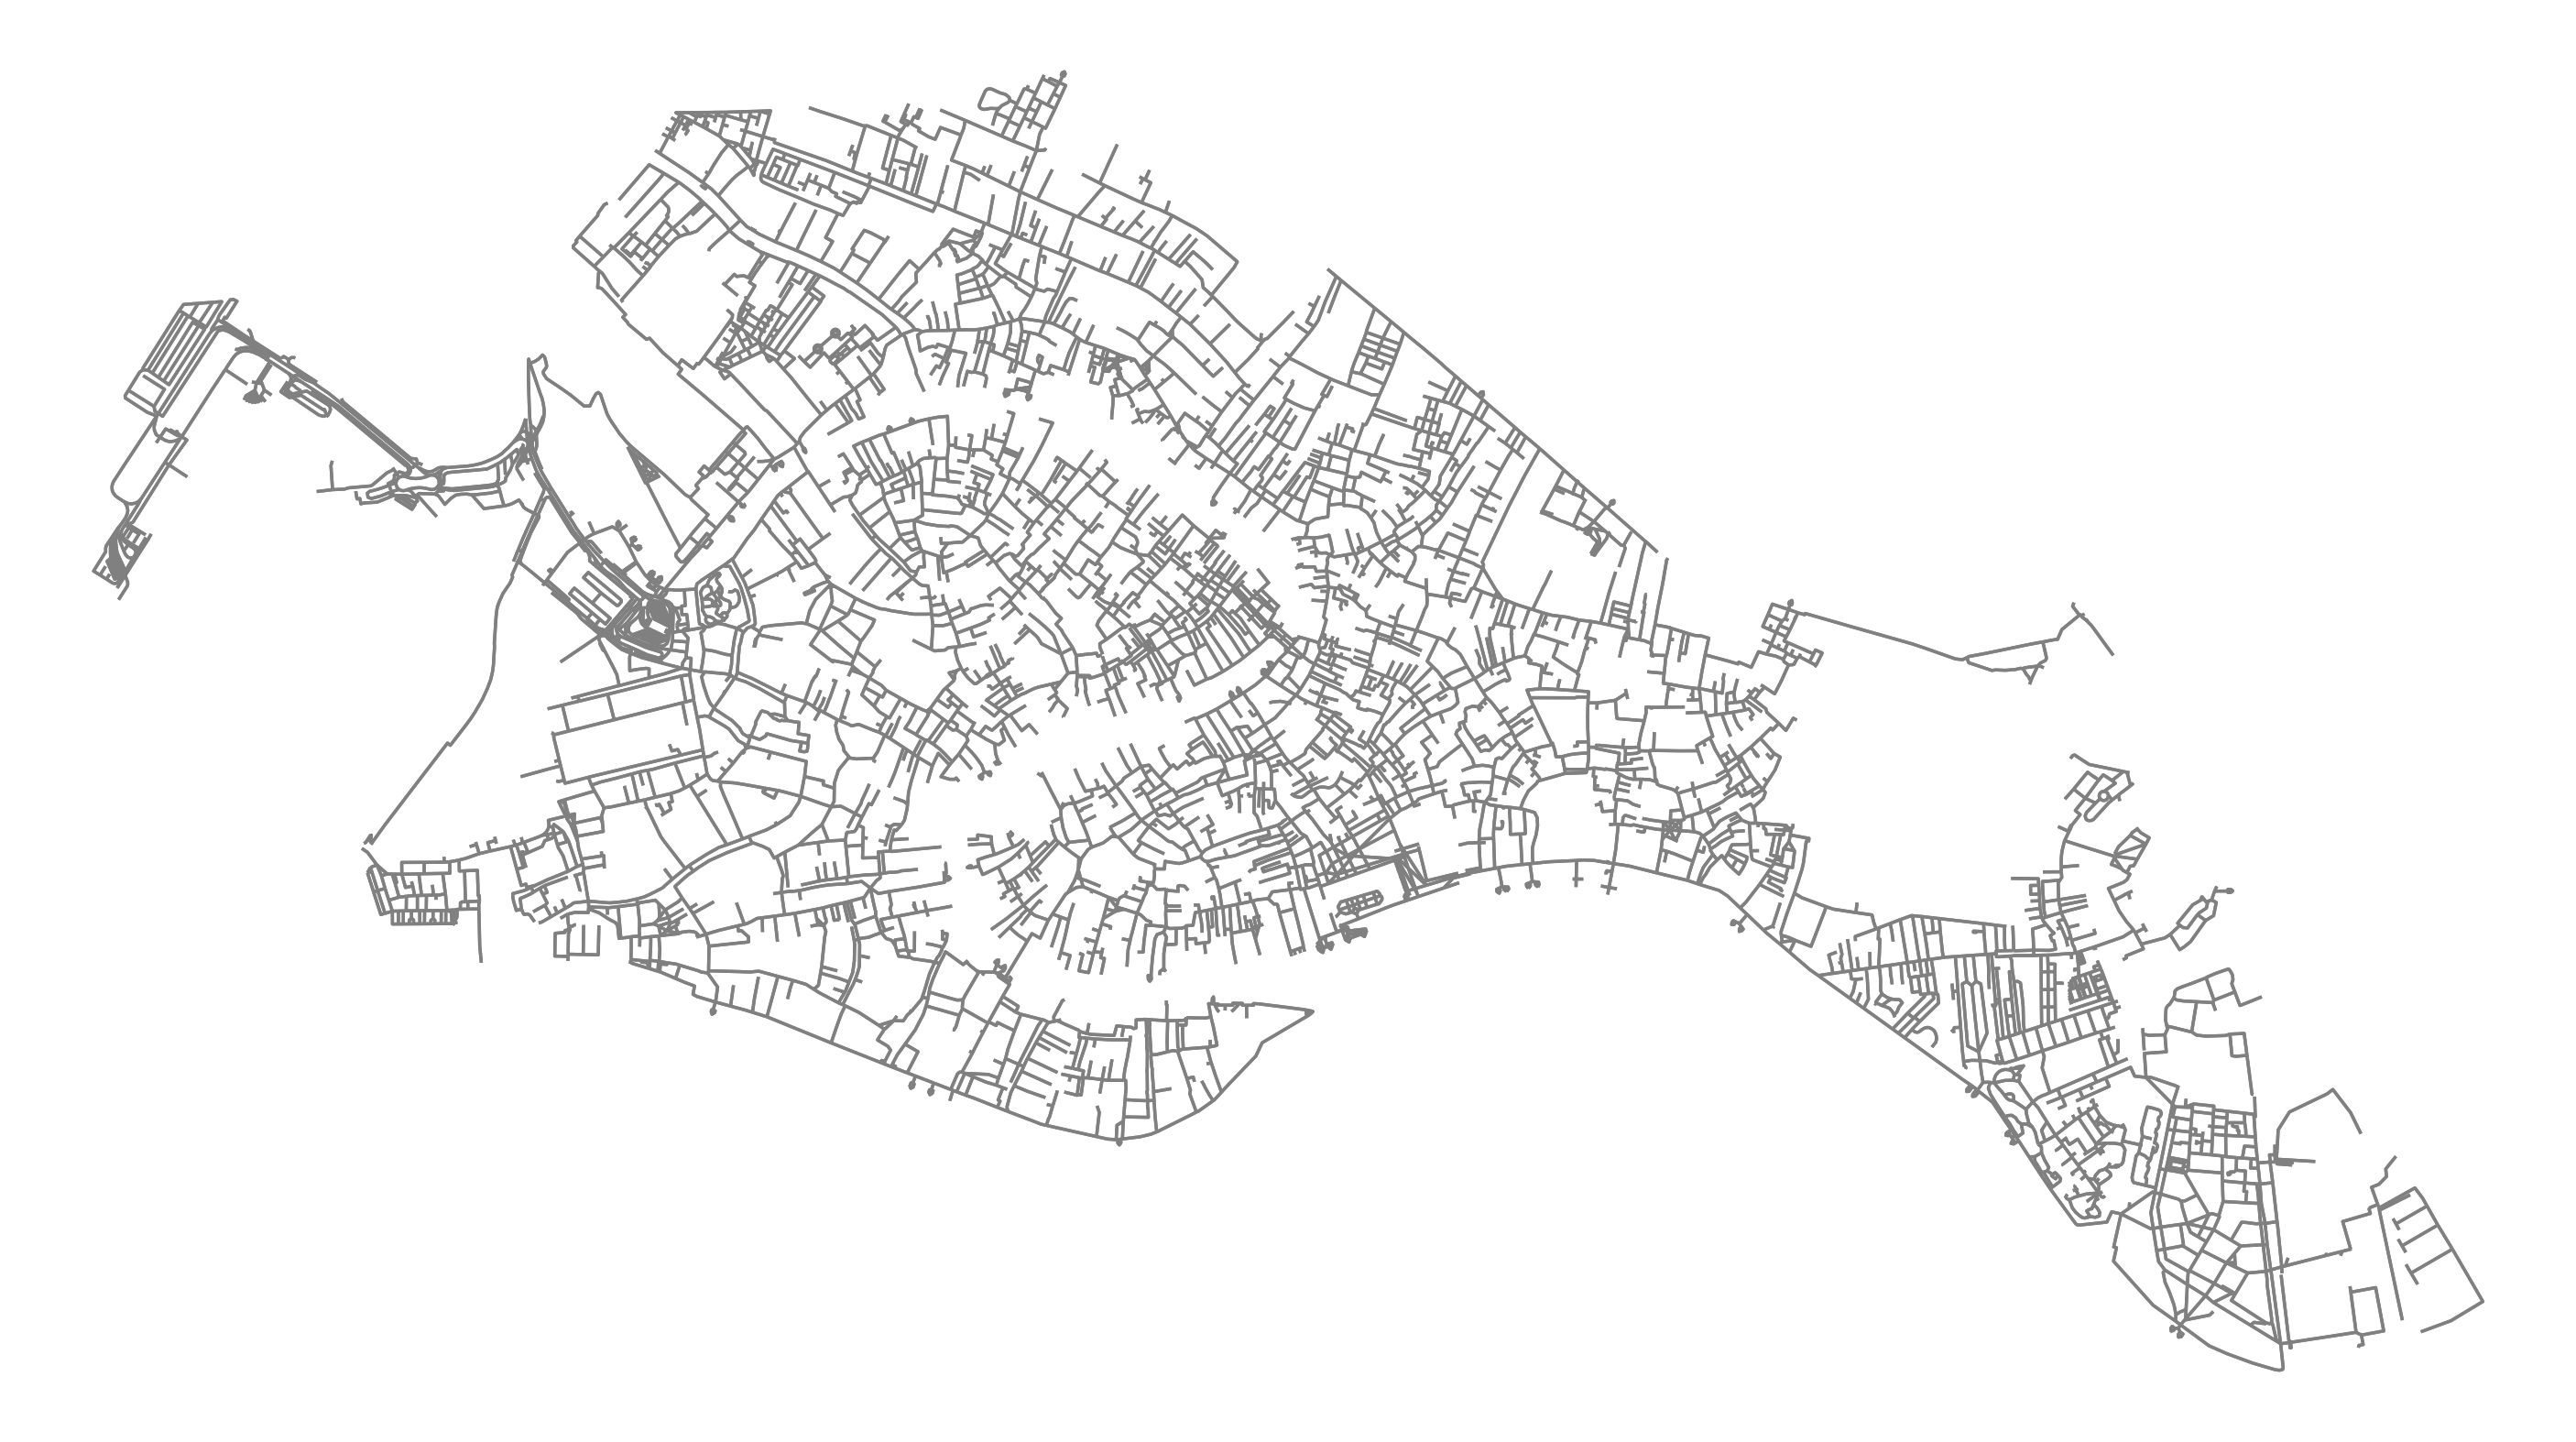

In [11]:
mpl.rcParams['figure.dpi'] = 500
#fig, ax = ox.plot_graph(ox.project_graph(G), node_color='#4CFFD6', node_size=0.5,
#                       edge_color='#4CFFD6', edge_linewidth=0.1, 
#                       figsize=(7, 7))

fig, ax = ox.plot_graph(ox.project_graph(G), 
                       figsize=(7, 7), node_size = 0, bgcolor="white", node_color = "black", 
                       edge_color='gray', edge_linewidth=0.5)

In [12]:
nodes, edges = ox.graph_to_gdfs(G, nodes = True, edges= True)

In [13]:
nodes.head(3)

y          x  street_count highway  \
osmid                                                  
27178184  45.438197  12.335686             4     NaN   
27178422  45.432325  12.337206             4     NaN   
27178423  45.432482  12.337658             3     NaN   

                           geometry  
osmid                                
27178184  POINT (12.33569 45.43820)  
27178422  POINT (12.33721 45.43233)  
27178423  POINT (12.33766 45.43248)

In [14]:
edges.head(3)

osmid bridge             name  highway  oneway  \
u        v          key                                                       
27178184 764403528  0    166489461    yes  Ponte di Rialto  footway   False   
         1675825096 0    166489461    yes  Ponte di Rialto  footway   False   
         8670969688 0    450089474    yes  Ponte di Rialto    steps   False   

                        reversed  length width  \
u        v          key                          
27178184 764403528  0      False   9.935   NaN   
         1675825096 0       True   5.120   NaN   
         8670969688 0      False   9.212     7   

                                                                  geometry  \
u        v          key                                                      
27178184 764403528  0    LINESTRING (12.33569 45.43820, 12.33561 45.43813)   
         1675825096 0    LINESTRING (12.33569 45.43820, 12.33573 45.43823)   
         8670969688 0    LINESTRING (12.33569 45.43820, 12.33560 45.43825)   

                        tunnel lanes maxspeed est_width access area service  \
u        v          key                                                       
27178184 764403528  0      NaN   NaN      NaN       NaN    NaN  NaN     NaN   
         1675825096 0      NaN   NaN      NaN       NaN    NaN  NaN     NaN   
         8670969688 0      NaN   NaN      NaN       NaN    NaN  NaN     NaN   

                        junction  ref  
u        v          key                
27178184 764403528  0        NaN  NaN  
         1675825096 0        NaN  NaN  
         8670969688 0        NaN  NaN

##### Creating Pandana Graph for shortest path calculation

In [15]:
# FOR PANDANA
edges_pdna = edges.droplevel(level=2)
edges_pdna["from"] = edges_pdna.index.get_level_values("u")
edges_pdna["to"] = edges_pdna.index.get_level_values("v")
edges_pdna = edges_pdna.drop(['osmid', 'highway', "oneway", "reversed",
                "lanes", "name", "geometry", "maxspeed",
                "access", "junction", "width", "bridge",
                "tunnel", "service", "ref", "est_width", 
                "area"], axis=1)
edges_pdna.insert(2, "length", edges_pdna.pop("length"))
edges_pdna

from           to  length
u           v                                            
27178184    764403528       27178184    764403528   9.935
            1675825096      27178184   1675825096   5.120
            8670969688      27178184   8670969688   9.212
            5395065019      27178184   5395065019  24.986
27178422    223527689       27178422    223527689   7.084
...                              ...          ...     ...
11947815747 11947815746  11947815747  11947815746  15.842
            11947815745  11947815747  11947815745  23.209
11947815750 11947815747  11947815750  11947815747  15.988
            8247397793   11947815750   8247397793   7.004
            11947815744  11947815750  11947815744  24.844

[14220 rows x 3 columns]

In [16]:
nodes_pdna = nodes[["x", "y"]]

In [17]:
G_pdna = pandana.Network(nodes_pdna['x'], nodes_pdna['y'], 
                          edges_pdna['from'], edges_pdna['to'], 
                          edges_pdna[['length']], twoway = True)

#### Defining X minutes city

In [18]:
X_minutes = 15

#### Defining hotels (source nodes)

In [19]:
# Importing the complete hotel dataset

hotels_total = pd.read_excel("Venice_listings_airbnb.xlsx", sheet_name = "listings_cleaned2")

hotels_total = hotels_total.rename(columns={'longitude': 'x_H', 'latitude': 'y_H', 
                                           "number_of_reviews": "review_count_H", "review_scores_rating": "score_H"})

hotels_total['amenities_count'] = hotels_total['amenities'].apply(lambda x: len(json.loads(x)))
hotels_total["name_H"] = range(1, len(hotels_total)+1)

In [20]:
# Classifying amenities

# Step-by-step flattening process
flattened_list = []
for json_str in hotels_total['amenities']:
    sentences = json.loads(json_str)  # Parse the JSON string
    flattened_list.extend(sentences)

# Find the unique sentences
unique_sentences = set(flattened_list)

# Convert the set to a list if needed
amenities_unique_sentences_list = list(unique_sentences)

#pd.DataFrame(amenities_unique_sentences_list).to_csv('amenities_unique_sentences_list.csv', index=False)

In [21]:
# Define categories

# Add the 'TVs' category
hotels_total['TVs'] = hotels_total['amenities'].apply(
    lambda amenities: 1 if any(keyword in json.loads(amenities) for keyword in ['TV', 'HDTV']) else 0
)

# Add the 'WiFi' category
hotels_total['Wifi'] = hotels_total['amenities'].apply(
    lambda amenities: 1 if any(keyword.lower() in amenity.lower() for amenity in json.loads(amenities) for keyword in ['Wifi', 'Wi-Fi', 'internet']) else 0
)

# Add the 'Parking' category
hotels_total['Parking'] = hotels_total['amenities'].apply(
    lambda amenities: 1 if any(keyword.lower() in amenity.lower() for amenity in json.loads(amenities) for keyword in ['parking', 'garage']) else 0
)

# Add the 'Kitchen Appliances' category
hotels_total['Kitchen_Appliances'] = hotels_total['amenities'].apply(
    lambda amenities: 1 if any(keyword.lower() in amenity.lower() for amenity in json.loads(amenities) for keyword in ['oven', 'stove', 'kitchen', 'coffee maker', 'refrigerator', 'microwave', 'toaster']) else 0
)

# Add the 'Bathroom Amenities' category
hotels_total['Bathroom_Amenities'] = hotels_total['amenities'].apply(
    lambda amenities: 1 if any(keyword.lower() in amenity.lower() for amenity in json.loads(amenities) for keyword in ['shampoo', 'conditioner', 'soap', 'towels', 'bathroom']) else 0
)

# Add the 'Child Amenities' category
hotels_total['Child_Amenities'] = hotels_total['amenities'].apply(
    lambda amenities: 1 if any(keyword.lower() in amenity.lower() for amenity in json.loads(amenities) for keyword in ['children', 'child', 'crib', 'high chair', 'playground']) else 0
)

# Add the 'Entertainment Systems' category
hotels_total['Entertainment_Systems'] = hotels_total['amenities'].apply(
    lambda amenities: 1 if any(keyword.lower() in amenity.lower() for amenity in json.loads(amenities) for keyword in ['sound system', 'ping pong', 'game console', 'DVD player']) else 0
)

# Add the 'Miscellaneous' category
hotels_total['Miscellaneous'] = hotels_total.apply(
    lambda row: 1 if not any(row[category] for category in ['TVs', 'Wifi', 'Parking', 'Kitchen_Appliances', 'Bathroom_Amenities', 'Child_Amenities', 'Entertainment_Systems']) else 0,
    axis=1
)

In [22]:
hotels_total.head(3)

id host_response_time  host_response_rate  \
0   684809437988328502       within a day                0.71   
1             42949852     within an hour                1.00   
2  1043464242138231179     within an hour                1.00   

   host_acceptance_rate host_is_superhost neighbourhood_cleansed  \
0                  0.29                 f             Cannaregio   
1                  1.00                 f            Santa Croce   
2                  1.00                 f               Castello   

  neighbourhood_group_cleansed       y_H        x_H  \
0                        Isole  45.44058  12.335800   
1                        Isole  45.44207  12.325640   
2                        Isole  45.43842  12.345624   

                 property_type  ... amenities_count  name_H  TVs  Wifi  \
0                 Entire condo  ...               6       1    1     1   
1  Private room in rental unit  ...              15       2    1     1   
2           Entire rental unit  ...               4       3    0     1   

   Parking Kitchen_Appliances  Bathroom_Amenities  Child_Amenities  \
0        0                  1                   0                0   
1        0                  1                   1                0   
2        0                  1                   0                0   

   Entertainment_Systems  Miscellaneous  
0                      0              0  
1                      0              0  
2                      0              0  

[3 rows x 38 columns]

In [23]:
# Filtering accommodation by presence inside bbox
hotels_df = hotels_total.copy()
print("Total number of accomodation in city: ", len(hotels_df))

hotels_df['in_bbox'] = hotels_df.apply(lambda x: city_polygon.contains(Point(x.x_H, x.y_H)), axis=1)

hotels_df = hotels_df.loc[(hotels_df.in_bbox == True)].reset_index(drop=True)
hotels_df.drop("in_bbox", axis=1, inplace=True)
print("Number of hotels: ", len(hotels_df))
hotels_df.head(3)

Total number of accomodation in city:  6295
Number of hotels:  4851


id host_response_time  host_response_rate  \
0   684809437988328502       within a day                0.71   
1             42949852     within an hour                1.00   
2  1043464242138231179     within an hour                1.00   

   host_acceptance_rate host_is_superhost neighbourhood_cleansed  \
0                  0.29                 f             Cannaregio   
1                  1.00                 f            Santa Croce   
2                  1.00                 f               Castello   

  neighbourhood_group_cleansed       y_H        x_H  \
0                        Isole  45.44058  12.335800   
1                        Isole  45.44207  12.325640   
2                        Isole  45.43842  12.345624   

                 property_type  ... amenities_count  name_H  TVs  Wifi  \
0                 Entire condo  ...               6       1    1     1   
1  Private room in rental unit  ...              15       2    1     1   
2           Entire rental unit  ...               4       3    0     1   

   Parking Kitchen_Appliances  Bathroom_Amenities  Child_Amenities  \
0        0                  1                   0                0   
1        0                  1                   1                0   
2        0                  1                   0                0   

   Entertainment_Systems  Miscellaneous  
0                      0              0  
1                      0              0  
2                      0              0  

[3 rows x 38 columns]

In [24]:
# Getting the nearest node ids to each hotel

id_nearest_node_H, dist_H = ox.distance.nearest_nodes(G, hotels_df['x_H'], 
                                              hotels_df['y_H'], 
                                              return_dist=True)

print("Successful mapping: ", len(hotels_df) == len(id_nearest_node_H))


hotels_df.insert(7, "id_nearest_node_H", id_nearest_node_H)
hotels_df.insert(8, "x_nearest_node_H", 
                 np.float64(nodes.x[id_nearest_node_H]))
hotels_df.insert(9, "y_nearest_node_H", 
                 np.float64(nodes.y[id_nearest_node_H]))

hotels_df.head(3)

Successful mapping:  True


id host_response_time  host_response_rate  \
0   684809437988328502       within a day                0.71   
1             42949852     within an hour                1.00   
2  1043464242138231179     within an hour                1.00   

   host_acceptance_rate host_is_superhost neighbourhood_cleansed  \
0                  0.29                 f             Cannaregio   
1                  1.00                 f            Santa Croce   
2                  1.00                 f               Castello   

  neighbourhood_group_cleansed  id_nearest_node_H  x_nearest_node_H  \
0                        Isole          298034047         12.335737   
1                        Isole         1997124487         12.325759   
2                        Isole         1856296725         12.345586   

   y_nearest_node_H  ...  amenities_count  name_H TVs Wifi  Parking  \
0         45.440494  ...                6       1   1    1        0   
1         45.441920  ...               15       2   1    1        0   
2         45.438243  ...                4       3   0    1        0   

   Kitchen_Appliances  Bathroom_Amenities  Child_Amenities  \
0                   1                   0                0   
1                   1                   1                0   
2                   1                   0                0   

  Entertainment_Systems  Miscellaneous  
0                     0              0  
1                     0              0  
2                     0              0  

[3 rows x 41 columns]

(Mean, Std):  25.4 62.3


<Axes: >

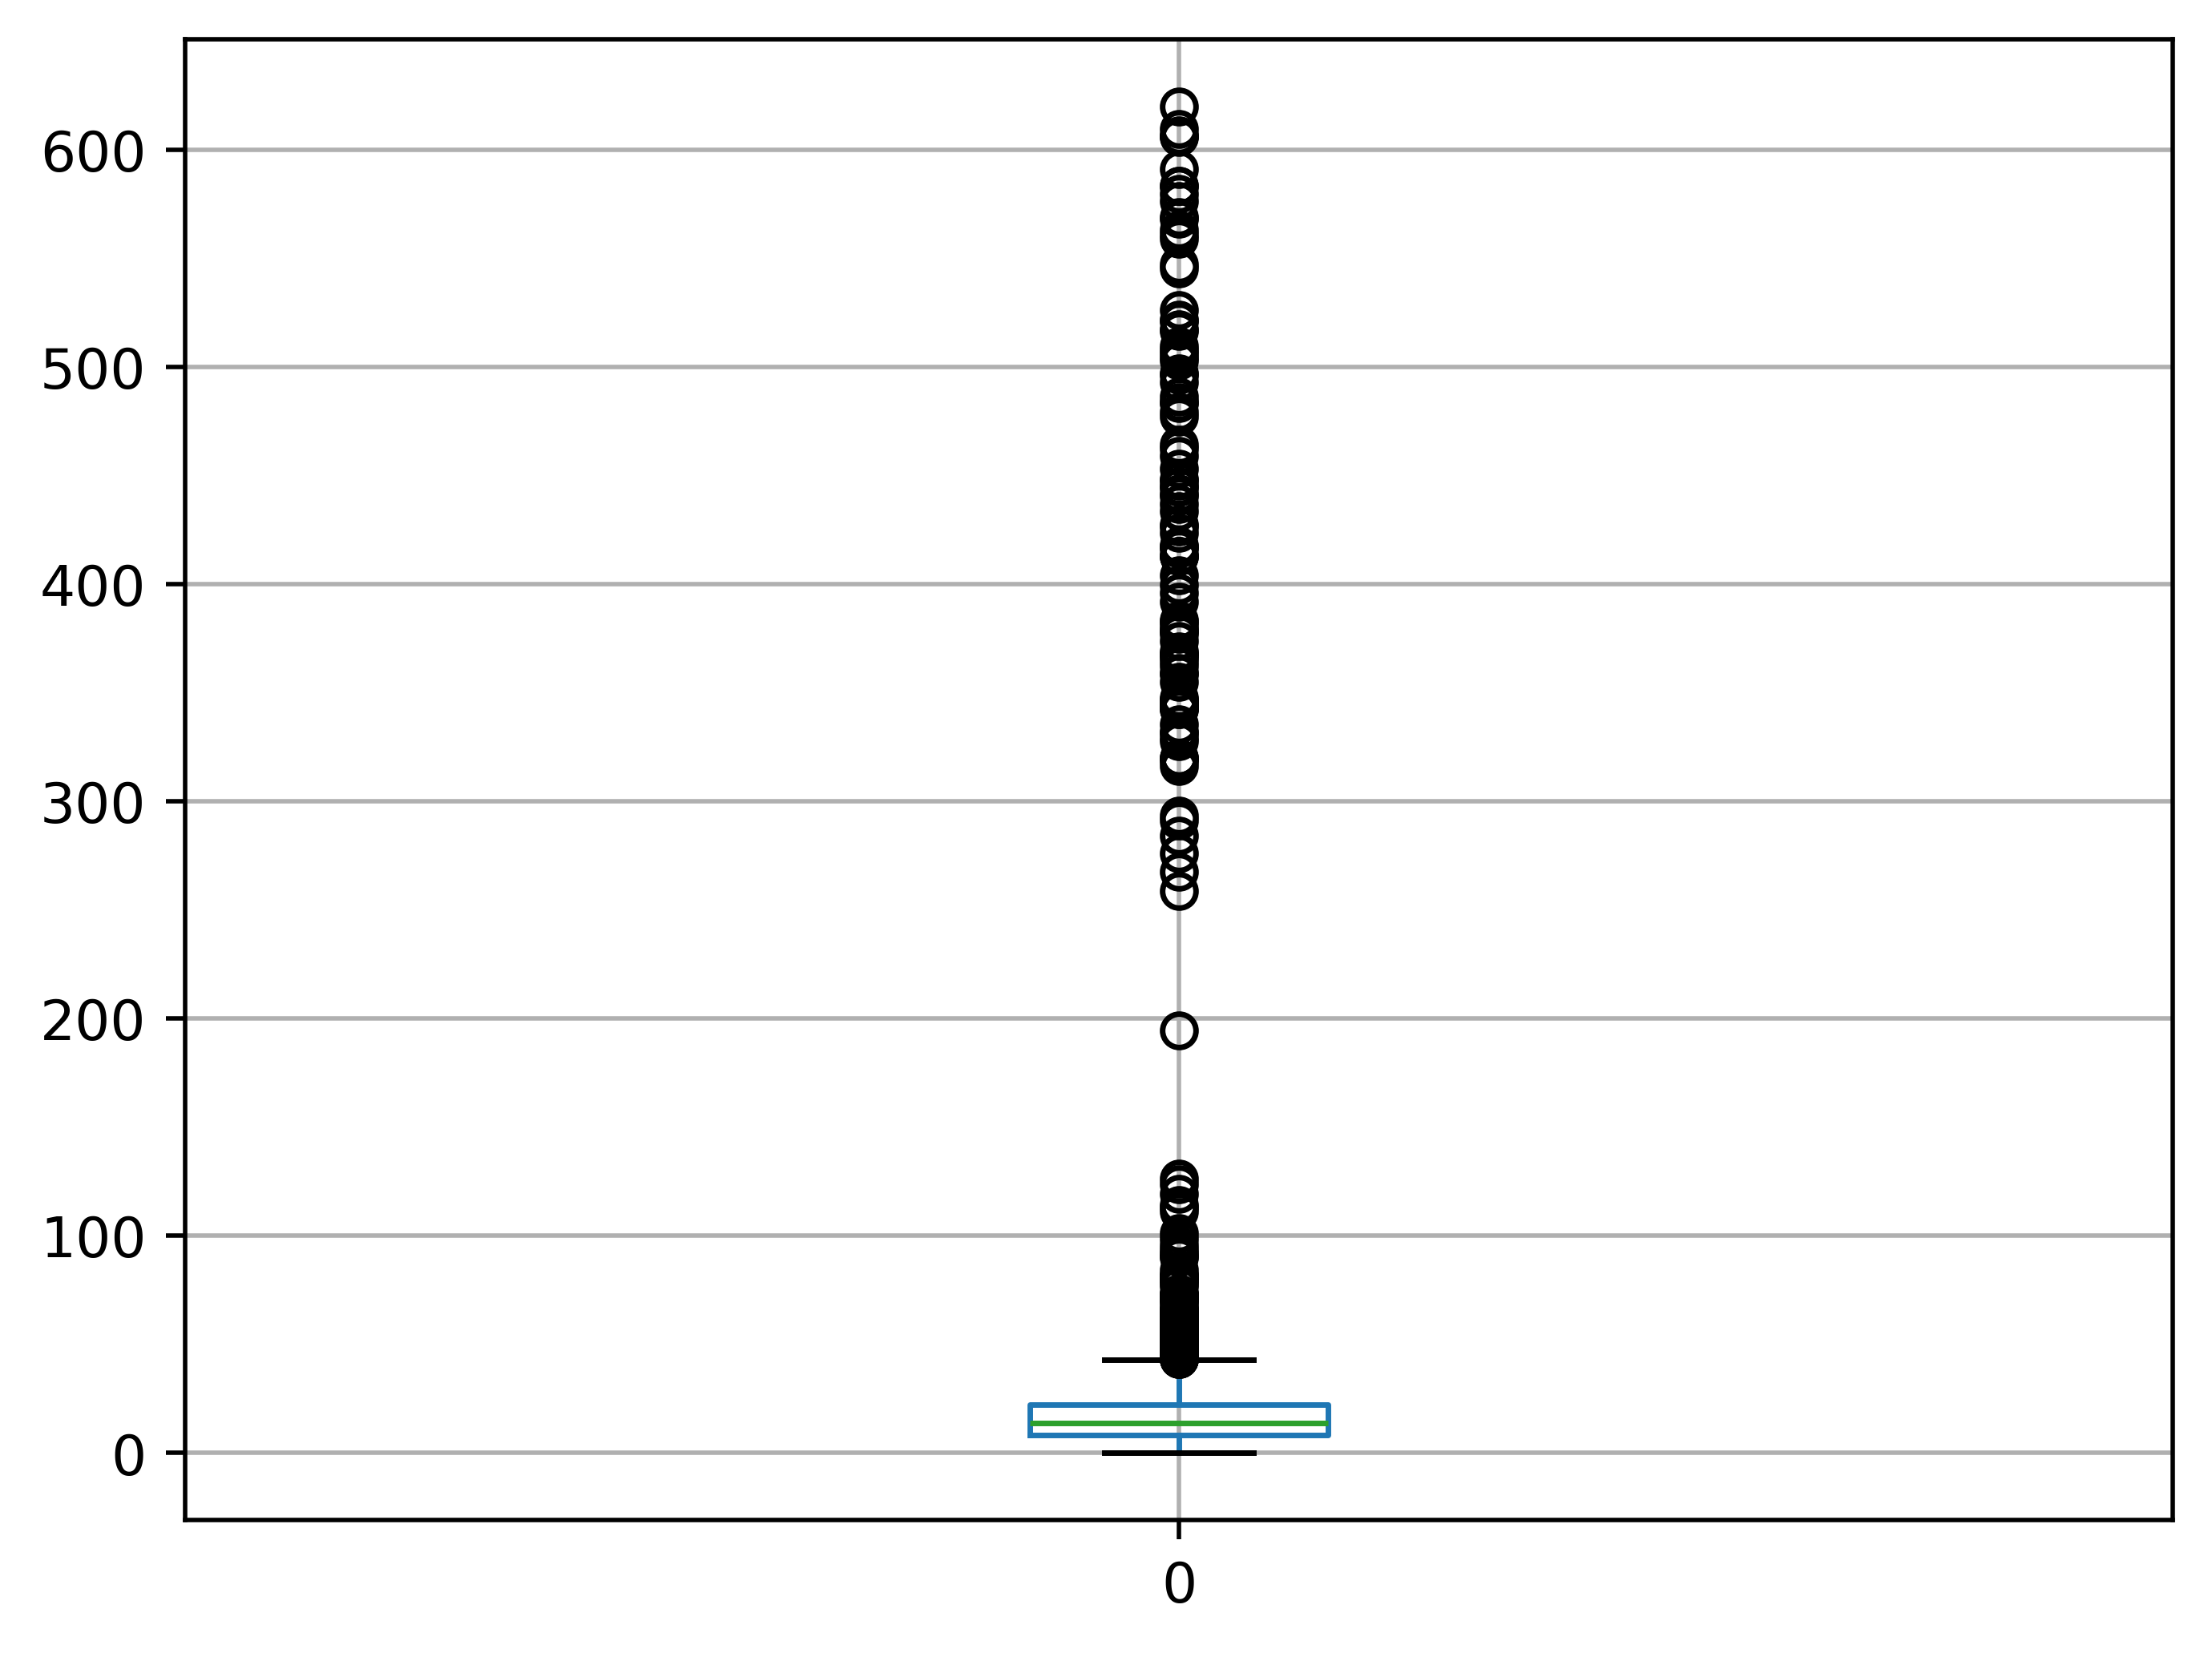

In [25]:
# Distribution of distance
print("(Mean, Std): ", np.around(np.mean(dist_H), decimals=1), np.around(np.std(dist_H), decimals=1))
pd.DataFrame(dist_H).boxplot()

Text(0, 0.5, 'review score')

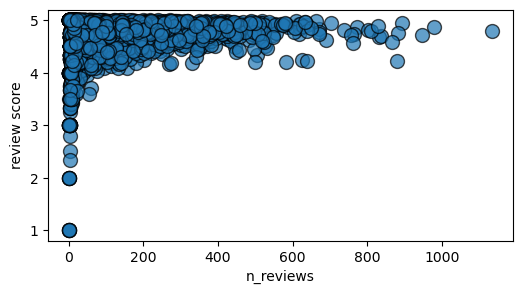

In [26]:
# Distribution of reviews as a function of number of reviews
# for the hotels
mpl.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(figsize = (6, 3))
ax.scatter(hotels_df["review_count_H"], hotels_df["score_H"], 
           s=100, alpha=0.7, edgecolors="k")
#ax.set_xscale("log")
ax.set_xlabel("n_reviews")
ax.set_ylabel("review score")

In [27]:
# Calculating Bayesian Average
#m = np.mean(hotels_df.score_H[hotels_df["score_H"] > 0])
#C = 250
#hotels_df["Bayesian_avg_H"] = ((hotels_df.score_H * hotels_df.review_count_H) 
#                                  + (C * m)) / (C + hotels_df.review_count_H)

S = np.mean(hotels_df.score_H[hotels_df["score_H"] > 0])
m_avg = np.mean(hotels_df.review_count_H[hotels_df["score_H"] > 0])

hotels_df["Bayesian_avg_H"] = (hotels_df.review_count_H/(hotels_df.review_count_H + m_avg)) * hotels_df.score_H +\
                                (m_avg/(hotels_df.review_count_H + m_avg)) * S
hotels_df = hotels_df[(hotels_df.score_H > 0) & (hotels_df.review_count_H > 0)]
print("Number of accommodations: ", len(hotels_df))
hotels_df.head(3)

Number of accommodations:  4851


id host_response_time  host_response_rate  \
0   684809437988328502       within a day                0.71   
1             42949852     within an hour                1.00   
2  1043464242138231179     within an hour                1.00   

   host_acceptance_rate host_is_superhost neighbourhood_cleansed  \
0                  0.29                 f             Cannaregio   
1                  1.00                 f            Santa Croce   
2                  1.00                 f               Castello   

  neighbourhood_group_cleansed  id_nearest_node_H  x_nearest_node_H  \
0                        Isole          298034047         12.335737   
1                        Isole         1997124487         12.325759   
2                        Isole         1856296725         12.345586   

   y_nearest_node_H  ...  name_H  TVs Wifi Parking  Kitchen_Appliances  \
0         45.440494  ...       1    1    1       0                   1   
1         45.441920  ...       2    1    1       0                   1   
2         45.438243  ...       3    0    1       0                   1   

   Bathroom_Amenities  Child_Amenities  Entertainment_Systems Miscellaneous  \
0                   0                0                      0             0   
1                   1                0                      0             0   
2                   0                0                      0             0   

   Bayesian_avg_H  
0        4.723972  
1        4.705667  
2        4.725245  

[3 rows x 42 columns]

<Axes: xlabel='Accommodation type', ylabel='Count'>

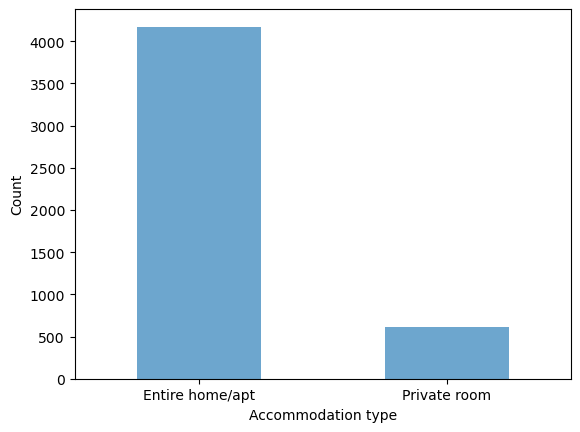

In [28]:
pd.DataFrame(hotels_df[(hotels_df.room_type == "Entire home/apt") | (hotels_df.room_type == "Private room")].room_type.sort_values().value_counts(sort=True)).plot.bar(alpha=0.65, xlabel="Accommodation type", ylabel="Count", rot=0, legend=False)

In [29]:
pd.DataFrame(hotels_df[(hotels_df.room_type == "Entire home/apt") | (hotels_df.room_type == "Private room")].room_type.sort_values().value_counts(sort=True))

count
room_type             
Entire home/apt   4172
Private room       617

#### Defining attractions (destination nodes)

In [30]:
# Importing the complete attractions dataset
attractions_col_names = ["gcode_A", "dcode_A", "name_A", "score_A", "review_count_A", 
                         "x_A", "y_A", "istat_pro_com_A", "municipality_A"] 

attractions_total = pd.read_excel("attraction_dataset.xlsx", sheet_name = "attraction_dataset", 
                                  names = attractions_col_names)

attractions_total.head(3)

gcode_A   dcode_A                    name_A  score_A  review_count_A  \
0  g187785  d2161503        Galleria Borbonica      5.0           10365   
1  g187867   d269082  Cappella degli Scrovegni      5.0            7170   
2  g187867  d8660480               Villa Molin      5.0              35   

         x_A        y_A  istat_pro_com_A municipality_A  
0  14.246260  40.835520            63049         Napoli  
1  11.879536  45.411818            28060         Padova  
2  11.840058  45.362549            28060         Padova

In [31]:
# Filtering attractions by municipality and presence inside bbox
attractions_df = attractions_total.copy()
attractions_df['in_bbox'] = attractions_df.apply(lambda x: city_polygon.contains(Point(x.x_A, x.y_A)), axis=1)
attractions_df = attractions_df.loc[(attractions_df.municipality_A == "Venezia") &
                                   (attractions_df.in_bbox == True)].reset_index(drop=True)
attractions_df.drop("in_bbox", axis=1, inplace=True)
print("Number of attractions: ", len(attractions_df))
attractions_df.head(3)

Number of attractions:  717


gcode_A    dcode_A                                   name_A  score_A  \
0  g187870   d8571065                Centro Storico di Venezia      5.0   
1  g187870   d3981594                  Gioielleria Eredi Jovon      5.0   
2  g187870  d19981154  Creature di Gomma - Venice Vintage Toys      5.0   

   review_count_A        x_A        y_A  istat_pro_com_A municipality_A  
0            2218  12.338472  45.434167            27042        Venezia  
1             476  12.336044  45.437952            27042        Venezia  
2             195  12.327071  45.438269            27042        Venezia

Text(0, 0.5, 'review score')

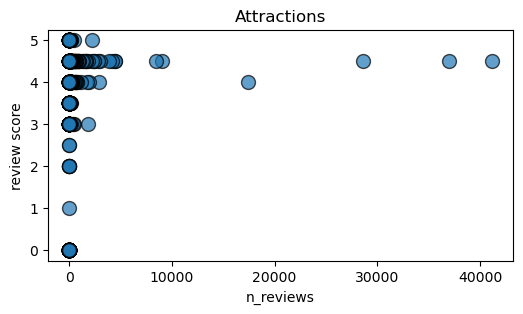

In [32]:
# Distribution of reviews as a function of number of reviews
# for the attractions
fig, ax = plt.subplots(figsize = (6, 3))
ax.scatter(attractions_df["review_count_A"], attractions_df["score_A"], 
           s=100, alpha=0.7, edgecolors="k")
#ax.set_xscale("log")
ax.set_title("Attractions")
ax.set_xlabel("n_reviews")
ax.set_ylabel("review score")

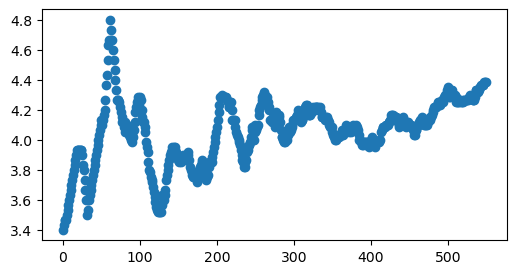

In [33]:
window = 30
j = window - 1
moving_avg = []
df_score = attractions_df.sort_values('review_count_A', ascending = True)
df_score = df_score[df_score["review_count_A"] > 0]
idx = range(0, len(df_score))
for i in idx:
    moving_avg.append(np.mean(df_score.score_A[i:window]))
    window += 1
    if window > len(idx):
        break

fig, ax = plt.subplots(figsize = (6, 3))
#ax.set_xscale("log")
ax.scatter(idx[:-j], moving_avg)    
#ax.set(ylim=(0, 0.000025))

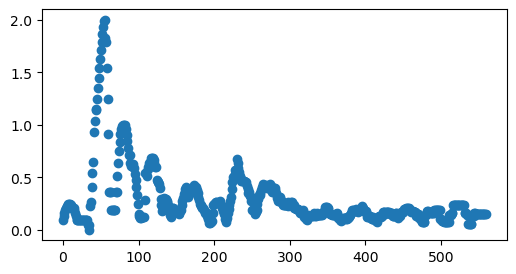

In [34]:
window = 20
j = window - 1
moving_var = []
df_score = attractions_df.sort_values('review_count_A', ascending = True)
df_score = df_score[df_score["review_count_A"] > 0]
idx = range(0, len(df_score))
for i in idx:
    moving_var.append(np.var(df_score.score_A[i:window]))
    window += 1
    if window > len(idx):
        break

fig, ax = plt.subplots(figsize = (6, 3))
#ax.set_xscale("log")
ax.scatter(idx[:-j], moving_var)    
#ax.set(ylim=(0, 0.000025))

In [35]:
# Calculating Bayesian Average for attractions
#m = np.mean(attractions_df.score_A[attractions_df["score_A"] > 0])
#C = 100
#attractions_df["Bayesian_avg_A"] = ((attractions_df.score_A * attractions_df.review_count_A) 
#                                  + (C * m)) / (C + attractions_df.review_count_A)

S = np.mean(attractions_df.score_A[attractions_df["score_A"] > 0])
m_avg = np.mean(attractions_df.review_count_A[attractions_df["score_A"] > 0])

attractions_df["Bayesian_avg_A"] = (attractions_df.review_count_A/(attractions_df.review_count_A + m_avg)) * attractions_df.score_A +\
                                (m_avg/(attractions_df.review_count_A + m_avg)) * S
attractions_df = attractions_df[(attractions_df.score_A > 0) & (attractions_df.review_count_A > 0)]
print("Number of attractions: ", len(attractions_df))
attractions_df.head(10)

Number of attractions:  579


gcode_A    dcode_A                                   name_A  score_A  \
0  g187870   d8571065                Centro Storico di Venezia      5.0   
1  g187870   d3981594                  Gioielleria Eredi Jovon      5.0   
2  g187870  d19981154  Creature di Gomma - Venice Vintage Toys      5.0   
3  g187870  d12176901                 Ca' Zenobio degli Armeni      5.0   
4  g187870   d4591081              The Gritti Epicurean School      5.0   
5  g187870   d6614951        Itaca Art Studio di Monica Martin      5.0   
6  g187870   d8807054                      Le Stanze Del Vetro      5.0   
7  g187870  d10547909         Wood Sculptures by Loris Marazzi      5.0   
8  g187870   d4114830                      Contini Art Gallery      5.0   
9  g187870  d13791846                     AntichitÃ  Guarinoni      5.0   

   review_count_A        x_A        y_A  istat_pro_com_A municipality_A  \
0            2218  12.338472  45.434167            27042        Venezia   
1             476  12.336044  45.437952            27042        Venezia   
2             195  12.327071  45.438269            27042        Venezia   
3             152  12.320833  45.433333            27042        Venezia   
4              87  12.333431  45.431736            27042        Venezia   
5              81  12.323620  45.425657            27042        Venezia   
6              47  12.344811  45.429010            27042        Venezia   
7              42  12.331084  45.430261            27042        Venezia   
8              24  12.334174  45.432832            27042        Venezia   
9              17  12.328483  45.436729            27042        Venezia   

   Bayesian_avg_A  
0        4.859084  
1        4.573338  
2        4.365940  
3        4.314985  
4        4.220264  
5        4.210183  
6        4.147743  
7        4.137718  
8        4.099590  
9        4.083835

In [36]:
# Getting the nearest node ids to each attraction

id_nearest_node_A, dist_A = ox.distance.nearest_nodes(G, attractions_df['x_A'], 
                                              attractions_df['y_A'], 
                                              return_dist=True)

print("Successful mapping: ", len(attractions_df) == len(id_nearest_node_A))


attractions_df.insert(7, "id_nearest_node_A", id_nearest_node_A)
attractions_df.insert(8, "x_nearest_node_A", 
                 np.float64(nodes.x[id_nearest_node_A]))
attractions_df.insert(9, "y_nearest_node_A", 
                 np.float64(nodes.y[id_nearest_node_A]))

attractions_df.head(3)

Successful mapping:  True


gcode_A    dcode_A                                   name_A  score_A  \
0  g187870   d8571065                Centro Storico di Venezia      5.0   
1  g187870   d3981594                  Gioielleria Eredi Jovon      5.0   
2  g187870  d19981154  Creature di Gomma - Venice Vintage Toys      5.0   

   review_count_A        x_A        y_A  id_nearest_node_A  x_nearest_node_A  \
0            2218  12.338472  45.434167         5395074392         12.338188   
1             476  12.336044  45.437952         1779327330         12.336175   
2             195  12.327071  45.438269         4847897732         12.326927   

   y_nearest_node_A  istat_pro_com_A municipality_A  Bayesian_avg_A  
0         45.434080            27042        Venezia        4.859084  
1         45.437910            27042        Venezia        4.573338  
2         45.438199            27042        Venezia        4.365940

(Mean, Std):  41.1 111.3


<Axes: >

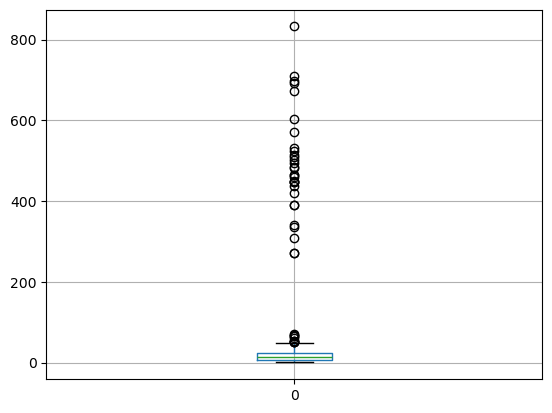

In [37]:
# Distribution of distance
print("(Mean, Std): ", np.around(np.mean(dist_A), decimals=1), np.around(np.std(dist_A), decimals=1))
pd.DataFrame(dist_A).boxplot()

In [38]:
# Filtering top-k attractions based on Bayesian avg.
k = len(attractions_df[attractions_df.Bayesian_avg_A >= 4]) #150 #   len(attractions_df)
top_k_A_df = attractions_df.sort_values('Bayesian_avg_A', ascending = False)[0:k]
top_k_A_df.reset_index(drop = True, inplace=True)

#fig, ax = plt.subplots(figsize = (8, 6))
#ax.scatter(np.arange(1, 376 , dtype=int), top_k_A_df.Bayesian_avg) 

top_k_A_df[["name_A", "score_A", "review_count_A", "Bayesian_avg_A"]].head(10)

name_A  score_A  review_count_A  \
0                Centro Storico di Venezia      5.0            2218   
1                  Gioielleria Eredi Jovon      5.0             476   
2                             Canal Grande      4.5           41167   
3                         Piazza San Marco      4.5           36935   
4                    Basilica di San Marco      4.5           28570   
5                   Campanile di San Marco      4.5            9064   
6              Collezione Peggy Guggenheim      4.5            8433   
7                               Cannaregio      4.5            4481   
8                         Teatro La Fenice      4.5            4409   
9  Basilica Santa Maria Gloriosa dei Frari      4.5            4170   

   Bayesian_avg_A  
0        4.859084  
1        4.573338  
2        4.495788  
3        4.495311  
4        4.493956  
5        4.481476  
6        4.480150  
7        4.464023  
8        4.463482  
9        4.461565

#### Defining restaurants (destination nodes)

In [39]:
# Importing the complete restaurants dataset
restaurants_col_names = ["gcode_A", "dcode_A", "name_R", "score_R", "review_count_R", 
                         "x_R", "y_R", "istat_pro_com_R", "municipality_R"] 

restaurants_total = pd.read_excel("restaurant_dataset.xlsx", sheet_name = "restaurant_dataset_filtered", 
                                  names = restaurants_col_names)

restaurants_total.head(3)

gcode_A    dcode_A            name_R  score_R  review_count_R        x_R  \
0  g194659  d15656043          Al Gallo      2.0               2  11.794100   
1  g194659   d8752262          Al Viale      4.5              13  11.786176   
2  g194659   d6439949  Alibi CafÃ¨ Club      4.0              31  11.786168   

         y_R  istat_pro_com_R municipality_R  
0  45.375183            28001    Abano Terme  
1  45.356347            28001    Abano Terme  
2  45.356669            28001    Abano Terme

In [40]:
# Filtering restaurants by municipality
restaurants_df = restaurants_total.copy()
restaurants_df['in_bbox'] = restaurants_df.apply(lambda x: city_polygon.contains(Point(x.x_R, x.y_R)), axis=1)
restaurants_df = restaurants_df.loc[(restaurants_df.municipality_R == "Venezia") &
                                   (restaurants_df.in_bbox == True)].reset_index(drop=True)
restaurants_df.drop("in_bbox", axis=1, inplace=True)
restaurants_df.head(3)

gcode_A    dcode_A                           name_R  score_R  \
0  g187870  d16897874                     1000 Gourmet      4.0   
1  g187870  d12342787                  6342 Alla Corte      4.5   
2  g187870  d18378017  8 Millimetri - Cicchetti & Wine      5.0   

   review_count_R        x_R        y_R  istat_pro_com_R municipality_R  
0             423  12.338972  45.435770            27042        Venezia  
1             474  12.341592  45.438570            27042        Venezia  
2               2  12.321647  45.435353            27042        Venezia

Text(0, 0.5, 'review score')

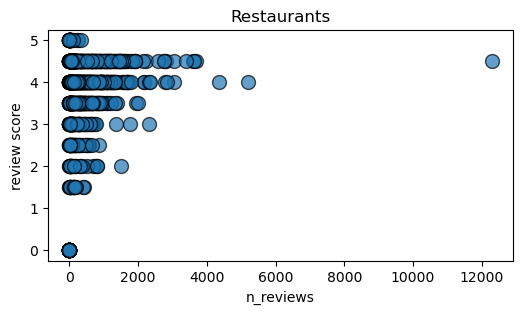

In [41]:
# Distribution of reviews as a function of number of reviews
# for the restaurants
fig, ax = plt.subplots(figsize = (6, 3))
ax.scatter(restaurants_df["review_count_R"], restaurants_df["score_R"], 
           s=100, alpha=0.7, edgecolors="k")
#ax.set_xscale("log")
ax.set_title("Restaurants")
ax.set_xlabel("n_reviews")
ax.set_ylabel("review score")

In [42]:
# Calculating Bayesian Average for restaurants
#m = np.mean(restaurants_df.score_R[restaurants_df["score_R"] > 0])
#C = 100
#restaurants_df["Bayesian_avg_R"] = ((restaurants_df.score_R * restaurants_df.review_count_R) 
#                                  + (C * m)) / (C + restaurants_df.review_count_R)

S = np.mean(restaurants_df.score_R[restaurants_df["score_R"] > 0])
m_avg = np.mean(restaurants_df.review_count_R[restaurants_df["score_R"] > 0])

restaurants_df["Bayesian_avg_R"] = (restaurants_df.review_count_R/(restaurants_df.review_count_R + m_avg)) * restaurants_df.score_R +\
                                (m_avg/(restaurants_df.review_count_R + m_avg)) * S
restaurants_df = restaurants_df[(restaurants_df.score_R > 0) & (restaurants_df.review_count_R > 0)]
print("Number of restaurants: ", len(restaurants_df))
restaurants_df.head(3)

Number of restaurants:  942


gcode_A    dcode_A                           name_R  score_R  \
0  g187870  d16897874                     1000 Gourmet      4.0   
1  g187870  d12342787                  6342 Alla Corte      4.5   
2  g187870  d18378017  8 Millimetri - Cicchetti & Wine      5.0   

   review_count_R        x_R        y_R  istat_pro_com_R municipality_R  \
0             423  12.338972  45.435770            27042        Venezia   
1             474  12.341592  45.438570            27042        Venezia   
2               2  12.321647  45.435353            27042        Venezia   

   Bayesian_avg_R  
0        3.925612  
1        4.187280  
2        3.860204

In [43]:
# Getting the nearest node ids to each restaurant

id_nearest_node_R, dist_R = ox.distance.nearest_nodes(G, restaurants_df['x_R'], 
                                              restaurants_df['y_R'], 
                                              return_dist=True)

print("Successful mapping: ", len(restaurants_df) == len(id_nearest_node_R))


restaurants_df.insert(7, "id_nearest_node_R", id_nearest_node_R)
restaurants_df.insert(8, "x_nearest_node_R", 
                 np.float64(nodes.x[id_nearest_node_R]))
restaurants_df.insert(9, "y_nearest_node_R", 
                 np.float64(nodes.y[id_nearest_node_R]))

restaurants_df

Successful mapping:  True


gcode_A    dcode_A                           name_R  score_R  \
0    g187870  d16897874                     1000 Gourmet      4.0   
1    g187870  d12342787                  6342 Alla Corte      4.5   
2    g187870  d18378017  8 Millimetri - Cicchetti & Wine      5.0   
3    g187870  d17862710     8millimetri Cicchetti & Wine      4.5   
4    g187870   d6378872                 A Beccafico Arte      4.5   
..       ...        ...                              ...      ...   
978  g187870  d18195602                  Why&Not osteria      4.5   
979  g187870   d3678475                   Wine Bar Angio      4.0   
980  g187870   d1527672                      Wine Bar HK      3.5   
981  g187870  d12453577                        Zanze XVI      4.5   
982  g187870   d9597062                           Zikiya      3.5   

     review_count_R        x_R        y_R  id_nearest_node_R  \
0               423  12.338972  45.435770         1920010943   
1               474  12.341592  45.438570         4449378094   
2                 2  12.321647  45.435353         8046900486   
3                 7  12.321647  45.435353         8046900486   
4               787  12.332721  45.442319         8603119897   
..              ...        ...        ...                ...   
978              60  12.334087  45.441641          165384690   
979             143  12.350381  45.432264        10570555917   
980             169  12.339930  45.435709         1864853292   
981             517  12.321290  45.438864           60791970   
982             649  12.335944  45.440517          165390289   

     x_nearest_node_R  y_nearest_node_R  istat_pro_com_R municipality_R  \
0           12.338999         45.435707            27042        Venezia   
1           12.341648         45.438467            27042        Venezia   
2           12.321374         45.435518            27042        Venezia   
3           12.321374         45.435518            27042        Venezia   
4           12.332699         45.442213            27042        Venezia   
..                ...               ...              ...            ...   
978         12.334014         45.441669            27042        Venezia   
979         12.349921         45.432389            27042        Venezia   
980         12.339975         45.435641            27042        Venezia   
981         12.321235         45.438868            27042        Venezia   
982         12.335814         45.440459            27042        Venezia   

     Bayesian_avg_R  
0          3.925612  
1          4.187280  
2          3.860204  
3          3.865056  
4          4.266650  
..              ...  
978        3.931532  
979        3.890263  
980        3.757552  
981        4.201240  
982        3.644676  

[942 rows x 13 columns]

(Mean, Std):  26.5 77.8


<Axes: >

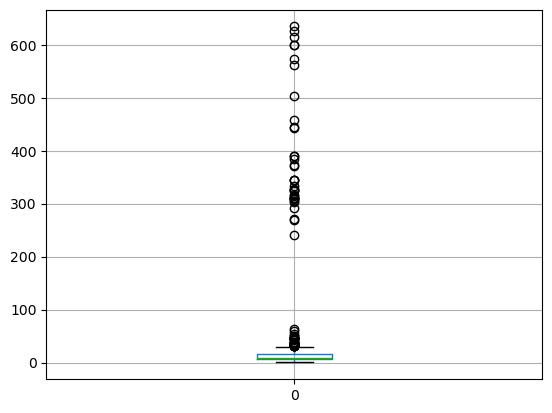

In [44]:
# Distribution of distance
print("(Mean, Std): ", np.around(np.mean(dist_R), decimals=1), np.around(np.std(dist_R), decimals=1))
pd.DataFrame(dist_R).boxplot()

In [45]:
# Filtering top-k restaurants based on Bayesian avg.
k =   len(restaurants_df[restaurants_df.Bayesian_avg_R >= 4]) #700 #  len(restaurants_df)
top_k_R_df = restaurants_df.sort_values('Bayesian_avg_R', ascending = False)[0:k]
top_k_R_df.reset_index(drop = True)

#fig, ax = plt.subplots(figsize = (8, 6))
#ax.scatter(np.arange(1, 376 , dtype=int), top_k_A_df.Bayesian_avg) 

gcode_A    dcode_A                                            name_R  \
0    g187870   d1510422                           Trattoria Al Gazzettino   
1    g187870   d1320417                                           Da Mamo   
2    g187870   d1320424                                Ristorante Florida   
3    g187870    d716300                                 Bistrot de Venise   
4    g187870   d1320368                             Trattoria Bar Pontini   
..       ...        ...                                               ...   
171  g187870  d10275184                                           Boresso   
172  g187870   d1088057                                    Bar Ai Nomboli   
173  g187870   d2230306                                           Imagina   
174  g187870   d4014439                                        Bar Ducale   
175  g187870   d1320335  Ristorante Giardino d'Inverno - Hotel Papadopoli   

     score_R  review_count_R        x_R        y_R  id_nearest_node_R  \
0        4.5           12295  12.337770  45.436388         1794539239   
1        4.5            3696  12.336866  45.437317          411731800   
2        4.5            3640  12.334886  45.437699         4416354255   
3        4.5            3600  12.336477  45.435585          566309166   
4        4.5            3397  12.325357  45.444002         3177979117   
..       ...             ...        ...        ...                ...   
171      5.0              69  12.329589  45.440469         1856706783   
172      4.5             139  12.328513  45.436389           30025067   
173      4.5             139  12.324416  45.433393         3403782567   
174      4.5             131  12.333609  45.432489         1862236259   
175      4.5             131  12.321148  45.437957         1851468109   

     x_nearest_node_R  y_nearest_node_R  istat_pro_com_R municipality_R  \
0           12.337816         45.436365            27042        Venezia   
1           12.336671         45.437355            27042        Venezia   
2           12.334890         45.437658            27042        Venezia   
3           12.336439         45.435553            27042        Venezia   
4           12.325383         45.443909            27042        Venezia   
..                ...               ...              ...            ...   
171         12.329540         45.440471            27042        Venezia   
172         12.328581         45.436398            27042        Venezia   
173         12.324401         45.433228            27042        Venezia   
174         12.333576         45.432490            27042        Venezia   
175         12.321167         45.437895            27042        Venezia   

     Bayesian_avg_R  
0          4.477414  
1          4.430527  
2          4.429575  
3          4.428879  
4          4.425122  
..              ...  
171        4.008423  
172        4.008270  
173        4.008270  
174        4.001455  
175        4.001455  

[176 rows x 13 columns]

#### Defining metro stations (destination nodes)

In [46]:
# Data for specified Vaporetto stops with their coordinates
specified_stops_data = {
    "name_M": ["Piazzale Roma", "Ferrovia", "Rialto", "San Marco", "San Zaccaria", 
               "Lido S.M.E.", "Fondamente Nove", "Murano Colonna", "Murano Faro", "Burano", "Giudecca"],
    "x_M": [12.3194, 12.3211, 12.3358, 12.3390, 12.3432, 
            12.3694, 12.3522, 12.3539, 12.3525, 12.4164, 12.3251],
    "y_M": [45.4379, 45.4419, 45.4383, 45.4342, 45.4346, 
            45.4140, 45.4404, 45.4570, 45.4570, 45.4857, 45.4254]
}

# Creating the DataFrame
tram_df = pd.DataFrame(specified_stops_data)

In [47]:
# Reset index
tram_df.reset_index(drop=True, inplace = True)

# Checking if the stations are inside the city
tram_df['in_bbox'] = tram_df.apply(lambda x: city_polygon.contains(Point(x.x_M, x.y_M)), axis=1)
tram_df = tram_df.loc[tram_df.in_bbox == True].reset_index(drop=True)
tram_df.drop("in_bbox", axis=1, inplace=True)

print("Number of Metro/Tram Stations/Stops: ", len(tram_df))
tram_df

Number of Metro/Tram Stations/Stops:  7


name_M      x_M      y_M
0    Piazzale Roma  12.3194  45.4379
1         Ferrovia  12.3211  45.4419
2           Rialto  12.3358  45.4383
3        San Marco  12.3390  45.4342
4     San Zaccaria  12.3432  45.4346
5  Fondamente Nove  12.3522  45.4404
6         Giudecca  12.3251  45.4254

In [48]:
# Getting the nearest node ids to each tram station

id_nearest_node_M, dist_M = ox.distance.nearest_nodes(G, tram_df['x_M'], 
                                              tram_df['y_M'], 
                                              return_dist=True)

print("Successful mapping: ", len(tram_df) == len(id_nearest_node_M))


tram_df.insert(len(tram_df.columns), "id_nearest_node_M", id_nearest_node_M)
tram_df.insert(len(tram_df.columns), "x_nearest_node_M", 
                 np.float64(nodes.x[id_nearest_node_M]))
tram_df.insert(len(tram_df.columns), "y_nearest_node_M", 
                 np.float64(nodes.y[id_nearest_node_M]))

tram_df

Successful mapping:  True


name_M      x_M      y_M  id_nearest_node_M  x_nearest_node_M  \
0    Piazzale Roma  12.3194  45.4379         3396938627         12.319330   
1         Ferrovia  12.3211  45.4419          318527382         12.321223   
2           Rialto  12.3358  45.4383         1675825096         12.335728   
3        San Marco  12.3390  45.4342        10574768841         12.339149   
4     San Zaccaria  12.3432  45.4346         1863759355         12.342530   
5  Fondamente Nove  12.3522  45.4404         5362332935         12.349851   
6         Giudecca  12.3251  45.4254         1499912526         12.327334   

   y_nearest_node_M  
0         45.437874  
1         45.441755  
2         45.438233  
3         45.434062  
4         45.434469  
5         45.438859  
6         45.429023

#### Defining walking speed

In [49]:
# Defining walking speed
speed_ms = 1 # In m/s
speed_mm = speed_ms * 60 # In m/min

#### Creating the combination of each Hotel to each Attraction to calculate Shortest Paths

In [50]:
# Creating keys for cross join
hotels_df['_key'] = 1 
top_k_A_df['_key'] = 1

# Performing the cross join to obtain Hotels-Attractions Data Frame
H_A_df = pd.merge(hotels_df, top_k_A_df, on='_key').drop('_key', axis=1)
hotels_df = hotels_df.drop("_key", axis=1)
top_k_A_df = top_k_A_df.drop("_key", axis=1)

# Calculating shortest paths in meters and minutes
H_A_df["SP_dist_meters"] = G_pdna.shortest_path_lengths(H_A_df["id_nearest_node_H"], H_A_df["id_nearest_node_A"], 
                      imp_name="length")

H_A_df["SP_dist_minutes"] = H_A_df["SP_dist_meters"] / speed_mm

# Calculating Great Circle distance in meters
H_A_df["GC_dist_meters"] = ox.distance.great_circle(H_A_df.x_nearest_node_H, H_A_df.y_nearest_node_H, 
                                                    H_A_df.x_nearest_node_A, H_A_df.y_nearest_node_A)

# Rearranging DataFrame
H_A_df.insert(0, "name_H", H_A_df.pop("name_H"))
H_A_df.insert(1, "name_A", H_A_df.pop("name_A"))
H_A_df.insert(2, "SP_dist_minutes", H_A_df.pop("SP_dist_minutes"))

In [51]:
H_A_df.sort_values("SP_dist_minutes", ascending = False).head(10)

name_H          name_A  SP_dist_minutes                   id  \
108920      267  Regata Storica       107.515300             24744427   
2518328    5822  Regata Storica       107.089017             18798969   
255560      643  Regata Storica       106.758150   759960952218893509   
156860      391  Regata Storica       106.680350             23635043   
1329416    3086  Regata Storica       106.602850             53716520   
160808      401  Regata Storica       106.233000  1055077288211774430   
1513280    3466  Regata Storica       106.119833             49983770   
2279756    5257  Regata Storica       106.119833             19935227   
1958840    4463  Regata Storica       105.561933             44793900   
1714628    3878  Regata Storica       105.406917   607779138112671857   

         host_response_time  host_response_rate  host_acceptance_rate  \
108920       within an hour                1.00                  1.00   
2518328      within an hour                1.00                  1.00   
255560       within an hour                1.00                  1.00   
156860       within an hour                1.00                  1.00   
1329416      within an hour                1.00                  0.88   
160808   within a few hours                0.96                  0.63   
1513280      within an hour                1.00                  1.00   
2279756      within an hour                1.00                  1.00   
1958840      within an hour                1.00                  1.00   
1714628        within a day                0.71                  0.29   

        host_is_superhost neighbourhood_cleansed neighbourhood_group_cleansed  \
108920                  f             Sant'Elena                        Isole   
2518328                 t             Sant'Elena                        Isole   
255560                  f             Sant'Elena                        Isole   
156860                  t             Sant'Elena                        Isole   
1329416                 f             Sant'Elena                        Isole   
160808                  f             Sant'Elena                        Isole   
1513280                 t             Sant'Elena                        Isole   
2279756                 t             Sant'Elena                        Isole   
1958840                 f             Sant'Elena                        Isole   
1714628                 f             Sant'Elena                        Isole   

         ...        x_A        y_A  id_nearest_node_A  x_nearest_node_A  \
108920   ...  12.309479  45.447638        10214281224         12.306666   
2518328  ...  12.309479  45.447638        10214281224         12.306666   
255560   ...  12.309479  45.447638        10214281224         12.306666   
156860   ...  12.309479  45.447638        10214281224         12.306666   
1329416  ...  12.309479  45.447638        10214281224         12.306666   
160808   ...  12.309479  45.447638        10214281224         12.306666   
1513280  ...  12.309479  45.447638        10214281224         12.306666   
2279756  ...  12.309479  45.447638        10214281224         12.306666   
1958840  ...  12.309479  45.447638        10214281224         12.306666   
1714628  ...  12.309479  45.447638        10214281224         12.306666   

         y_nearest_node_A istat_pro_com_A municipality_A  Bayesian_avg_A  \
108920           45.44377           27042        Venezia        4.109447   
2518328          45.44377           27042        Venezia        4.109447   
255560           45.44377           27042        Venezia        4.109447   
156860           45.44377           27042        Venezia        4.109447   
1329416          45.44377           27042        Venezia        4.109447   
160808           45.44377           27042        Venezia        4.109447   
1513280          45.44377           27042        Venezia        4.109447   
2279756          45.44377           27042        Venezia        4.109447   

#### Creating the combination of each Hotel to each Restaurant to calculate Shortest Paths

In [52]:
# Creating keys for cross join
hotels_df['_key'] = 1 
top_k_R_df['_key'] = 1

# Performing the cross join to obtain Hotels-Restaurants Data Frame
H_R_df = pd.merge(hotels_df, top_k_R_df, on='_key').drop('_key', axis=1)
hotels_df = hotels_df.drop("_key", axis=1)
top_k_R_df = top_k_R_df.drop("_key", axis=1)

# Calculating shortest paths in meters and minutes
H_R_df["SP_dist_meters"] = G_pdna.shortest_path_lengths(H_R_df["id_nearest_node_H"], H_R_df["id_nearest_node_R"], 
                      imp_name="length")

H_R_df["SP_dist_minutes"] = H_R_df["SP_dist_meters"] / speed_mm

# Calculating Great Circle distance in meters
H_R_df["GC_dist_meters"] = ox.distance.great_circle(H_R_df.x_nearest_node_H, H_R_df.y_nearest_node_H, 
                                                    H_R_df.x_nearest_node_R, H_R_df.y_nearest_node_R)

# Rearranging DataFrame
H_R_df.insert(0, "name_H", H_R_df.pop("name_H"))
H_R_df.insert(1, "name_R", H_R_df.pop("name_R"))
H_R_df.insert(2, "SP_dist_minutes", H_R_df.pop("SP_dist_minutes"))

In [53]:
H_R_df.sort_values("SP_dist_minutes", ascending = False).head(3)

name_H      name_R  SP_dist_minutes                   id  \
372023    2790  Vecia Gina        82.068133             19206467   
102567     853  Vecia Gina        82.024833   647466608067971127   
153431    1253  Vecia Gina        82.024833  1000690458044999604   

       host_response_time  host_response_rate  host_acceptance_rate  \
372023     within an hour                 1.0                  0.97   
102567     within an hour                 1.0                  1.00   
153431     within an hour                 1.0                  1.00   

       host_is_superhost neighbourhood_cleansed neighbourhood_group_cleansed  \
372023                 f              Dorsoduro                        Isole   
102567                 f           Sacca Fisola                        Isole   
153431                 f           Sacca Fisola                        Isole   

        ...        x_R        y_R  id_nearest_node_R  x_nearest_node_R  \
372023  ...  12.361812  45.426378         2407022940         12.361712   
102567  ...  12.361812  45.426378         2407022940         12.361712   
153431  ...  12.361812  45.426378         2407022940         12.361712   

        y_nearest_node_R istat_pro_com_R municipality_R  Bayesian_avg_R  \
372023         45.426341           27042        Venezia        4.095384   
102567         45.426341           27042        Venezia        4.095384   
153431         45.426341           27042        Venezia        4.095384   

        SP_dist_meters  GC_dist_meters  
372023        4924.088     5534.528247  
102567        4921.490     5274.545269  
153431        4921.490     5274.545269  

[3 rows x 58 columns]

#### Creating the combination of each Hotel to each Metro/Tram Station/Stop to calculate Shortest Paths

In [54]:
# Creating keys for cross join
hotels_df['_key'] = 1 
tram_df['_key'] = 1

# Performing the cross join to obtain Hotels-Tram Stops Data Frame
H_M_df = pd.merge(hotels_df, tram_df, on='_key').drop('_key', axis=1)
hotels_df = hotels_df.drop("_key", axis=1)
tram_df = tram_df.drop("_key", axis=1)

# Calculating shortest paths in meters and minutes
H_M_df["SP_dist_meters"] = G_pdna.shortest_path_lengths(H_M_df["id_nearest_node_H"], H_M_df["id_nearest_node_M"], 
                      imp_name="length")

H_M_df["SP_dist_minutes"] = H_M_df["SP_dist_meters"] / speed_mm

# Calculating Great Circle distance in meters
H_M_df["GC_dist_meters"] = ox.distance.great_circle(H_M_df.x_nearest_node_H, H_M_df.y_nearest_node_H, 
                                                    H_M_df.x_nearest_node_M, H_M_df.y_nearest_node_M)

# Rearranging DataFrame
H_M_df.insert(0, "name_H", H_M_df.pop("name_H"))
H_M_df.insert(1, "name_M", H_M_df.pop("name_M"))
H_M_df.insert(2, "SP_dist_minutes", H_M_df.pop("SP_dist_minutes"))

In [55]:
# Keeping the closest tram stop, and adding a binary variable
H_M_df = H_M_df.sort_values("SP_dist_minutes", ascending = True).drop_duplicates(['name_H'])
H_M_df["Metro_Tram_stop"] = [1 if x <= X_minutes else 0 for x in H_M_df['SP_dist_minutes']]
H_M_df.reset_index(drop=True, inplace=True)
H_M_df

name_H        name_M  SP_dist_minutes                   id  \
0       4425      Giudecca         0.000000  1045438950210180404   
1       4311      Giudecca         0.000000             13949126   
2        369      Giudecca         0.000000   730141827076853989   
3        399      Giudecca         0.000000             33362370   
4       4432      Giudecca         0.000000             11314292   
...      ...           ...              ...                  ...   
4846    3086  San Zaccaria        34.173367             53716520   
4847     391  San Zaccaria        34.250867             23635043   
4848     643  San Zaccaria        34.328667   759960952218893509   
4849    5822  San Zaccaria        34.659533             18798969   
4850     267  San Zaccaria        35.085817             24744427   

      host_response_time  host_response_rate  host_acceptance_rate  \
0     within a few hours                 1.0                  1.00   
1         within an hour                 1.0                  1.00   
2         within an hour                 1.0                  1.00   
3         within an hour                 1.0                  1.00   
4     within a few hours                 1.0                  0.82   
...                  ...                 ...                   ...   
4846      within an hour                 1.0                  0.88   
4847      within an hour                 1.0                  1.00   
4848      within an hour                 1.0                  1.00   
4849      within an hour                 1.0                  1.00   
4850      within an hour                 1.0                  1.00   

     host_is_superhost neighbourhood_cleansed neighbourhood_group_cleansed  \
0                    f               Giudecca                        Isole   
1                    f               Giudecca                        Isole   
2                    t               Giudecca                        Isole   
3                    t               Giudecca                        Isole   
4                    f               Giudecca                        Isole   
...                ...                    ...                          ...   
4846                 f             Sant'Elena                        Isole   
4847                 t             Sant'Elena                        Isole   
4848                 f             Sant'Elena                        Isole   
4849                 t             Sant'Elena                        Isole   
4850                 f             Sant'Elena                        Isole   

      ...  Miscellaneous  Bayesian_avg_H      x_M      y_M  id_nearest_node_M  \
0     ...              0        4.735002  12.3251  45.4254         1499912526   
1     ...              0        4.857965  12.3251  45.4254         1499912526   
2     ...              0        4.821391  12.3251  45.4254         1499912526   
3     ...              0        4.811134  12.3251  45.4254         1499912526   
4     ...              0        4.772807  12.3251  45.4254         1499912526   
...   ...            ...             ...      ...      ...                ...   
4846  ...              0        4.695538  12.3432  45.4346         1863759355   
4847  ...              0        4.774104  12.3432  45.4346         1863759355   
4848  ...              0        4.741279  12.3432  45.4346         1863759355   
4849  ...              0        4.813334  12.3432  45.4346         1863759355   
4850  ...              0        4.736227  12.3432  45.4346         1863759355   

     x_nearest_node_M y_nearest_node_M  SP_dist_meters  GC_dist_meters  \
0           12.327334        45.429023           0.000        0.000000   
1           12.327334        45.429023           0.000        0.000000   
2           12.327334        45.429023           0.000        0.000000   
3           12.327334        45.429023           0.000        0.000000   
4           12.327334        45.429023           0.000        0.0000

In [56]:
#nx.shortest_path_length(G, 343709332, 332103291, weight = "length") / speed_mm

In [57]:
# Metrics at X minutes distance for attractions

# X minutes level 1
A_lvl1 = pd.DataFrame(H_A_df.name_H[H_A_df["SP_dist_minutes"] <= X_minutes].value_counts())

hotel_name_list_lvl1 = []
hotel_n_reviews_list_lvl1 = []
Bayes_avg_list_H_lvl1 = []

for i in range(0, len(A_lvl1)):
    hotel_name_list_lvl1.append(hotels_df.amenities_count.loc[hotels_df["name_H"] == A_lvl1.index[i]])
    hotel_n_reviews_list_lvl1.append(hotels_df.review_count_H.loc[hotels_df["name_H"] == A_lvl1.index[i]])
    Bayes_avg_list_H_lvl1.append(hotels_df.Bayesian_avg_H.loc[hotels_df["name_H"] == A_lvl1.index[i]])

    
A_lvl1.insert(1, "amenities_count", np.float64(hotel_name_list_lvl1))
A_lvl1.insert(1, "review_count_H", np.float64(hotel_n_reviews_list_lvl1))
A_lvl1.insert(1, "Bayes_avg_H", np.float64(Bayes_avg_list_H_lvl1))
A_lvl1

count  Bayes_avg_H  review_count_H  amenities_count
name_H                                                     
3145      254     4.655424            85.0             21.0
3494      254     4.321437           268.0             14.0
3954      254     4.791214            48.0             30.0
3415      253     4.735002             1.0             11.0
6057      253     4.645426             8.0             29.0
...       ...          ...             ...              ...
5860        6     4.735002             1.0             52.0
2790        6     4.692806            45.0             32.0
853         6     4.713381            86.0             31.0
1253        6     4.767783            16.0             37.0
3086        3     4.695538             7.0             67.0

[4851 rows x 4 columns]

In [58]:
# Metrics at X minutes distance for restaurants

# X minutes level 1
R_lvl1 = pd.DataFrame(H_R_df.name_H[H_R_df["SP_dist_minutes"] <= X_minutes].value_counts())

hotel_name_list_lvl1 = []
hotel_n_reviews_list_lvl1 = []
Bayes_avg_list_H_lvl1 = []

for i in range(0, len(R_lvl1)):
    hotel_name_list_lvl1.append(hotels_df.amenities_count.loc[hotels_df["name_H"] == R_lvl1.index[i]])
    hotel_n_reviews_list_lvl1.append(hotels_df.review_count_H.loc[hotels_df["name_H"] == R_lvl1.index[i]])
    Bayes_avg_list_H_lvl1.append(hotels_df.Bayesian_avg_H.loc[hotels_df["name_H"] == R_lvl1.index[i]])

    
R_lvl1.insert(1, "amenities_count", np.float64(hotel_name_list_lvl1))
R_lvl1.insert(1, "review_count_H", np.float64(hotel_n_reviews_list_lvl1))
R_lvl1.insert(1, "Bayes_avg_H", np.float64(Bayes_avg_list_H_lvl1))
R_lvl1

count  Bayes_avg_H  review_count_H  amenities_count
name_H                                                     
57         88     4.564912            24.0             10.0
4366       88     4.668040           376.0             19.0
3494       88     4.321437           268.0             14.0
3145       87     4.655424            85.0             21.0
4335       87     4.764440           605.0             38.0
...       ...          ...             ...              ...
5822        2     4.813334           111.0             58.0
5876        2     4.823976            83.0             47.0
3466        2     4.776151            25.0             20.0
2632        2     4.789081            84.0             33.0
2790        1     4.692806            45.0             32.0

[4851 rows x 4 columns]

# FOR JUPYTER LAB

test_map = keplergl.KeplerGl()

df = hotels_df[["name_H", "x_H", "y_H"]].copy()
df.rename(columns={"name_H": "Hotel name", "x_H": "Longitude", "y_H":"Latitude"}, inplace = True)
df_Count = []
for name in list(df["Hotel name"]):
    if name in A_lvl1.index:
        df_Count.append(A_lvl1.values[A_lvl1.index==name][0][0])
    else:
        df_Count.append(0)
df.insert(len(df.columns), "Count", df_Count)
test_map.add_data(data=df)

#test_map.add_data(data=counts_H)


orig_html = str(test_map._repr_html_(),'utf-8')

better_html = orig_html
b64 = base64.b64encode(better_html.encode('utf-8'))
src = f"data:text/html;base64,{b64.decode('utf-8')}"
base64d_html = f'<iframe src="{src}" style="width:100%; height: 400px">'
IPython.display.HTML(base64d_html)

In [59]:
# KeplerGL config

kepler_config = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': '2fxa7ht',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels',
      'color': [184, 110, 218],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': [240, 237, 234],
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [184, 110, 218],
        'size': 11,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'csiktu',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_points_TWI',
      'color': [231, 159, 213],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 8,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': [240, 237, 234],
       'colorRange': {'name': 'ColorBrewer RdYlGn-10',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#a50026',
         '#d73027',
         '#f46d43',
         '#fdae61',
         '#fee08b',
         '#d9ef8b',
         '#a6d96a',
         '#66bd63',
         '#1a9850',
         '#006837']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [173, 185, 51],
        'size': 8,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'TWI', 'type': 'real'},
      'colorScale': 'quantize',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'ifo3kcp',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_points_Walkability_num',
      'color': [231, 159, 213],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 8,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': [240, 237, 234],
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [173, 185, 51],
        'size': 8,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Walkability_num',
       'type': 'integer'},
      'colorScale': 'quantize',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': '3tag46c',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_A_count',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Count_A', 'type': 'integer'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Count_A', 'type': 'integer'},
      'sizeScale': 'linear'}},
    {'id': 'aw0qhcc',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_R_count',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Count_R', 'type': 'integer'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Count_R', 'type': 'integer'},
      'sizeScale': 'linear'}},
    {'id': 'pmgr4v',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_M_binary',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Metro_Tram_stop',
       'type': 'integer'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Metro_Tram_stop', 'type': 'integer'},
      'sizeScale': 'linear'}},
    {'id': '76hrvw',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_A_Closeness',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000', '#FF6600', '#FFCC00', '#99FF00', '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Closeness_Centrality_Attractions',
       'type': 'real'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Closeness_Centrality_Attractions',
       'type': 'real'},
      'sizeScale': 'linear'}},
    {'id': 'aqi7i2u',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_R_Closeness',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000', '#FF6600', '#FFCC00', '#99FF00', '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Closeness_Centrality_Restaurants',
       'type': 'real'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Closeness_Centrality_Restaurants',
       'type': 'real'},
      'sizeScale': 'linear'}},
    {'id': 'qy3pmbe',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_class',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000', '#FF6600', '#FFCC00', '#CCFF00', '#00FF00']},
       'coverage': 1,
       'sizeRange': [200, 600],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'average',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantize',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'd9bu4gf',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_score',
      'color': [30, 150, 190],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'coverage': 1,
       'sizeRange': [20, 300],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'average',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Score_H', 'type': 'real'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Score_H', 'type': 'real'},
      'sizeScale': 'linear'}},
    {'id': '6r22q1w',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_review_count',
      'color': [30, 150, 190],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'ColorBrewer RdYlGn-10',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#a50026',
         '#d73027',
         '#f46d43',
         '#fdae61',
         '#fee08b',
         '#d9ef8b',
         '#a6d96a',
         '#66bd63',
         '#1a9850',
         '#006837']},
       'coverage': 1,
       'sizeRange': [20, 300],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'average',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Review_count_H',
       'type': 'integer'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Review_count_H', 'type': 'integer'},
      'sizeScale': 'linear'}},
    {'id': '2sol0j',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_Bayes_Avg',
      'color': [30, 150, 190],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 8],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Bayesian_avg_H',
       'type': 'real'},
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': '6g29u9r',
     'type': 'heatmap',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_heat_map',
      'color': [218, 112, 191],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 0.8,
       'colorRange': {'name': 'ColorBrewer RdYlGn-10',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#a50026',
         '#d73027',
         '#f46d43',
         '#fdae61',
         '#fee08b',
         '#d9ef8b',
         '#a6d96a',
         '#66bd63',
         '#1a9850',
         '#006837']},
       'radius': 100},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'weightField': None, 'weightScale': 'linear'}},
    {'id': '2jqr7zb',
     'type': 'point',
     'config': {'dataId': 'Attractions',
      'label': 'Attractions',
      'color': [36, 115, 189],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': [72, 43, 189],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [66, 101, 204],
        'size': 10,
        'offset': [0, 0],
        'anchor': 'middle',
        'alignment': 'bottom'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'se4ty0m',
     'type': 'point',
     'config': {'dataId': 'Restaurants',
      'label': 'Restaurants',
      'color': [218, 0, 0],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': [30, 150, 190],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [240, 237, 234],
        'size': 8,
        'offset': [0, 0],
        'anchor': 'middle',
        'alignment': 'bottom'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'o69bpud',
     'type': 'point',
     'config': {'dataId': 'Metro/Tram',
      'label': 'Metro/Tram Stops',
      'color': [214, 160, 0],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': [30, 150, 190],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': {'name': 'Tram Stop name', 'type': 'string'},
        'color': [185, 118, 0],
        'size': 10,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'pj7phwm',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'price',
      'color': [34, 63, 154],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#00FF00', '#CCFF00', '#FFCC00', '#FF6600', '#FF0000'],
        'reversed': True},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'mxggy1p',
     'type': 'point',
     'config': {'dataId': 'Attractions',
      'label': 'Bayes Attractions',
      'color': [218, 112, 191],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Bayesian_avg_A',
       'type': 'real'},
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': '79yotqi',
     'type': 'point',
     'config': {'dataId': 'Restaurants',
      'label': 'Bayes Restaurants',
      'color': [218, 112, 191],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude',
       'lng': 'Longitude',
       'altitude': 'Bayesian_avg_R'},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Bayesian_avg_R',
       'type': 'real'},
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'unnamed': [{'name': 'Hotel name',
        'format': None},
       {'name': 'Longitude', 'format': None},
       {'name': 'Latitude', 'format': None},
       {'name': 'Walkability_num', 'format': None}],
      'Attractions': [{'name': 'Attraction name', 'format': None},
       {'name': 'Longitude', 'format': None},
       {'name': 'Latitude', 'format': None}],
      'Restaurants': [{'name': 'Restaurant name', 'format': None},
       {'name': 'Longitude', 'format': None},
       {'name': 'Latitude', 'format': None}],
      'Metro/Tram': [{'name': 'Tram Stop name', 'format': None},
       {'name': 'Longitude', 'format': None},
       {'name': 'Latitude', 'format': None}]},
     'compareMode': False,
     'compareType': 'absolute',
     'enabled': True},
    'brush': {'size': 0, 'enabled': False},
    'geocoder': {'enabled': False},
    'coordinate': {'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 45.435451166836046,
   'longitude': 12.340343624665904,
   'pitch': 0,
   'zoom': 13.13831314348632,
   'isSplit': False},
  'mapStyle': {'styleType': 'a0lwzne',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': False,
    'road': True,
    'building': True,
    'water': True,
    'land': True},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {'a0lwzne': {'accessToken': None,
     'custom': True,
     'icon': 'https://api.mapbox.com/styles/v1/mapbox/streets-v12/static/-122.3391,37.7922,9,0,0/400x300?access_token=pk.eyJ1IjoidWNmLW1hcGJveCIsImEiOiJja3RpeXhkaXcxNzJtMnZxbmtkcnJuM3BkIn0.kGmGlkbuWaCBf7_RrZXULg&logo=false&attribution=false',
     'id': 'a0lwzne',
     'label': 'Mapbox Streets',
     'url': 'mapbox://styles/mapbox/streets-v12'}}}}}

In [60]:
hotels_df.columns

Index(['id', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'id_nearest_node_H', 'x_nearest_node_H',
       'y_nearest_node_H', 'y_H', 'x_H', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'availability_365',
       'review_count_H', 'score_H', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'amenities_count', 'name_H', 'TVs', 'Wifi',
       'Parking', 'Kitchen_Appliances', 'Bathroom_Amenities',
       'Child_Amenities', 'Entertainment_Systems', 'Miscellaneous',
       'Bayesian_avg_H'],
      dtype='object')

In [61]:
# Hotels
df = hotels_df[["name_H", "x_H", "y_H"]].copy()
df.rename(columns={"name_H": "Hotel name", "x_H": "Longitude", "y_H":"Latitude"}, inplace = True)
df_Count_A = []
df_Count_R = []
df_metro_tram_stop = []
df_CC_A = [] # Closeness centrality calculation to each Attraction node (every node)
df_CC_R = [] # Closeness centrality calculation to each Restaurant node (every node)
df_ST_A = [] # Directness calculation to each Attraction node (every node)
df_ST_R = [] # Directness calculation to each Restaurant node (every node)

for name in list(df["Hotel name"]):
    if name in A_lvl1.index:
        df_Count_A.append(A_lvl1.values[A_lvl1.index==name][0][0])
    else:
        df_Count_A.append(0)
    if name in R_lvl1.index:
        df_Count_R.append(R_lvl1.values[R_lvl1.index==name][0][0])
    else:
        df_Count_R.append(0)
    df_metro_tram_stop.append(H_M_df.Metro_Tram_stop[H_M_df.name_H == name].values[0])
    df_CC_A.append(len(top_k_A_df)/np.sum(H_A_df.SP_dist_meters[H_A_df.name_H == name]))
    df_CC_R.append(len(top_k_R_df)/np.sum(H_R_df.SP_dist_meters[H_R_df.name_H == name]))
    df_ST_A.append(len(top_k_A_df)/np.sum(H_A_df.SP_dist_meters[H_A_df.name_H == name]))
    
df.insert(len(df.columns), "Count_A", df_Count_A)
df.insert(len(df.columns), "Count_R", df_Count_R)
df.insert(len(df.columns), "Metro_Tram_stop", df_metro_tram_stop)
df.insert(len(df.columns), "Closeness_Centrality_Attractions", df_CC_A)
df.insert(len(df.columns), "Closeness_Centrality_Restaurants", df_CC_R)
df["amenities_count"] = hotels_df.amenities_count[hotels_df["name_H"] == df["Hotel name"]]
df["Review_count_H"] = hotels_df.review_count_H[hotels_df["name_H"] == df["Hotel name"]]
df["Score_H"] = hotels_df.score_H[hotels_df["name_H"] == df["Hotel name"]]
df["Bayesian_avg_H"] = hotels_df.Bayesian_avg_H[hotels_df["name_H"] == df["Hotel name"]]
df["price"] = hotels_df.price[hotels_df["name_H"] == df["Hotel name"]]
#df["avg_price_log"] = np.log(hotels_df.avg_price[hotels_df["name_H"] == df["Hotel name"]])
df["location_score"] = hotels_df.review_scores_location[hotels_df["name_H"] == df["Hotel name"]]
df["host_response_time"] = hotels_df.host_response_time[hotels_df["name_H"] == df["Hotel name"]]
df["host_response_rate"] = hotels_df.host_response_rate[hotels_df["name_H"] == df["Hotel name"]]
df["host_acceptance_rate"] = hotels_df.host_acceptance_rate[hotels_df["name_H"] == df["Hotel name"]]
df["host_is_superhost"] = hotels_df.host_is_superhost[hotels_df["name_H"] == df["Hotel name"]]
df["neighbourhood_cleansed"] = hotels_df.neighbourhood_cleansed[hotels_df["name_H"] == df["Hotel name"]]
df["property_type"] = hotels_df.property_type[hotels_df["name_H"] == df["Hotel name"]]
df["room_type"] = hotels_df.room_type[hotels_df["name_H"] == df["Hotel name"]]
df["accommodates"] = hotels_df.accommodates[hotels_df["name_H"] == df["Hotel name"]]
df["bathrooms"] = hotels_df.bathrooms[hotels_df["name_H"] == df["Hotel name"]]
df["bedrooms"] = hotels_df.bedrooms[hotels_df["name_H"] == df["Hotel name"]]
df["beds"] = hotels_df.beds[hotels_df["name_H"] == df["Hotel name"]]
df["minimum_nights"] = hotels_df.minimum_nights[hotels_df["name_H"] == df["Hotel name"]]
df["maximum_nights"] = hotels_df.maximum_nights[hotels_df["name_H"] == df["Hotel name"]]
df["availability_365"] = hotels_df.availability_365[hotels_df["name_H"] == df["Hotel name"]]
df["review_scores_accuracy"] = hotels_df.review_scores_accuracy[hotels_df["name_H"] == df["Hotel name"]]
df["review_scores_cleanliness"] = hotels_df.review_scores_cleanliness[hotels_df["name_H"] == df["Hotel name"]]
df["review_scores_checkin"] = hotels_df.review_scores_checkin[hotels_df["name_H"] == df["Hotel name"]]
df["review_scores_communication"] = hotels_df.review_scores_communication[hotels_df["name_H"] == df["Hotel name"]]
df["review_scores_value"] = hotels_df.review_scores_value[hotels_df["name_H"] == df["Hotel name"]]
df["TVs"] = hotels_df.TVs[hotels_df["name_H"] == df["Hotel name"]]
df["Wifi"] = hotels_df.Wifi[hotels_df["name_H"] == df["Hotel name"]]
df["Kitchen_Appliances"] = hotels_df.Kitchen_Appliances[hotels_df["name_H"] == df["Hotel name"]]
df["Parking"] = hotels_df.Parking[hotels_df["name_H"] == df["Hotel name"]]
df["Child_Amenities"] = hotels_df.Child_Amenities[hotels_df["name_H"] == df["Hotel name"]]                          
df["Bathroom_Amenities"] = hotels_df.Bathroom_Amenities[hotels_df["name_H"] == df["Hotel name"]]
df["Entertainment_Systems"] = hotels_df.Entertainment_Systems[hotels_df["name_H"] == df["Hotel name"]]       
df["Miscellaneous"] = hotels_df.Miscellaneous[hotels_df["name_H"] == df["Hotel name"]] 
df["avg_price_log"] = np.log(hotels_df.price[hotels_df["name_H"] == df["Hotel name"]])



# Attractions
df2 = top_k_A_df[["name_A", "x_A", "y_A", "Bayesian_avg_A"]].copy()
df2.rename(columns={"name_A": "Attraction name", "x_A": "Longitude", "y_A":"Latitude"}, inplace = True)

# Restaurants
df3 = top_k_R_df[["name_R", "x_R", "y_R", "Bayesian_avg_R"]].copy()
df3.rename(columns={"name_R": "Restaurant name", "x_R": "Longitude", "y_R":"Latitude"}, inplace = True)

# Metro/Tram
df4 = tram_df[["name_M", "x_M", "y_M"]].copy()
df4.rename(columns={"name_M": "Tram Stop name", "x_M": "Longitude", "y_M":"Latitude"}, inplace = True)

#### Tourism Walkability Index

In [62]:
# Three variables are going to be used for calculating the Tourism Walkability Index:
# Count of Attractions
# Count of Restaurants
# Average of Bayesian Score for Attractions and Restaurants

# Calculating the mean and std of each variable
mean_A = np.mean(df.Count_A)
std_A = np.std(df.Count_A)
mean_R = np.mean(df.Count_R)
std_R = np.std(df.Count_R)
#mean_BA = np.mean(top_k_A_df.Bayesian_avg_A)
#std_BA = np.std(top_k_A_df.Bayesian_avg_A)

mean_BA = np.mean(H_A_df.Bayesian_avg_A[H_A_df["SP_dist_minutes"] <= X_minutes])
std_BA = np.std(H_A_df.Bayesian_avg_A[H_A_df["SP_dist_minutes"] <= X_minutes])
mean_BR = np.mean(H_R_df.Bayesian_avg_R[H_R_df["SP_dist_minutes"] <= X_minutes])
std_BR = np.std(H_R_df.Bayesian_avg_R[H_R_df["SP_dist_minutes"] <= X_minutes])

# Calculating Z-score for each hotel (standarization)
df["Count_A_Z"] = (df.Count_A - mean_A) / std_A
df["Count_R_Z"] = (df.Count_R - mean_R) / std_R
Bayes_mean_A = []
Bayes_mean_R = []
for name in hotels_df.name_H:
    Bayes_aux_A = np.mean(H_A_df.Bayesian_avg_A[(H_A_df["name_H"] ==  name) 
                                                    & (H_A_df["SP_dist_minutes"] <= X_minutes)])
    Bayes_aux_R = np.mean(H_R_df.Bayesian_avg_R[(H_R_df["name_H"] ==  name) 
                                                & (H_R_df["SP_dist_minutes"] <= X_minutes)])
    if np.isnan(Bayes_aux_A):
        Bayes_mean_A.append(0)
    else:
        Bayes_mean_A.append(Bayes_aux_A)
    if np.isnan(Bayes_aux_R):
        Bayes_mean_R.append(0)
    else:
        Bayes_mean_R.append(Bayes_aux_R)
df["Bayes_mean_A"] = Bayes_mean_A
df["Bayes_mean_R"] = Bayes_mean_R

In [63]:
# Defining index using "additive method" (weights can be defined in this step)

check_correlation = 0 # If 1, it looks for the combination that gives the best correlation, if 0, it continues with
# the predefined ones

if check_correlation == 1:
    # Looking for the highest correlation
    # Define the ranges for w1, w2, w3, and w4
    w1_range = np.arange(0, 5.1, 0.2)
    w2_range = np.arange(0, 5.1, 0.2)

    # Initialize variables to store the best correlation and the best weights
    best_corr = -1
    best_weights = (0, 0)

    # Iterate over all combinations of w1, w2, w3, and w4
    jj = 0
    for w1 in w1_range:
        for w2 in w2_range:
            for w3 in w3_range:
                for w4 in w4_range:
                    # Calculate the TWI for the current combination of weights
                    df["TWI"] = (w1 * df["Count_A_Z"] +
                                 w2 * df["Count_R_Z"])
                
                    # Calculate the Spearman correlation
                    corr, _ = pearsonr(df["location_score"], df["TWI"])
                
                    # Update the best correlation and weights if the current correlation is higher
                    if corr > best_corr:
                        best_corr = corr
                        best_weights = (w1, w2)
        jj+=1
        print(f"Iteration {jj}/{len(w1_range)}")
    print(f"Best Spearman correlation: {best_corr}")
    print(f"Best weights: w1={best_weights[0]}, w2={best_weights[1]}")
    df["TWI"] = (best_weights[0] * df["Count_A_Z"] +
                best_weights[1] * df["Count_R_Z"])

else:
    # Output the best correlation and the corresponding weights
    best_weights =  (2, 1) #(1.9, 2.3, 0, 0) # Considering all the attractions and restaurants: w1=0.0, w2=1.0, w3=4.6, w4=0.0 or (0.4, 2.2)
                    # Considering 150 att and 700 rest: (1.6, 1.8, 4.4, 0.0) or (1.9, 2.3)
    df["TWI"] = (best_weights[0] * df["Count_A_Z"] +
                best_weights[1] * df["Count_R_Z"])
    corr, _ = spearmanr(df["location_score"], df["TWI"])
    print(f"Best Spearman correlation: {corr}")
    print(f"Best weights: w1={best_weights[0]}, w2={best_weights[1]}")

# Scaling the index
a = 0 # Min value of the scale
b = 100 # Max value of the scale
df["TWI"] = a + ((df["TWI"] - np.min(df["TWI"])) * (b - a)) / (np.max(df["TWI"]) - np.min(df["TWI"]))

Best Spearman correlation: 0.26657692877686767
Best weights: w1=2, w2=1


Text(0, 0.5, 'TWI')

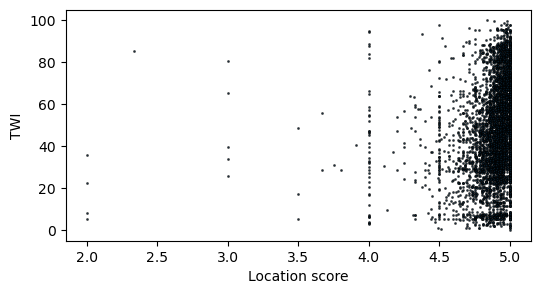

In [64]:
# Distribution of index as a function of location score
fig, ax = plt.subplots(figsize = (6, 3))
ax.scatter(df["location_score"], df["TWI"], 
           s=1, alpha=0.7, edgecolors="k")
#ax.set_xscale("log")
ax.set_xlabel("Location score")
ax.set_ylabel("TWI")

In [65]:
# Index interval classification
conditions = [
    (df['TWI'] > 20) & (df['TWI'] <= 40),
    (df['TWI'] > 40) & (df['TWI'] <= 60),
    (df['TWI'] > 60) & (df['TWI'] <= 80),
    (df['TWI'] > 80) & (df['TWI'] <= 100)]
choices_quali = ['Basic', 'Average', 'High', 'Excelent']
choices_quant = [2, 3, 4, 5]
df['Walkability'] = np.select(conditions, choices_quali, default='Poor')
df['Walkability_num'] = np.select(conditions, choices_quant, default=1)

df

Hotel name  Longitude   Latitude  Count_A  Count_R  Metro_Tram_stop  \
0              1  12.335800  45.440580    160.0     70.0                1   
1              2  12.325640  45.442070     71.0     30.0                1   
2              3  12.345624  45.438420    105.0     54.0                1   
3              4  12.325058  45.431756    154.0     42.0                1   
4              5  12.332160  45.444560     89.0     28.0                0   
...          ...        ...        ...      ...      ...              ...   
4846        6290  12.349963  45.432991     61.0     21.0                1   
4847        6292  12.333000  45.439690    141.0     67.0                1   
4848        6293  12.337540  45.438300    203.0     76.0                1   
4849        6294  12.330270  45.439710    114.0     48.0                1   
4850        6295  12.338990  45.438550    205.0     79.0                1   

      Closeness_Centrality_Attractions  Closeness_Centrality_Restaurants  \
0                             0.000803                          0.000868   
1                             0.000620                          0.000690   
2                             0.000639                          0.000692   
3                             0.000700                          0.000688   
4                             0.000614                          0.000656   
...                                ...                               ...   
4846                          0.000522                          0.000533   
4847                          0.000801                          0.000905   
4848                          0.000839                          0.000922   
4849                          0.000747                          0.000856   
4850                          0.000843                          0.000932   

      amenities_count  Review_count_H  ...  Entertainment_Systems  \
0                   6               4  ...                      0   
1                  15               4  ...                      0   
2                   4               8  ...                      0   
3                   9               2  ...                      0   
4                  26             290  ...                      0   
...               ...             ...  ...                    ...   
4846               10              22  ...                      0   
4847               31             247  ...                      0   
4848               45             460  ...                      0   
4849               23              89  ...                      0   
4850               21             172  ...                      0   

      Miscellaneous  avg_price_log  Count_A_Z Count_R_Z  Bayes_mean_A  \
0                 0       5.129899   0.697772  1.274433      4.066912   
1                 0       4.442651  -0.894571 -0.580685      4.067211   
2                 0       4.304065  -0.286260  0.532386      4.078860   
3                 0       5.247024   0.590423 -0.024150      4.083545   
4                 0       4.795791  -0.572524 -0.673441      4.057673   
...             ...            ...        ...       ...           ...   
4846              0       4.595120  -1.073486 -0.998087      4.077396   
4847              0       4.976734   0.357834  1.135299      4.071942   
4848              0       5.170484   1.467107  1.552701      4.077769   
4849              0       5.105945  -0.125237  0.254118      4.073782   
4850              0       4.787492   1.502890  1.691835      4.076506   

      Bayes_mean_R        TWI Walkability Walkability_num  
0         4.248563  67.629968        High               4  
1         4.218478  28.772676       Basic               2  
2         4.248115  46.734791     Average               3  
3         4.202465  55.962455     Average               3  
4         4.244278  33.023536       Basic               2  
...            ...        ...         ...             ...  
4846      4.226173  22.795580       Basic 

<Axes: xlabel='Walkability', ylabel='Count'>

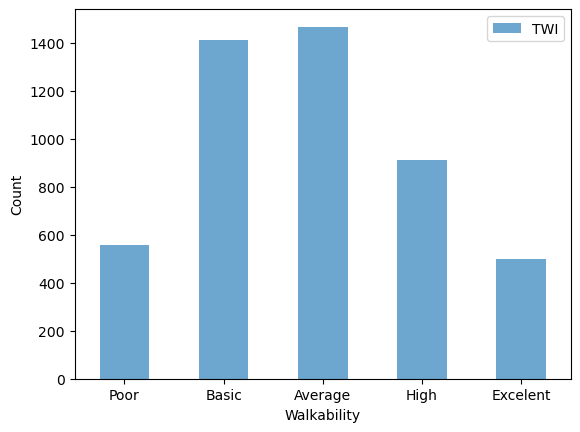

In [66]:
# Walkability index histogram
# Walkability index histogram
counts_for_plot = []
walkability_levels = ['Poor', 'Basic', 'Average', 'High', 'Excelent']
for i in walkability_levels:
    if i in df.Walkability.values:
        counts_for_plot.append(len(df[df.Walkability == i]))
    else:
        counts_for_plot.append(0)
pd.DataFrame({"Walkability":walkability_levels, "TWI":counts_for_plot}).plot.bar(x="Walkability", alpha=0.65, xlabel="Walkability", ylabel="Count", rot=0)

In [67]:
test_map = keplergl.KeplerGl(height = 800, config=kepler_config)

test_map.add_data(data=df)
test_map.add_data(data=df2, name="Attractions")
test_map.add_data(data=df3, name="Restaurants")
test_map.add_data(data=df4, name="Metro/Tram")
test_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


C:\Users\mario\anaconda3\Lib\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
C:\Users\mario\anaconda3\Lib\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
C:\Users\mario\anaconda3\Lib\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
C:\Users\mario\anaconda3\Lib\site-packages\jupyter_client\session.py:718:

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '2fxa7ht', 'type': …

In [68]:
test_map.config

{'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': '2fxa7ht',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels',
      'color': [184, 110, 218],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': [240, 237, 234],
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',

In [69]:
# Saving the map to html
test_map.save_to_html(file_name='kepler_map_Venezia_airbnb_15min.html')

Map saved to kepler_map_Venezia_airbnb_15min.html!


In [70]:
df["TWI"].to_excel("TWI_airbnb_Venezia.xlsx")

#### Price analysis

In [71]:
# Run this ONCE
df2 = df.copy()

In [72]:
df = df2

In [73]:
# Removing price outliers
Q1 = df['avg_price_log'].quantile(0.25)
Q3 = df['avg_price_log'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
df = df[(df['avg_price_log'] >= Q1 - 1.5 * IQR) & (df['avg_price_log'] <= Q3 + 1.5 *IQR)]

In [74]:
df.host_is_superhost.value_counts()
#df = df[df.host_is_superhost == "f"]

host_is_superhost
f    2342
t    2302
Name: count, dtype: int64

In [75]:
df['neighbourhood_cleansed'].replace(["Dorsoduro", "Giudecca", "Sant'Elena", 
                                      "Sacca Fisola", "Tronchetto"], "Others", inplace=True)
df['neighbourhood_cleansed'].value_counts()

C:\Users\mario\AppData\Local\Temp\ipykernel_11188\1160868979.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['neighbourhood_cleansed'].replace(["Dorsoduro", "Giudecca", "Sant'Elena",
C:\Users\mario\AppData\Local\Temp\ipykernel_11188\1160868979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['neighbourhood_cleansed'].replace(["Dor

neighbourhood_cleansed
Castello       1211
Cannaregio     1180
San Marco       705
Others          594
San Polo        479
Santa Croce     475
Name: count, dtype: int64

In [76]:
df = df[(df.room_type == "Entire home/apt") | (df.room_type == "Private room")]
df.room_type.value_counts()

room_type
Entire home/apt    3986
Private room        604
Name: count, dtype: int64

In [77]:
df['property_type'].replace(["Private room in home", "Entire loft", "Private room in condo", 
                             "Room in hotel", "Entire vacation home", "Room in boutique hotel", 
                             "Entire townhouse", "Private room in vacation home", 
                             "Entire serviced apartment", "Private room in serviced apartment", 
                             "Private room in guest suite", "Private room", "Private room in guesthouse", 
                             "Entire guest suite", "Tiny home", "Entire home/apt", "Private room in loft", 
                             "Private room in pension", "Room in aparthotel", "Private room in hostel", 
                             "Private room in casa particular", "Private room in townhouse", "Dammuso", 
                             "Entire guesthouse", "Floor", "Private room in farm stay", "Private room in boat", 
                             "Entire place", "Casa particular"]
, "Others", inplace=True)
df['property_type'].value_counts()

C:\Users\mario\AppData\Local\Temp\ipykernel_11188\1479360413.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['property_type'].replace(["Private room in home", "Entire loft", "Private room in condo",


property_type
Entire rental unit                   2924
Entire condo                          742
Others                                452
Private room in rental unit           210
Entire home                           157
Private room in bed and breakfast     105
Name: count, dtype: int64

In [78]:
df.bathrooms = np.ceil(df.bathrooms)
df.bathrooms = df.bathrooms.astype("int")
df['bathrooms'] = np.where(df['bathrooms'] >= 3, 3, df['bathrooms'])
df.bathrooms.value_counts()

bathrooms
1    3275
2    1160
3     155
Name: count, dtype: int64

In [79]:
df = df[df.bedrooms >= 1]
df['bedrooms'] = np.where(df['bedrooms'] >= 3, 3, df['bedrooms'])
df.bedrooms.value_counts()

bedrooms
1    2421
2    1650
3     464
Name: count, dtype: int64

In [80]:
df['beds'] = np.where(df['beds'] >= 4, 4, df['beds'])
df.beds.value_counts()

beds
2    1422
1    1377
3     925
4     811
Name: count, dtype: int64

In [81]:
df['host_response_time'], _ = pd.factorize(df['host_response_time'])
df['host_is_superhost'], _ = pd.factorize(df['host_is_superhost'])
df['neighbourhood_cleansed'], _ = pd.factorize(df['neighbourhood_cleansed'])
df['property_type'], _ = pd.factorize(df['property_type'])
df['room_type'], _ = pd.factorize(df['room_type'])
df['Walkability'], _ = pd.factorize(df['Walkability'])

In [82]:
# Get dummies
df_dummies = pd.get_dummies(df, columns = ["neighbourhood_cleansed",
                                          "property_type", "room_type", 
                                          "host_is_superhost", "bathrooms", 
                                          "bedrooms", "beds", "Walkability_num"], dtype = int)

In [83]:
df_dummies.drop(labels=['Hotel name', "Longitude", "Latitude", "Count_A", "Count_R", 
               "host_response_time", "host_response_rate", "host_acceptance_rate", 
               "Walkability", "Count_A_Z", "Count_R_Z"], axis=1, inplace=True)

In [84]:
# Export the DataFrame to Excel file
#df_dummies.to_excel("Venezia_dataframe_stat_analysis.xlsx")

In [85]:
len(df_dummies)

4535

In [86]:
# amenities_count accommodates bathrooms bedrooms beds minimum_nights maximum_nights availability_365 
# review_scores_accuracy review_scores_cleanliness review_scores_checkin review_scores_communication
# review_scores_value

#df_dummies.boxplot("Bayesian_avg_H")
#df_dummies.boxplot("Bayes_mean_A")
#df_dummies.boxplot("Bayes_mean_R")

#variables_outliers = ["TWI", "Bayesian_avg_H", "Bayes_mean_A", "Bayes_mean_R", "amenities_count", "accommodates", 
#                      "bathrooms", "bedrooms", "beds", "minimum_nights", "maximum_nights", "availability_365"] #,
                      #"review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin",
                      #"review_scores_communication", "review_scores_value", "location_score"]
        
#variables_outliers = ["accommodates", "minimum_nights", "maximum_nights", "availability_365", "bathrooms", "bedrooms", "beds"]#

# Removing outliers
#for outlier in variables_outliers:
#    Q1 = df_dummies[outlier].quantile(0.25)
#    Q3 = df_dummies[outlier].quantile(0.75)
#    IQR = Q3 - Q1    #IQR is interquartile range. 
#    df_dummies = df_dummies[(df_dummies[outlier] >= Q1 - 1.5 * IQR) & (df_dummies[outlier] <= Q3 + 1.5 *IQR)]

In [87]:
len(df_dummies)

4535

In [88]:
# Scaling the variables that are not scalated
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = RobustScaler()

In [89]:
columns_to_scale_avg_price = ["TWI", "accommodates", "minimum_nights", "maximum_nights", "availability_365", 
                             "amenities_count", "Bayesian_avg_H", 'review_scores_accuracy', 'review_scores_cleanliness',
                               'review_scores_checkin', 'review_scores_communication',
                               'review_scores_value', 'Bayes_mean_A', 'Bayes_mean_R', 'location_score', "Review_count_H", 
                             "Score_H"]

df_dummies_no_scale = df_dummies.copy()

df_dummies[columns_to_scale_avg_price] = scaler.fit_transform(df_dummies[columns_to_scale_avg_price])

In [90]:
df_dummies.columns

Index(['Metro_Tram_stop', 'Closeness_Centrality_Attractions',
       'Closeness_Centrality_Restaurants', 'amenities_count', 'Review_count_H',
       'Score_H', 'Bayesian_avg_H', 'price', 'location_score', 'accommodates',
       'minimum_nights', 'maximum_nights', 'availability_365',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_value', 'TVs', 'Wifi', 'Kitchen_Appliances', 'Parking',
       'Child_Amenities', 'Bathroom_Amenities', 'Entertainment_Systems',
       'Miscellaneous', 'avg_price_log', 'Bayes_mean_A', 'Bayes_mean_R', 'TWI',
       'neighbourhood_cleansed_0', 'neighbourhood_cleansed_1',
       'neighbourhood_cleansed_2', 'neighbourhood_cleansed_3',
       'neighbourhood_cleansed_4', 'neighbourhood_cleansed_5',
       'property_type_0', 'property_type_1', 'property_type_2',
       'property_type_3', 'property_type_4', 'property_type_5', 'room_type_0',
       'room_type_1', 'host_

In [91]:
from scipy.stats import pointbiserialr, pearsonr, chi2_contingency
binary_cols = ['TVs', 'Wifi', 'Parking',
       'Child_Amenities', 'Bathroom_Amenities', 'Entertainment_Systems',
       'Miscellaneous', 
       'neighbourhood_cleansed_1',
       'neighbourhood_cleansed_2', 'neighbourhood_cleansed_3',
       'neighbourhood_cleansed_4', 'neighbourhood_cleansed_5',
       'property_type_0', 'property_type_1', 'property_type_2',
       'property_type_3', 'property_type_4', 'property_type_5',
     'bathrooms_1', 'bathrooms_2', 'bathrooms_3', 'bedrooms_2', 
                'beds_2', 'beds_3', 'Walkability_num_1', 'Walkability_num_2', 'Walkability_num_3',
       'Walkability_num_4', 'Walkability_num_5']
continuous_cols = ['amenities_count', 'Review_count_H', 'Bayesian_avg_H', 'location_score', 'accommodates',
       'minimum_nights', 'maximum_nights', 'availability_365',
        'Bayes_mean_A', 'Bayes_mean_R']

# Initialize a list to store the results
correlation_results = []

# Compute point biserial correlation for each pair of binary and continuous variables
for binary_col in binary_cols:
    for continuous_col in continuous_cols:
        r_pb, p_value = pointbiserialr(df_dummies[binary_col], df_dummies[continuous_col])
        if r_pb >= 0.5 or r_pb <= -0.5:
            correlation_results.append({
                'type': 'Point Biserial',
                'variable1': binary_col,
                'variable2': continuous_col,
                'correlation': r_pb,
                'p_value': p_value
            })

# Compute Cramér's V for each pair of binary variables
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

for i, binary_col1 in enumerate(binary_cols):
    for binary_col2 in binary_cols[i+1:]:
        confusion_matrix = pd.crosstab(df_dummies[binary_col1], df_dummies[binary_col2])
        cramer_v = cramers_v(confusion_matrix)
        if cramer_v >= 0.5:
            correlation_results.append({
                'type': 'Cramér\'s V',
                'variable1': binary_col1,
                'variable2': binary_col2,
                'correlation': cramer_v,
                'p_value': None  # Cramér's V does not have a p-value
            })

# Compute Pearson correlation for each pair of continuous variables
for i, continuous_col1 in enumerate(continuous_cols):
    for continuous_col2 in continuous_cols[i+1:]:
        pearson_corr, p_value = pearsonr(df_dummies[continuous_col1], df_dummies[continuous_col2])
        if pearson_corr >= 0.5 or pearson_corr <= -0.5:
            correlation_results.append({
                'type': 'Pearson',
                'variable1': continuous_col1,
                'variable2': continuous_col2,
                'correlation': pearson_corr,
                'p_value': p_value
            })

# Display the results
for result in correlation_results:
    print(f"Type: {result['type']}, Var 1: {result['variable1']}, "
          f"Var 2: {result['variable2']}, Corr: {result['correlation']}, "
          f"P-value: {result.get('p_value', 'N/A')}")
    
# 'Closeness_Centrality_Attractions', 'Closeness_Centrality_Restaurants', , ,
# , 'TWI', 'host_is_superhost_0', 'host_is_superhost_1', "beds_1",'beds_4',
# "bedrooms_1", "bedrooms_3", 'room_type_0', 'room_type_1', 'Metro_Tram_stop', 
# 'Score_H', "review_scores_cleanliness", 'review_scores_accuracy',
# 'review_scores_checkin', 'review_scores_communication', 'review_scores_value', 
# "neighbourhood_cleansed_0"

Type: Cramér's V, Var 1: property_type_0, Var 2: property_type_2, Corr: 0.5839241997690015, P-value: None
Type: Cramér's V, Var 1: bathrooms_1, Var 2: bathrooms_2, Corr: 0.9172506981872807, P-value: None


In [92]:
df_dummies.columns[:]

Index(['Metro_Tram_stop', 'Closeness_Centrality_Attractions',
       'Closeness_Centrality_Restaurants', 'amenities_count', 'Review_count_H',
       'Score_H', 'Bayesian_avg_H', 'price', 'location_score', 'accommodates',
       'minimum_nights', 'maximum_nights', 'availability_365',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_value', 'TVs', 'Wifi', 'Kitchen_Appliances', 'Parking',
       'Child_Amenities', 'Bathroom_Amenities', 'Entertainment_Systems',
       'Miscellaneous', 'avg_price_log', 'Bayes_mean_A', 'Bayes_mean_R', 'TWI',
       'neighbourhood_cleansed_0', 'neighbourhood_cleansed_1',
       'neighbourhood_cleansed_2', 'neighbourhood_cleansed_3',
       'neighbourhood_cleansed_4', 'neighbourhood_cleansed_5',
       'property_type_0', 'property_type_1', 'property_type_2',
       'property_type_3', 'property_type_4', 'property_type_5', 'room_type_0',
       'room_type_1', 'host_

In [93]:
variables=['TVs', 'Parking',
       'Child_Amenities', 'Bathroom_Amenities', 'Entertainment_Systems',
       'Miscellaneous', 
       'neighbourhood_cleansed_1',
       'neighbourhood_cleansed_2', 'neighbourhood_cleansed_3',
       'neighbourhood_cleansed_4', 'neighbourhood_cleansed_5', 'property_type_1', 'property_type_2',
       'property_type_3', 'property_type_4', 'property_type_5', 'bathrooms_2', 'bathrooms_3', 'bedrooms_2', 
                'beds_2', 'beds_3', 'Walkability_num_2', 'Walkability_num_3',
       'Walkability_num_4', 'Walkability_num_5', 'amenities_count', 'Review_count_H', 'Bayesian_avg_H', 'location_score', 'accommodates',
       'minimum_nights', 'maximum_nights', 'availability_365',
        'Bayes_mean_A', 'Bayes_mean_R']
# Calculate VIF for the provided list of variables
vif_results = [
    (variables[i], variance_inflation_factor(df_dummies[variables].values, i))
    for i in range(len(variables))
    if variance_inflation_factor(df_dummies[variables].values, i) > 5
]
vif_results
# , 'Wifi'

[]

In [99]:
# Multiple linear regression
# Before removing high VIF variables
formula1 = ("avg_price_log ~ Wifi + TVs + Parking + Child_Amenities + Bathroom_Amenities + Entertainment_Systems + Miscellaneous + neighbourhood_cleansed_1 + neighbourhood_cleansed_2 + neighbourhood_cleansed_3 + neighbourhood_cleansed_4 + neighbourhood_cleansed_5 + property_type_1 + property_type_2 + property_type_3 + property_type_4 + property_type_5 + bathrooms_2 + bathrooms_3 + bedrooms_2 + beds_2 + beds_3 + Walkability_num_2 + Walkability_num_3 + Walkability_num_4 + Walkability_num_5 + amenities_count + Review_count_H + Bayesian_avg_H + location_score + accommodates + minimum_nights + maximum_nights + availability_365 + Bayes_mean_A + Bayes_mean_R")

# After removing high VIF variables with the previous chunk
formula2 = ("avg_price_log ~ TVs + Parking + Child_Amenities + Bathroom_Amenities + Entertainment_Systems + Miscellaneous + neighbourhood_cleansed_1 + neighbourhood_cleansed_2 + neighbourhood_cleansed_3 + neighbourhood_cleansed_4 + neighbourhood_cleansed_5 + property_type_1 + property_type_2 + property_type_3 + property_type_4 + property_type_5 + bathrooms_2 + bathrooms_3 + bedrooms_2 + beds_2 + beds_3 + Walkability_num_2 + Walkability_num_3 + Walkability_num_4 + Walkability_num_5 + amenities_count + Review_count_H + Bayesian_avg_H + location_score + accommodates + minimum_nights + maximum_nights + availability_365 + Bayes_mean_A + Bayes_mean_R")

model_lr = ols(formula2,  
            data=df_dummies)

results_lr = model_lr.fit()
results_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          avg_price_log   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     110.0
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        21:28:54   Log-Likelihood:                -1103.4
No. Observations:                4535   AIC:                             2279.
Df Residuals:                    4499   BIC:                             2510.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.8971      0.030    163.562      0.000       4.838       4.956
TVs                          0.0520      0.010      5.218      0.000       0.032       0.071
Parking                      0.0031      0.015      0.212      0.832      -0.026       0.032
Child_Amenities              0.0150      0.011      1.404      0.160      -0.006       0.036
Bathroom_Amenities           0.0281      0.011      2.514      0.012       0.006       0.050
Entertainment_Systems        0.0477      0.025      1.907      0.057      -0.001       0.097
Miscellaneous               -0.1435      0.105     -1.370      0.171      -0.349       0.062
neighbourhood_cleansed_1     0.0236      0.023      1.040      0.299      -0.021       0.068
neighbourhood_cleansed_2    -0.0073      0.020     -0.372      0.710      -0.046       0.031
neighbourhood_cleansed_3     0.0076      0.026      0.294      0.769      -0.043       0.059
neighbourhood_cleansed_4     0.1147      0.020      5.602      0.000       0.075       0.155
neighbourhood_cleansed_5     0.0153      0.022      0.692      0.489      -0.028       0.058
property_type_1             -0.2077      0.026     -8.022      0.000      -0.258      -0.157
property_type_2             -0.0254      0.013     -1.940      0.052      -0.051       0.000
property_type_3             -0.0543      0.019     -2.792      0.005      -0.092      -0.016
property_type_4              0.0810      0.033      2.430      0.015       0.016       0.146
property_type_5             -0.0575      0.028     -2.062      0.039      -0.112      -0.003
bathrooms_2                  0.1684      0.012     14.043      0.000       0.145       0.192
bathrooms_3                  0.3624      0.028     12.930      0.000       0.307       0.417
bedrooms_2                   0.0579      0.011      5.174      0.000       0.036       0.080
beds_2                      -0.0254      0.011     -2.293      0.022      -0.047      -0.004
beds_3                      -0.0272      0.013     -2.063      0.039      -0.053      -0.001
Walkability_num_2            0.0528      0.020      2.619      0.009       0.013       0.092
Walkability_num_3            0.1045      0.022      4.842      0.000       0.062       0.147
Walkability_num_4            0.1082      0.024      4.580      0.000       0.062       0.155
Walkability_num_5            0.1195      0.025      4.791      0.000       0.071       0.168
amenities_count              0.0315      0.009      3.472      0.001       0.014       0.049
Review_count_H              -0.0969      0.005    -18.120      0.000      -0.107      -0.086
Bayesian_avg_H               0.0865      0.005     16.238      0.000       0.076       0.097
location_score               0.0156      0.003      4.892      0.000       0.009       0.022
accommodates  

In [755]:
# Perform backward elimination

while True:
    p_values = results_lr.pvalues.iloc[1:]  # Exclude intercept
    max_p_value = p_values.max()
    if max_p_value > 0.05:
        excluded_feature = p_values.idxmax()
        formula = model_lr.formula.replace(f" + {excluded_feature}", "").replace(f"{excluded_feature} + ", "")
        model_lr = ols(formula, data=df_dummies)
        results_lr = model_lr.fit()
        print(f"Excluding {excluded_feature} with p-value {max_p_value}")
    else:
        break
results_lr.summary()

Excluding Parking with p-value 0.8322164600905685
Excluding neighbourhood_cleansed_3 with p-value 0.7653536471041428
Excluding neighbourhood_cleansed_5 with p-value 0.5189580863913292
Excluding neighbourhood_cleansed_1 with p-value 0.31893692962352915
Excluding Bayes_mean_R with p-value 0.2746358842636674
Excluding neighbourhood_cleansed_2 with p-value 0.3057937560940304
Excluding Miscellaneous with p-value 0.18252085818332436
Excluding Bayes_mean_A with p-value 0.1673269632325977
Excluding Child_Amenities with p-value 0.1508067617373328
Excluding property_type_2 with p-value 0.08282112187868189
Excluding property_type_5 with p-value 0.12887867563593902
Excluding Entertainment_Systems with p-value 0.07954371533853
Excluding minimum_nights with p-value 0.06091308553214404
Excluding property_type_3 with p-value 0.06596278614960917


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          avg_price_log   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     181.7
Date:                Sun, 28 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:41:23   Log-Likelihood:                -1115.8
No. Observations:                4535   AIC:                             2276.
Df Residuals:                    4513   BIC:                             2417.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.8539      0.018    276.978      0.000       4.820       4.888
TVs                          0.0532      0.010      5.398      0.000       0.034       0.072
Bathroom_Amenities           0.0246      0.011      2.224      0.026       0.003       0.046
neighbourhood_cleansed_4     0.1128      0.015      7.726      0.000       0.084       0.141
property_type_1             -0.1771      0.023     -7.632      0.000      -0.223      -0.132
property_type_4              0.1090      0.031      3.467      0.001       0.047       0.171
bathrooms_2                  0.1653      0.012     13.814      0.000       0.142       0.189
bathrooms_3                  0.3535      0.028     12.697      0.000       0.299       0.408
bedrooms_2                   0.0611      0.011      5.489      0.000       0.039       0.083
beds_2                      -0.0236      0.011     -2.142      0.032      -0.045      -0.002
beds_3                      -0.0263      0.013     -1.997      0.046      -0.052      -0.000
Walkability_num_2            0.0759      0.016      4.733      0.000       0.044       0.107
Walkability_num_3            0.1354      0.016      8.358      0.000       0.104       0.167
Walkability_num_4            0.1405      0.018      7.705      0.000       0.105       0.176
Walkability_num_5            0.1505      0.021      7.052      0.000       0.109       0.192
amenities_count              0.0434      0.008      5.582      0.000       0.028       0.059
Review_count_H              -0.0972      0.005    -18.406      0.000      -0.108      -0.087
Bayesian_avg_H               0.0870      0.005     16.424      0.000       0.077       0.097
location_score               0.0163      0.003      5.121      0.000       0.010       0.023
accommodates                 0.1628      0.007     23.202      0.000       0.149       0.177
maximum_nights               0.0595      0.010      5.677      0.000       0.039       0.080
availability_365             0.0708      0.008      8.691      0.000       0.055       0.087
==============================================================================
Omnibus:                      104.661   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.731
Skew:                           0.299   Prob(JB):                     4.09e-29
Kurtosis:                       3.578   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [756]:
model_lr.formula

'avg_price_log ~ TVs + Bathroom_Amenities + neighbourhood_cleansed_4 + property_type_1 + property_type_4 + bathrooms_2 + bathrooms_3 + bedrooms_2 + beds_2 + beds_3 + Walkability_num_2 + Walkability_num_3 + Walkability_num_4 + Walkability_num_5 + amenities_count + Review_count_H + Bayesian_avg_H + location_score + accommodates + maximum_nights + availability_365'

In [757]:
# Multiple linear regression

model_lr = ols('avg_price_log ~ Walkability_num_2 + Walkability_num_3 + Walkability_num_4 + Walkability_num_5 + Bayesian_avg_H + TVs + Bathroom_Amenities + neighbourhood_cleansed_4 + property_type_1 + property_type_4 + bathrooms_2 + bathrooms_3 + bedrooms_2 + beds_2 + beds_3 + amenities_count + Review_count_H + location_score + accommodates + maximum_nights + availability_365',  
            data=df_dummies)

results_lr = model_lr.fit()
results_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          avg_price_log   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     181.7
Date:                Sun, 28 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:41:23   Log-Likelihood:                -1115.8
No. Observations:                4535   AIC:                             2276.
Df Residuals:                    4513   BIC:                             2417.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.8539      0.018    276.978      0.000       4.820       4.888
Walkability_num_2            0.0759      0.016      4.733      0.000       0.044       0.107
Walkability_num_3            0.1354      0.016      8.358      0.000       0.104       0.167
Walkability_num_4            0.1405      0.018      7.705      0.000       0.105       0.176
Walkability_num_5            0.1505      0.021      7.052      0.000       0.109       0.192
Bayesian_avg_H               0.0870      0.005     16.424      0.000       0.077       0.097
TVs                          0.0532      0.010      5.398      0.000       0.034       0.072
Bathroom_Amenities           0.0246      0.011      2.224      0.026       0.003       0.046
neighbourhood_cleansed_4     0.1128      0.015      7.726      0.000       0.084       0.141
property_type_1             -0.1771      0.023     -7.632      0.000      -0.223      -0.132
property_type_4              0.1090      0.031      3.467      0.001       0.047       0.171
bathrooms_2                  0.1653      0.012     13.814      0.000       0.142       0.189
bathrooms_3                  0.3535      0.028     12.697      0.000       0.299       0.408
bedrooms_2                   0.0611      0.011      5.489      0.000       0.039       0.083
beds_2                      -0.0236      0.011     -2.142      0.032      -0.045      -0.002
beds_3                      -0.0263      0.013     -1.997      0.046      -0.052      -0.000
amenities_count              0.0434      0.008      5.582      0.000       0.028       0.059
Review_count_H              -0.0972      0.005    -18.406      0.000      -0.108      -0.087
location_score               0.0163      0.003      5.121      0.000       0.010       0.023
accommodates                 0.1628      0.007     23.202      0.000       0.149       0.177
maximum_nights               0.0595      0.010      5.677      0.000       0.039       0.080
availability_365             0.0708      0.008      8.691      0.000       0.055       0.087
==============================================================================
Omnibus:                      104.661   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.731
Skew:                           0.299   Prob(JB):                     4.09e-29
Kurtosis:                       3.578   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [758]:
# Variance Inflation Factor (impact over Standard Error (accuracy of estimated coefficients))
# [(list(results_lr.pvalues.iloc[1:].index)[i], variance_inflation_factor(df_dummies[list(results_lr.pvalues.iloc[1:].index)], i)) for i in range(0, len(list(results_lr.pvalues.iloc[1:].index)))]
[(list(results_lr.pvalues.iloc[1:].index)[i], variance_inflation_factor(df_dummies[list(results_lr.pvalues.iloc[1:].index)], i)) for i in range(0, len(list(results_lr.pvalues.iloc[1:].index))) if variance_inflation_factor(df_dummies[list(results_lr.pvalues.iloc[1:].index)], i) > 5]

[]

ShapiroResult(statistic=0.9933027029037476, pvalue=9.60418607164927e-14)
Kolmogorov-Smirnov test: Statistic=0.0349686527423172, p-value=2.972559121467483e-05


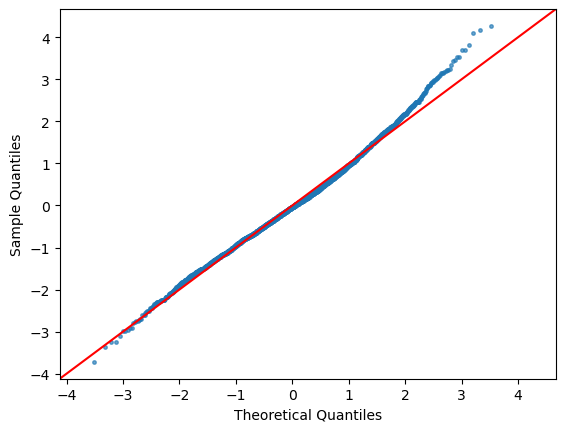

In [759]:
## Assessing normality of residuals Shapiro-Wilk test and QQ-plot
# Null hypothesis: residuals follow a normal distribution
residuals_lr = results_lr.resid
print(shapiro(residuals_lr))
ks_test = kstest(residuals_lr, 'norm', args=(np.mean(residuals_lr), np.std(residuals_lr)))
print(f"Kolmogorov-Smirnov test: Statistic={ks_test.statistic}, p-value={ks_test.pvalue}")
fig = sm.qqplot(residuals_lr, fit=True, line="45", alpha=0.65, markersize=2.5)
plt.show()

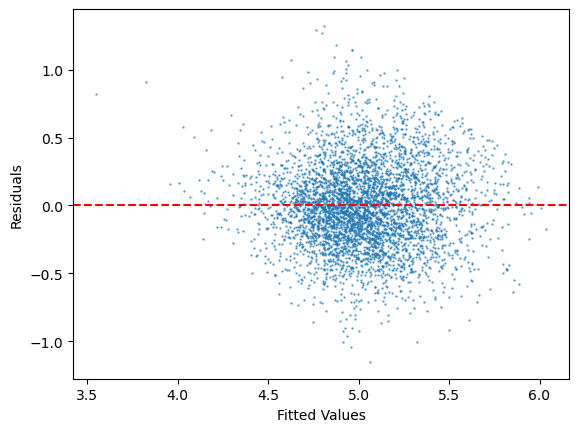

In [760]:
## Assessing linearity: Residual plot
fitted_values_lr = results_lr.fittedvalues
#plt.scatter(fitted_values_lr, np.sqrt(np.abs(residuals_lr/np.std(residuals_lr))), alpha=0.65, s=0.5)
plt.scatter(fitted_values_lr, residuals_lr, alpha=0.65, s=0.5)
plt.axhline(y=0, color='red', label='y=0', linestyle="--", linewidth=1.5)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

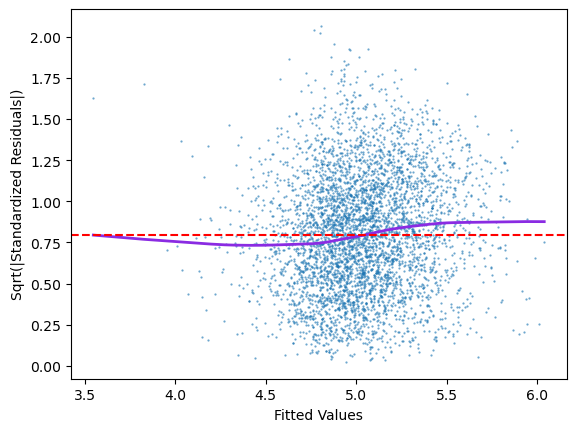

In [761]:
## Assessing homoscedasticity: Residual plot
import seaborn as sns

# Obtain fitted values and residuals from your model
residuals_lr = results_lr.resid

# Standardize residuals
standardized_residuals_lr = residuals_lr / np.std(residuals_lr)

# Compute square root of absolute standardized residuals
sqrt_abs_resid_lr = np.sqrt(np.abs(standardized_residuals_lr))

# Create a DataFrame for plotting
data = pd.DataFrame({
    'Fitted Values': fitted_values_lr,
    'Sqrt Abs Standardized Residuals': sqrt_abs_resid_lr
})

# Create the Scale-Location plot with LOESS line
#plt.figure(figsize=(10, 6))
sns.scatterplot(x='Fitted Values', y='Sqrt Abs Standardized Residuals', data=data, alpha=0.65, s=2, edgecolor='#1f77b4')
sns.regplot(x='Fitted Values', y='Sqrt Abs Standardized Residuals', data=data, scatter=False, 
            lowess=True, color="blueviolet", line_kws=dict(linestyle="-", linewidth=2))
plt.axhline(y=np.sqrt(2/np.pi), color='red', linestyle='--', lw=1.5)
plt.xlabel("Fitted Values")
plt.ylabel("Sqrt(|Standardized Residuals|)")
#plt.title("Scale-Location Plot with LOESS Smoothing")
#plt.legend()
plt.show()

In [762]:
### Establishing study case


## Get the scale and center values for variables
# IQR:
scale_value6 = scaler.scale_[6]
scale_value5 = scaler.scale_[5]
scale_value15 = scaler.scale_[15]
scale_value14 = scaler.scale_[14]
scale_value1 = scaler.scale_[1]
scale_value3 = scaler.scale_[3]
scale_value4 = scaler.scale_[4]

# Median:
center_value6 = scaler.center_[6]
center_value5 = scaler.center_[5]
center_value15 = scaler.center_[15]
center_value14 = scaler.center_[14]
center_value1 = scaler.center_[1]
center_value3 = scaler.center_[3]
center_value4 = scaler.center_[4]

# Defining values for numerical variables (use following chunk as reference for these values)
# This is the median case
var6 = 4.746502003234805 # Median
var5 = 28 # Median
var15 = 59 # Median
var14 = 4.92 # Median
var1 = 4 # Median
var3 = 365 # Median
var4 = 185 # Median

# Transform
transformed_value6 = (var6 - center_value6) / scale_value6
transformed_value5 = (var5 - center_value5) / scale_value5
transformed_value15 = (var15 - center_value15) / scale_value15
transformed_value14 = (var14 - center_value14) / scale_value14
transformed_value1 = (var1 - center_value1) / scale_value1
transformed_value3 = (var3 - center_value3) / scale_value3
transformed_value4 = (var4 - center_value4) / scale_value4

print("transformed_value6:", transformed_value6, "transformed_value5:", transformed_value5, 
     "transformed_value15:", transformed_value15, "transformed_value14:", transformed_value14,
     "transformed_value1:", transformed_value1, "transformed_value3:", transformed_value3, 
      "transformed_value4:", transformed_value4)

transformed_value6: 0.0 transformed_value5: 0.0 transformed_value15: 0.0 transformed_value14: 0.0 transformed_value1: 0.0 transformed_value3: 0.0 transformed_value4: 0.0


In [763]:
columns_to_scale_avg_price

['TWI',
 'accommodates',
 'minimum_nights',
 'maximum_nights',
 'availability_365',
 'amenities_count',
 'Bayesian_avg_H',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_value',
 'Bayes_mean_A',
 'Bayes_mean_R',
 'location_score',
 'Review_count_H',
 'Score_H']

In [764]:
model_lr.formula

'avg_price_log ~ Walkability_num_2 + Walkability_num_3 + Walkability_num_4 + Walkability_num_5 + Bayesian_avg_H + TVs + Bathroom_Amenities + neighbourhood_cleansed_4 + property_type_1 + property_type_4 + bathrooms_2 + bathrooms_3 + bedrooms_2 + beds_2 + beds_3 + amenities_count + Review_count_H + location_score + accommodates + maximum_nights + availability_365'

In [765]:
df_dummies_no_scale["Bayesian_avg_H"].median()

4.746502003234805

In [766]:
## Defining study case
study_case = [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
             0]

In [767]:
new_data = pd.DataFrame({'const':[1],
                         "Walkability_num_2":study_case[0],
                         "Walkability_num_3":study_case[1],
                         "Walkability_num_4":study_case[2],
                         "Walkability_num_5":study_case[3],
                         "Bayesian_avg_H":study_case[4],
                         "TVs":study_case[5],
                         "Bathroom_Amenities":study_case[6],
                         "neighbourhood_cleansed_4":study_case[7],
                         "property_type_1":study_case[8],
                         "property_type_4":study_case[9],
                         "bathrooms_2":study_case[10],
                         "bathrooms_3":study_case[11],
                         "bedrooms_2":study_case[12],
                         "beds_2":study_case[13],
                         "beds_3":study_case[14],
                         "amenities_count":study_case[15],
                         "Review_count_H":study_case[16],
                         "location_score":study_case[17],
                         "accommodates":study_case[18],
                         "maximum_nights":study_case[19],
                         "availability_365":study_case[20],
})

predictions = results_lr.get_prediction(new_data)
df_predictions = predictions.summary_frame()
np.exp(df_predictions)

mean  mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  161.127639  1.01866     155.391956     167.075033     87.612558   

   obs_ci_upper  
0     296.32871

In [768]:
x_walk_score = ["Poor", "Basic", "Average", "High", "Excellent"]
point_estimate_y = [138.619241, 149.553616, 158.72416, 159.525814, 161.127639]

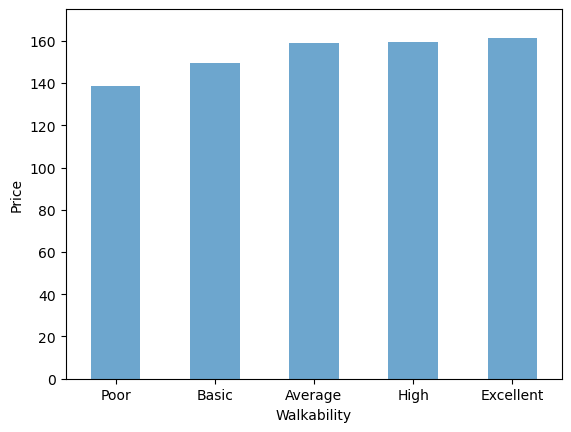

In [769]:
# Create DataFrame
df_point_estimate = pd.DataFrame({
    "Walkability": x_walk_score,
    "point_estimate_y": point_estimate_y,
})

# Plot the DataFrame
ax = df_point_estimate.plot.bar(x="Walkability", y="point_estimate_y", 
                 color=["#1f77b4"], alpha=0.65, 
                 xlabel="Walkability", ylabel="Price", rot=0, legend=False)
ax.set_ylim([0, 175])

# Add labels and title
plt.xlabel("Walkability")
plt.ylabel("Price")
#plt.title("Comparison of Counts by Walkability Levels")

# Show plot
plt.show()

In [770]:
# import the regressor 
from sklearn.tree import DecisionTreeRegressor, export_graphviz  
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [879]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Create a regressor object 
## Using GridSearchCV over min_samples_leaf
regressor = DecisionTreeRegressor(random_state = 42)

# Define X and y data 
df_dummies_dropna = df_dummies_no_scale.dropna(subset="price")
var_considered = ['TVs', 'Wifi', 'Parking',
       'Child_Amenities', 'Bathroom_Amenities', 'Entertainment_Systems',
       'Miscellaneous', 
       'neighbourhood_cleansed_1',
       'neighbourhood_cleansed_2', 'neighbourhood_cleansed_3',
       'neighbourhood_cleansed_4', 'neighbourhood_cleansed_5',
       'property_type_0', 'property_type_1', 'property_type_2',
       'property_type_3', 'property_type_4', 'property_type_5',
     'bathrooms_1', 'bathrooms_2', 'bathrooms_3', 'bedrooms_2', 
                'beds_2', 'beds_3', "TWI", 'amenities_count', 'Review_count_H', 'Bayesian_avg_H', 'location_score', 'accommodates',
       'minimum_nights', 'maximum_nights', 'availability_365',
        'Bayes_mean_A', 'Bayes_mean_R']
#var_considered = ["Walkability_num_2", "Walkability_num_3", "Walkability_num_4", "Walkability_num_5"]

X=df_dummies_dropna[var_considered]

# "Closeness_Centrality_Restaurants", "Closeness_Centrality_Restaurants",
y=df_dummies_dropna.price

# Split the data into training and testing sets (80-20 split)
#X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the grid for min_samples_leaf
#param_grid = {"min_samples_leaf":[2]} # 
param_grid = {
    #'max_depth': np.arange(10, 30), # np.arange(5, 16)
    #'min_samples_split': np.arange(10, 100),
    'min_samples_leaf': np.arange(70, 100) # np.arange(5, 15)
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring="r2")

# Fit the grid search to the data
grid_search.fit(X, y)

# Get the best parameter value
#best_max_depth = grid_search.best_params_["max_depth"]
#best_min_samples_split = grid_search.best_params_["min_samples_split"]
best_min_samples_leaf = grid_search.best_params_["min_samples_leaf"]
#print(f"Best max_depth: {best_max_depth}")
#print(f"Best min_samples_split: {best_min_samples_split}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")

# Fit the final model with the best min_samples_leaf
final_model = DecisionTreeRegressor(min_samples_leaf=best_min_samples_leaf)

final_model.fit(X, y)

# Predict the entire dataset
y_pred = final_model.predict(X)

# Calculate evalation metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

#mse_scores = -cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")
#r2_scores = cross_val_score(final_model, X, y, cv=5, scoring="r2")

# Calculate mean and std of MSE
#mean_mse_scores = np.mean(mse_scores)
#std_mse_scores = np.std(mse_scores)
#mean_r2_scores = np.mean(r2_scores)
#std_r2_scores = np.std(r2_scores)

#print(f"Mean MSE: {mean_mse_scores}")
#print(f"Std MSE: {std_mse_scores}")
#print(f"Mean R^2: {mean_r2_scores}")
#print(f"Std R^2: {std_r2_scores}")

print(f"MSE: {mse}")
print(f"R^2: {r2}")
print(f"Adj R^2: {1-(1-r2)*(len(X)-1)/(len(X)-len(var_considered)-1)}")

Best min_samples_leaf: 71
MSE: 3454.308791137325
R^2: 0.4335439107566349
Adj R^2: 0.4291371618961064


In [880]:
print("mean_test_score:" , grid_search.cv_results_["mean_test_score"][np.argmin(grid_search.cv_results_["rank_test_score"])])
print("std_test_score:" , grid_search.cv_results_["std_test_score"][np.argmin(grid_search.cv_results_["rank_test_score"])])
print("rank_test_score:" , grid_search.cv_results_["rank_test_score"][np.argmin(grid_search.cv_results_["rank_test_score"])])

mean_test_score: 0.34670350227121655
std_test_score: 0.04180836939458592
rank_test_score: 1


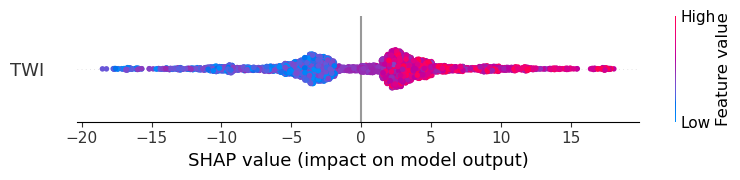

In [858]:
import shap
explainer = shap.Explainer(final_model)
shap_values = explainer.shap_values(X)
#shap.summary_plot(shap_values, X, max_display=50)
shap.summary_plot(shap_values[:, 24:25], X.iloc[:, 24:25], max_display=50)

In [ ]:
# Predict on the testing data (if train_test_split in the previous chunk is uncommented)
#y_pred = final_model.predict(X_test)

# Calculate evaluation metrics on the testing data
#mse = mean_squared_error(y_test, y_pred)
#r2 = r2_score(y_test, y_pred)
#adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - len(var_considered) - 1)

#print(f"MSE: {mse}")
#print(f"R^2: {r2}")
#print(f"Adjusted R^2: {adj_r2}")

In [194]:
# Feature importance
j = 0
var_considered_filtered = []
for feature in var_considered:
    print(feature, final_model.feature_importances_[j])
    
    if final_model.feature_importances_[j] > 0:
        var_considered_filtered.append(feature)
        
    j += 1

TVs 0.01061473095538805
Bathroom_Amenities 0.008958542853985181
neighbourhood_cleansed_4 0.011904704106682387
property_type_1 0.02528605166471776
property_type_3 0.0
property_type_4 0.0
property_type_6 0.0
property_type_9 0.0
property_type_15 0.0
property_type_18 0.0
property_type_19 0.0
property_type_25 0.0
property_type_26 0.0
property_type_28 0.0
bathrooms_2 0.07566385801826563
bathrooms_3 0.035225511491946936
bedrooms_2 0.04745713777605127
beds_2 0.0
beds_3 0.002360488825260008
Walkability_num_1 0.008124252558595332
Walkability_num_2 0.004864467455684265
Walkability_num_3 0.008399083936874425
Walkability_num_4 0.0018233424469933706
Walkability_num_5 0.0
Review_count_H 0.07065915332486061
Bayesian_avg_H 0.08246510876289823
location_score 0.11231947874595577
accommodates 0.39903994471306853
maximum_nights 0.018077180551792117
availability_365 0.07675696181098018


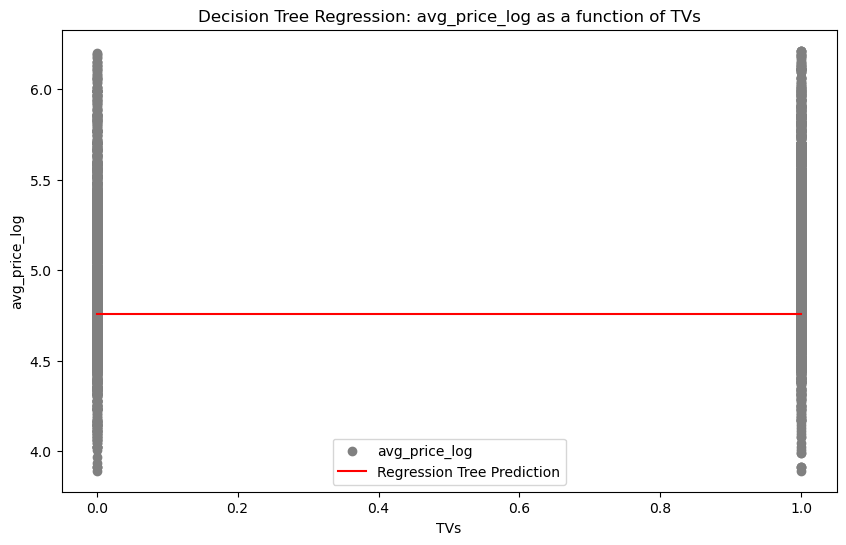

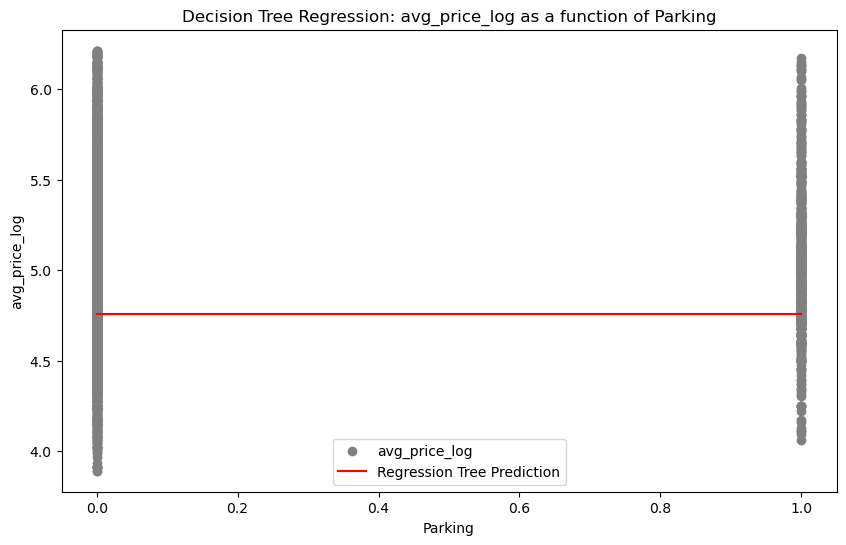

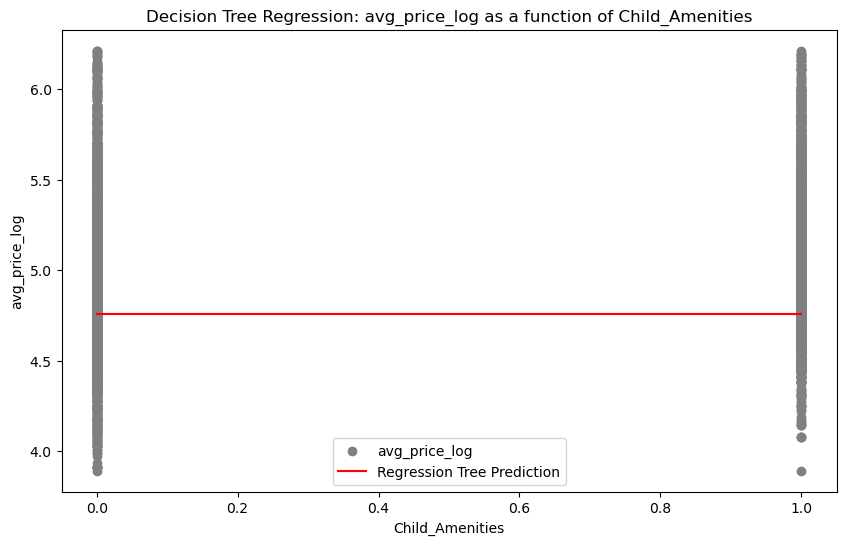

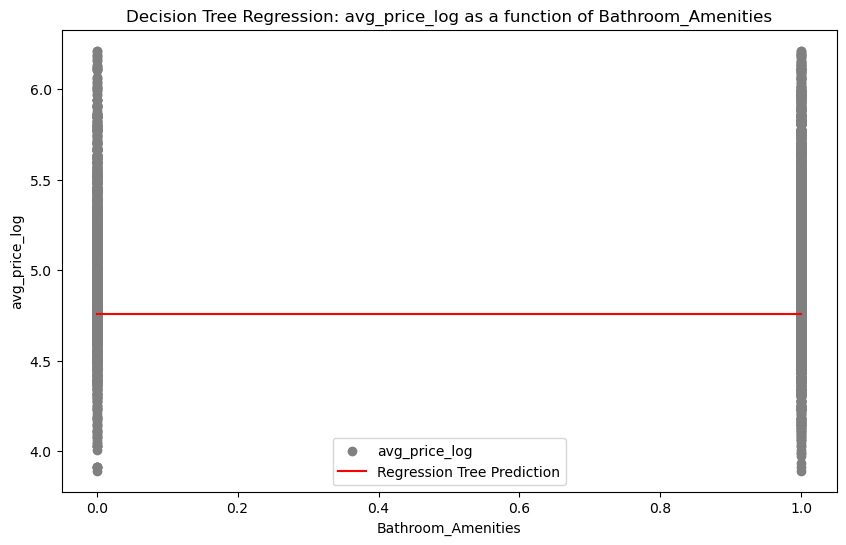

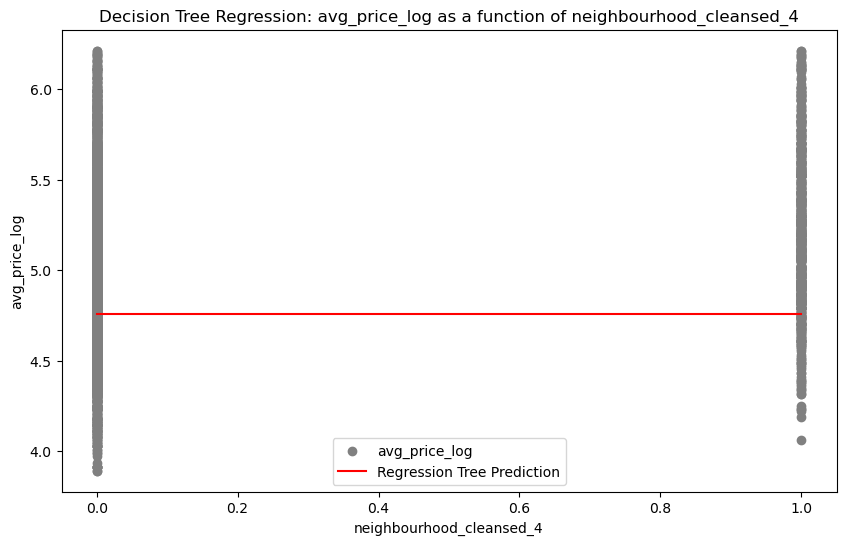

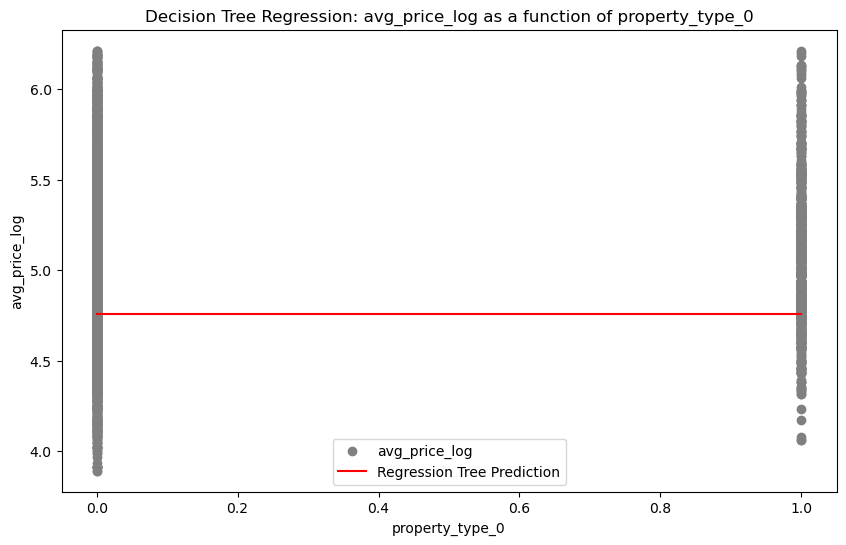

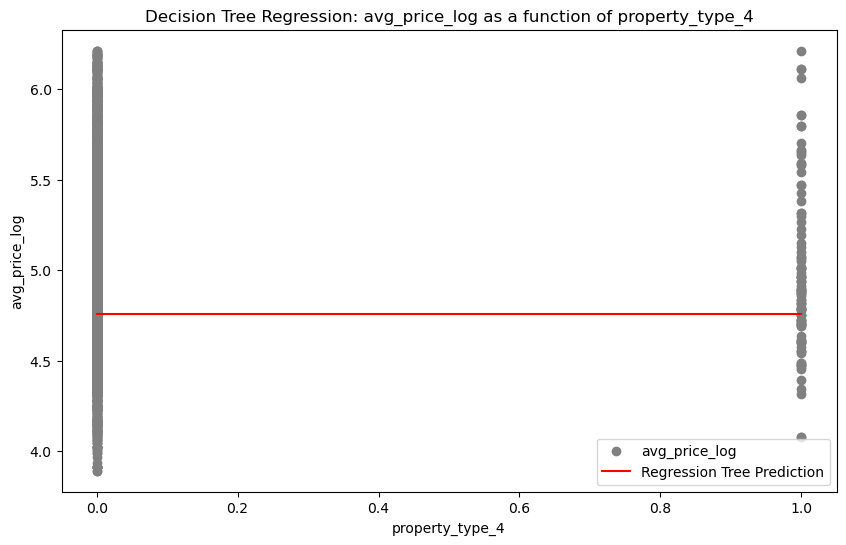

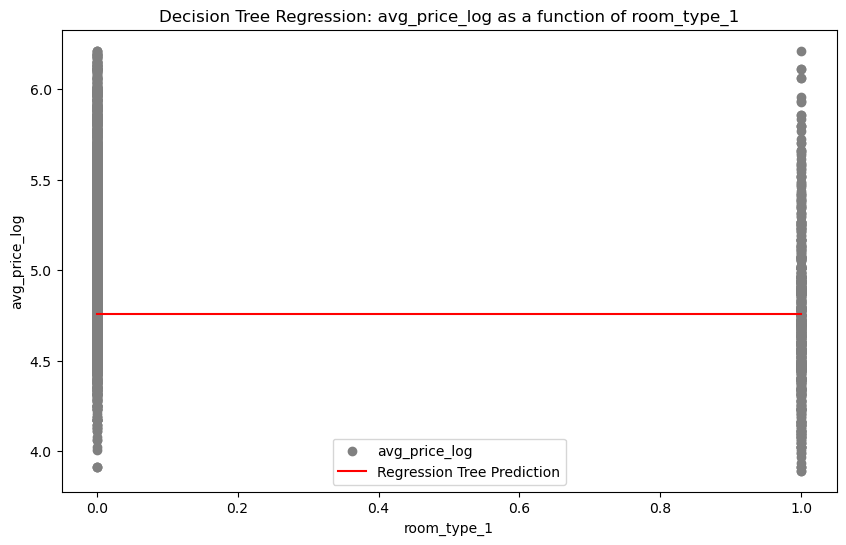

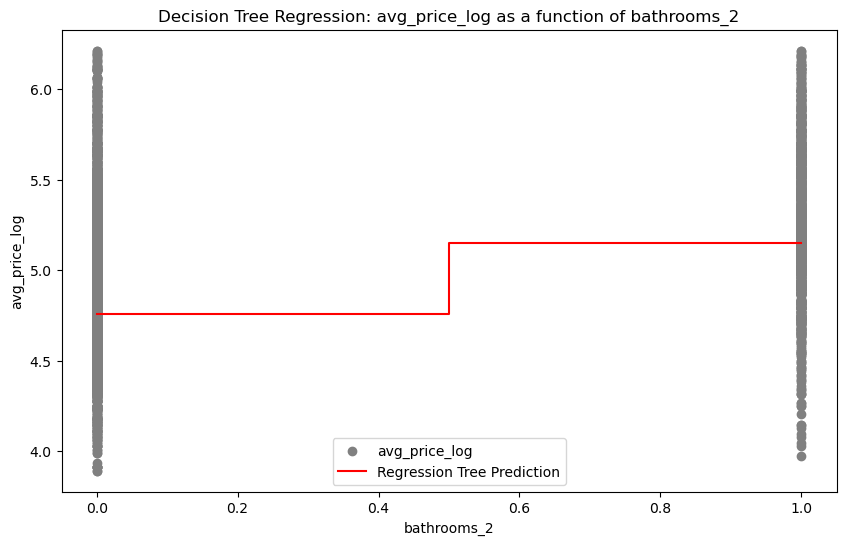

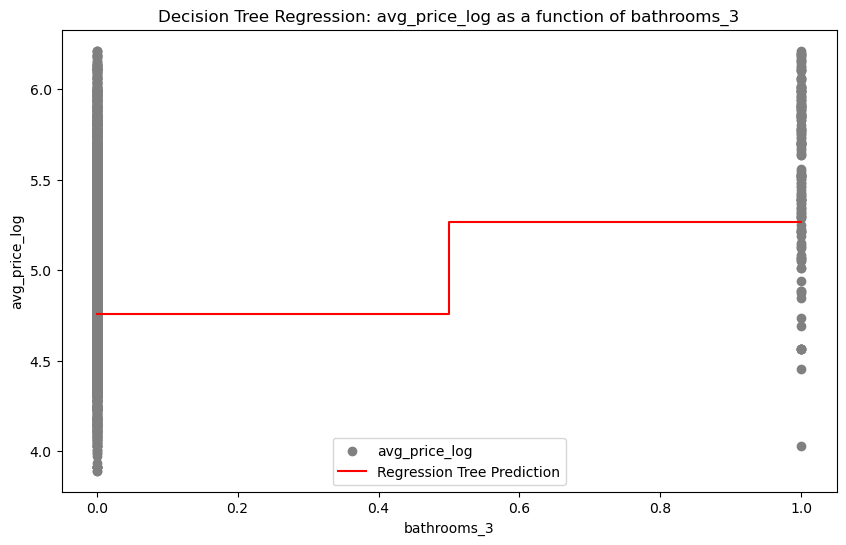

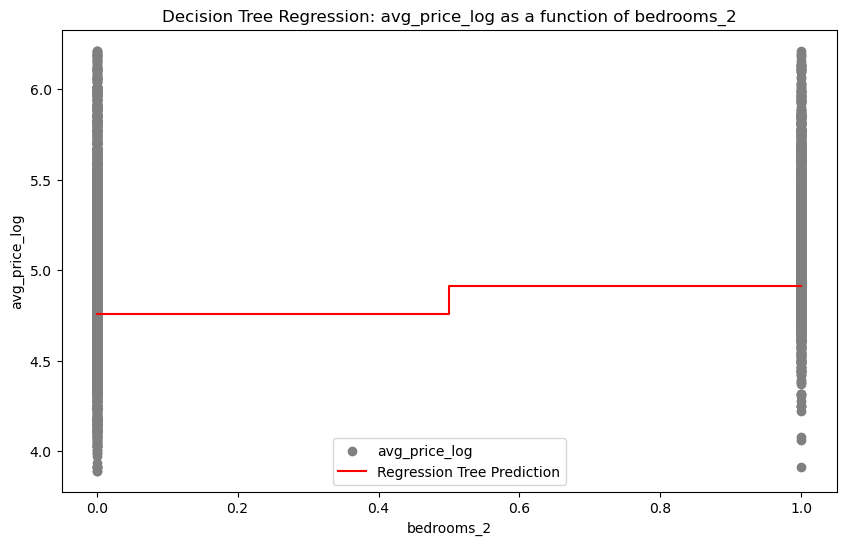

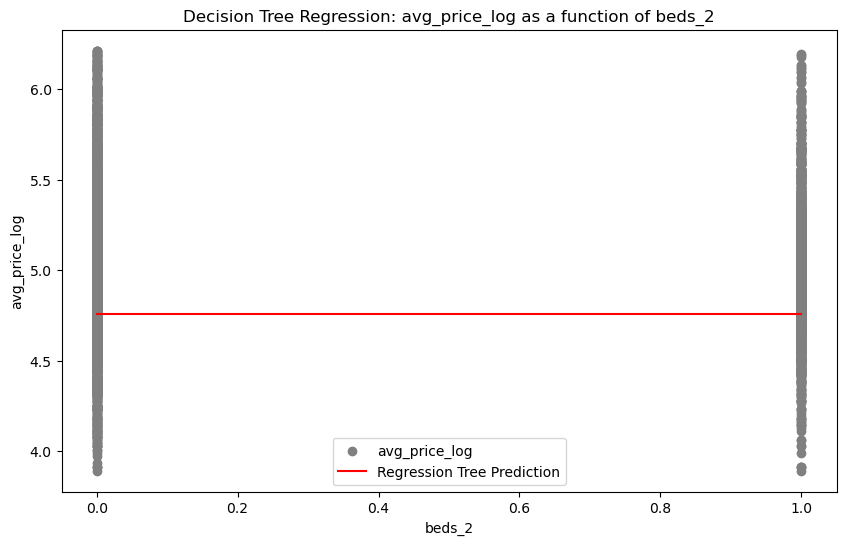

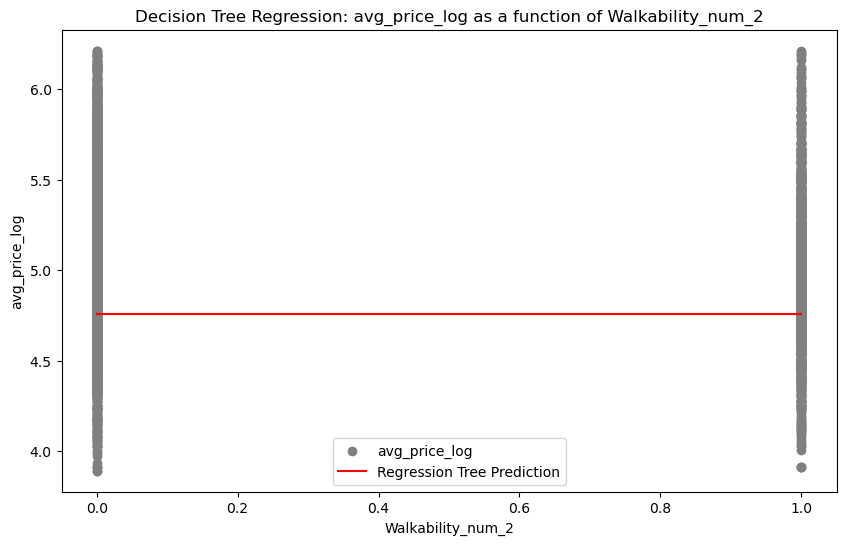

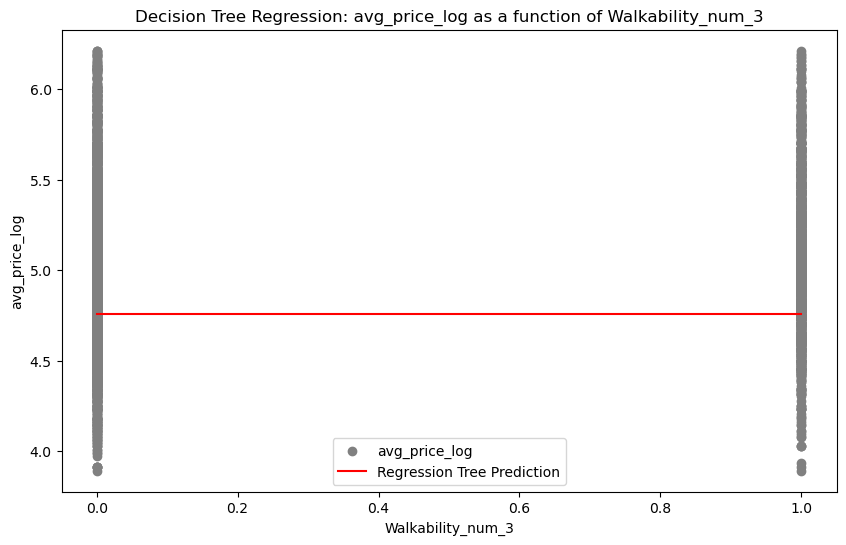

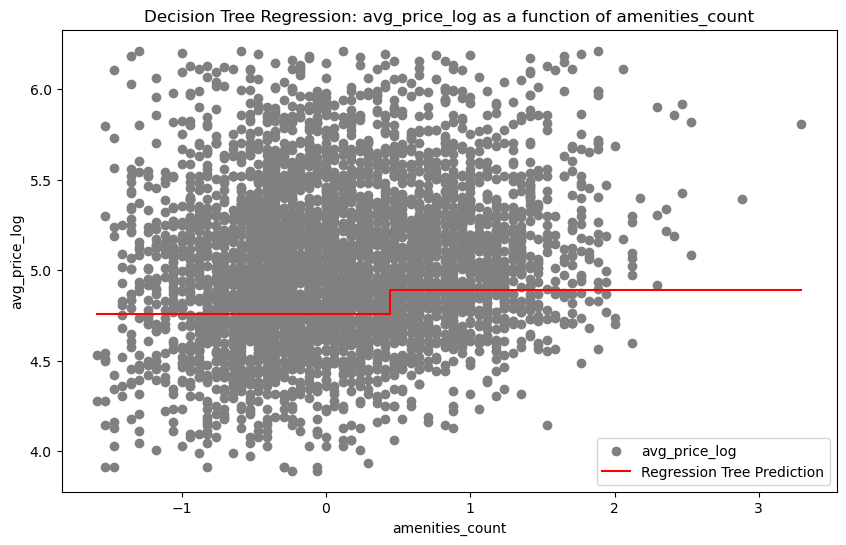

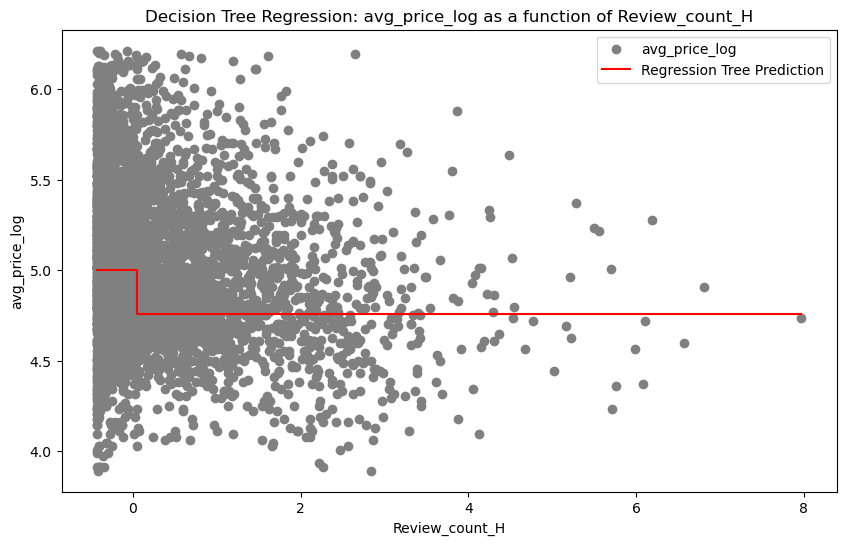

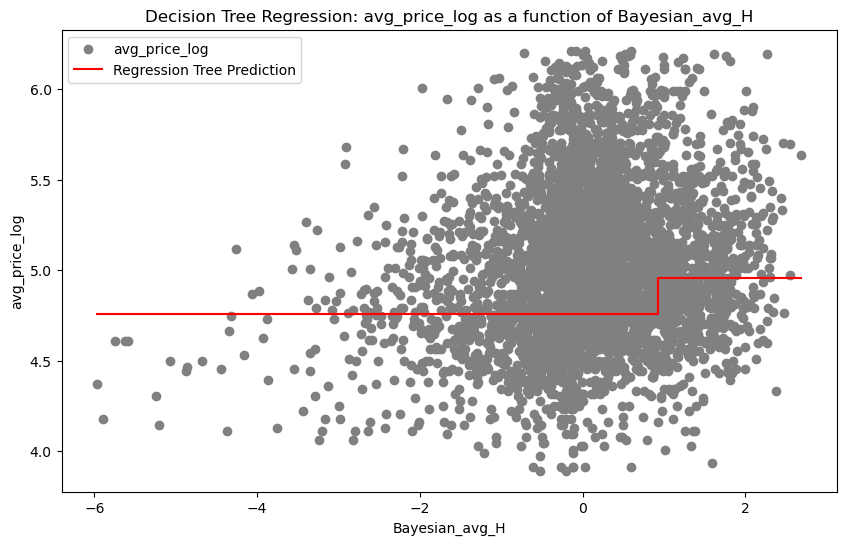

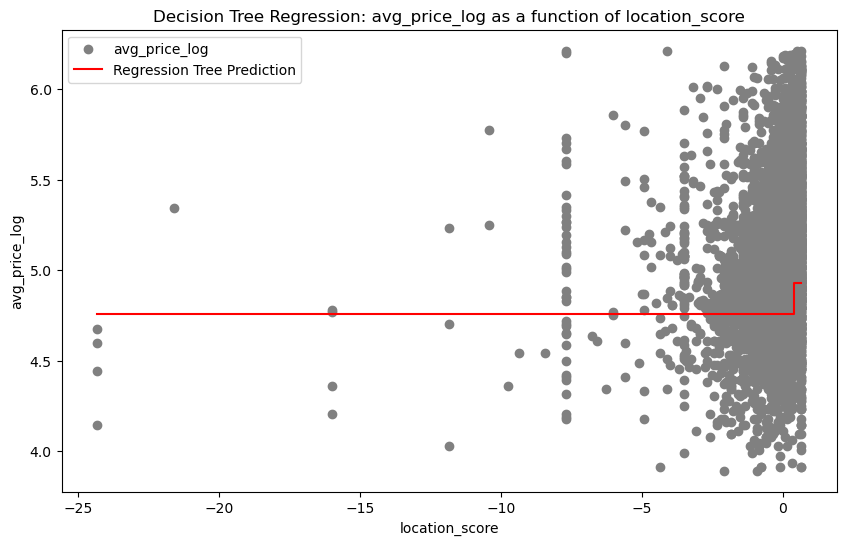

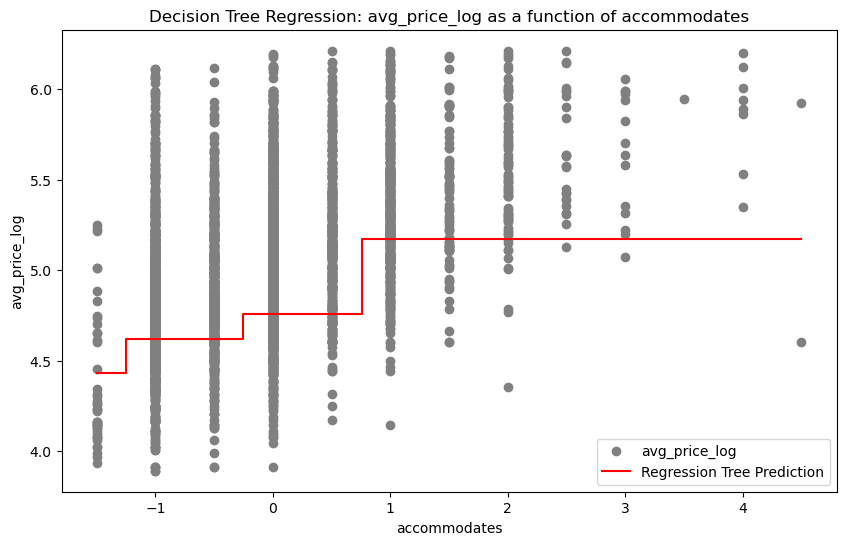

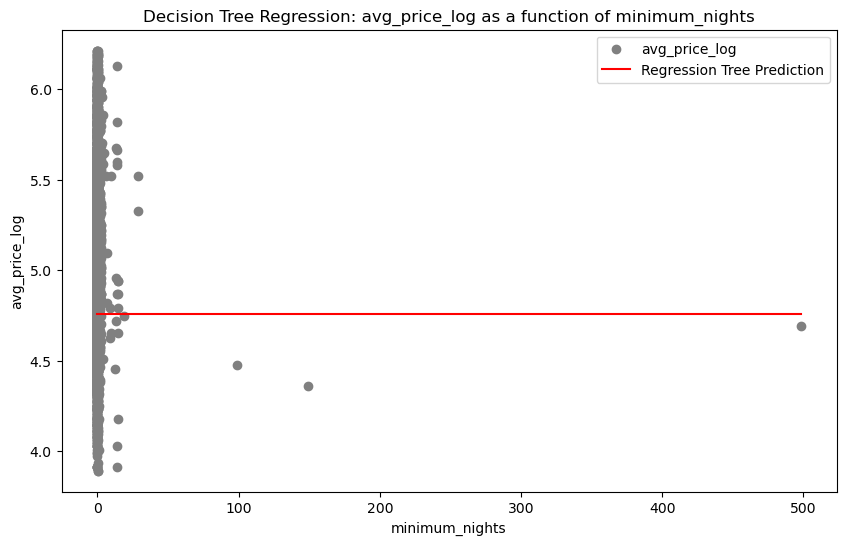

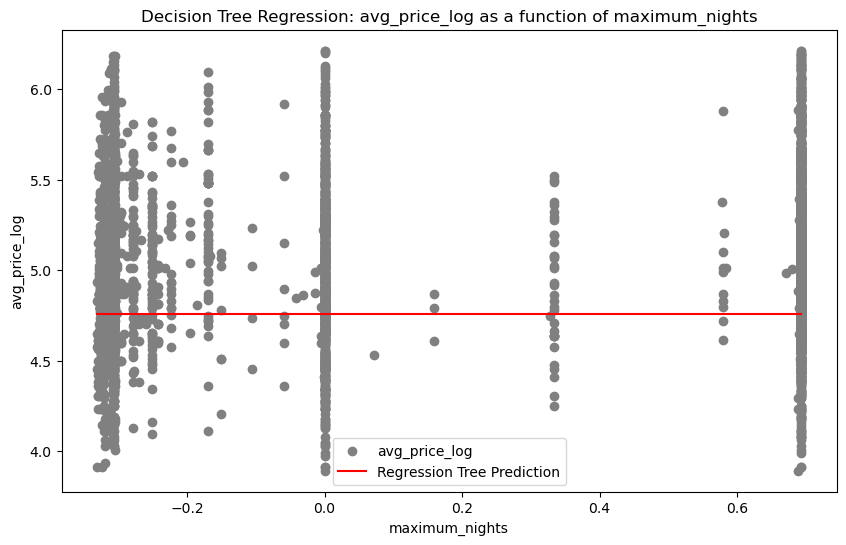

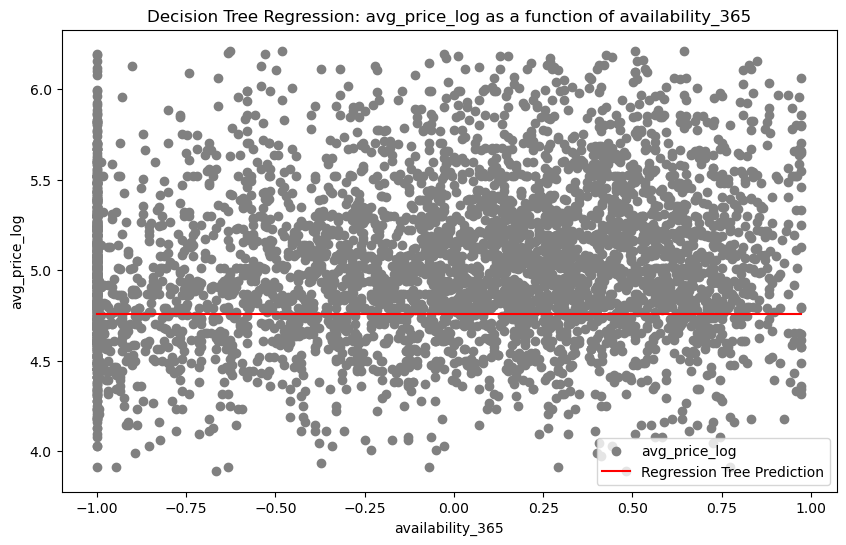

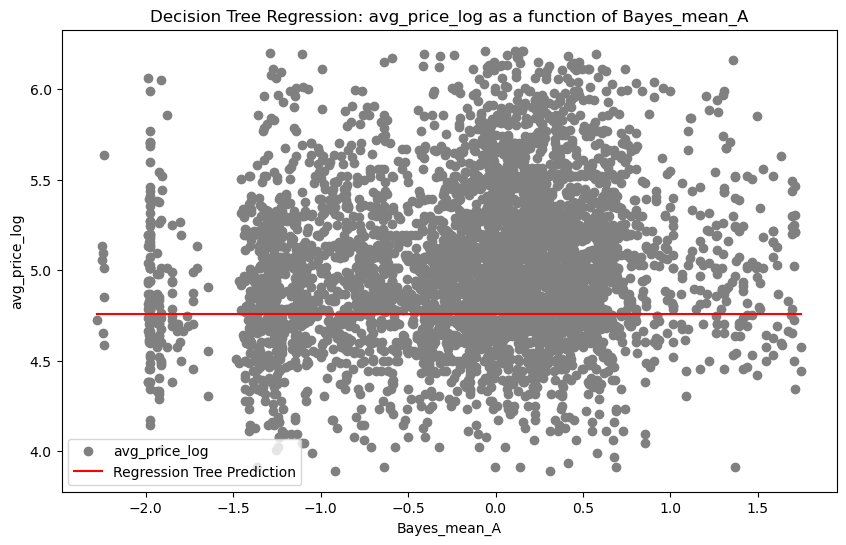

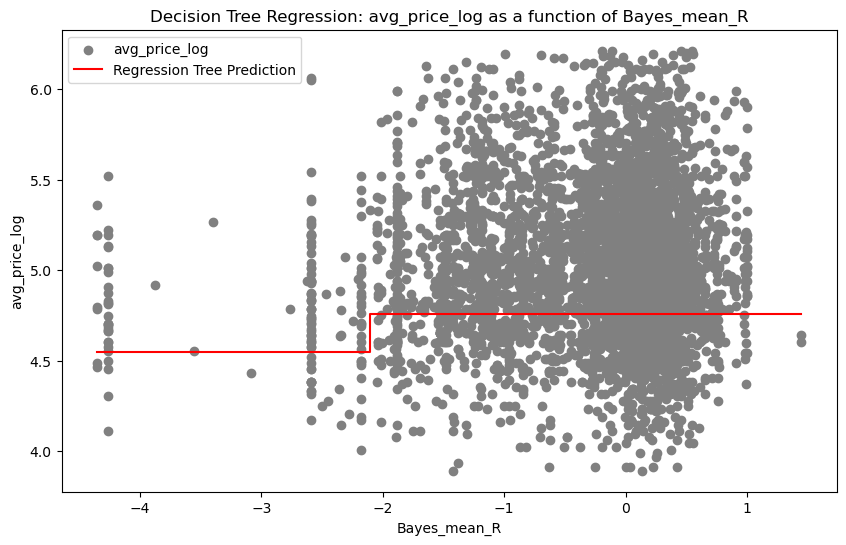

In [136]:
# Function to plot the decision tree predictions for a given feature
def plot_feature_decision_boundary(feature_name, output_label):
    plt.figure(figsize=(10, 6))

    # Scatter plot of the feature vs avg_price
    plt.scatter(X[feature_name], y, color='gray', label=output_label)

    # Create a grid of feature values
    feature_values = np.linspace(X[feature_name].min(), X[feature_name].max(), 500)

    # Create a grid of input features
    X_grid = pd.DataFrame(np.tile(X.mean().values, (500, 1)), columns=X.columns)
    X_grid[feature_name] = feature_values

    # Predict avg_price for the grid values
    y_grid_pred = final_model.predict(X_grid)

    # Plot the decision boundary
    plt.step(feature_values, y_grid_pred, color='red', label='Regression Tree Prediction', where='mid')

    plt.xlabel(feature_name)
    plt.ylabel(output_label)
    plt.title(f"Decision Tree Regression: {output_label} as a function of {feature_name}")
    plt.legend()
    plt.show()

# Plot decision boundaries for each feature
for feature in var_considered_filtered:
    plot_feature_decision_boundary(feature, "avg_price_log")

In [ ]:
# export the decision tree to a tree.dot file 
# for visualizing the plot easily anywhere 
# https://dreampuf.github.io/GraphvizOnline/#digraph%20Tree%20%7B%0D%0Anode%20%5Bshape%3Dbox%2C%20fontname%3D%22helvetica%22%5D%20%3B%0D%0Aedge%20%5Bfontname%3D%22helvetica%22%5D%20%3B%0D%0A0%20%5Blabel%3D%22TWI%20%3C%3D%208.771%5Cnsquared_error%20%3D%20454.476%5Cnsamples%20%3D%2018%5Cnvalue%20%3D%20117.694%22%5D%20%3B%0D%0A1%20%5Blabel%3D%22Hotel_class_23%20%3C%3D%200.5%5Cnsquared_error%20%3D%2062.776%5Cnsamples%20%3D%207%5Cnvalue%20%3D%2098.286%22%5D%20%3B%0D%0A0%20-%3E%201%20%5Blabeldistance%3D2.5%2C%20labelangle%3D45%2C%20headlabel%3D%22True%22%5D%20%3B%0D%0A2%20%5Blabel%3D%22TWI%20%3C%3D%200.954%5Cnsquared_error%20%3D%2019.297%5Cnsamples%20%3D%204%5Cnvalue%20%3D%20104.375%22%5D%20%3B%0D%0A1%20-%3E%202%20%3B%0D%0A3%20%5Blabel%3D%22squared_error%20%3D%2033.062%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20102.75%22%5D%20%3B%0D%0A2%20-%3E%203%20%3B%0D%0A4%20%5Blabel%3D%22squared_error%20%3D%200.25%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20106.0%22%5D%20%3B%0D%0A2%20-%3E%204%20%3B%0D%0A5%20%5Blabel%3D%22squared_error%20%3D%205.389%5Cnsamples%20%3D%203%5Cnvalue%20%3D%2090.167%22%5D%20%3B%0D%0A1%20-%3E%205%20%3B%0D%0A6%20%5Blabel%3D%22Hotel_class_23%20%3C%3D%200.5%5Cnsquared_error%20%3D%20311.475%5Cnsamples%20%3D%2011%5Cnvalue%20%3D%20130.045%22%5D%20%3B%0D%0A0%20-%3E%206%20%5Blabeldistance%3D2.5%2C%20labelangle%3D-45%2C%20headlabel%3D%22False%22%5D%20%3B%0D%0A7%20%5Blabel%3D%22squared_error%20%3D%20269.389%5Cnsamples%20%3D%203%5Cnvalue%20%3D%20150.333%22%5D%20%3B%0D%0A6%20-%3E%207%20%3B%0D%0A8%20%5Blabel%3D%22TWI%20%3C%3D%2059.023%5Cnsquared_error%20%3D%20115.027%5Cnsamples%20%3D%208%5Cnvalue%20%3D%20122.438%22%5D%20%3B%0D%0A6%20-%3E%208%20%3B%0D%0A9%20%5Blabel%3D%22TWI%20%3C%3D%2039.613%5Cnsquared_error%20%3D%204.922%5Cnsamples%20%3D%204%5Cnvalue%20%3D%20129.625%22%5D%20%3B%0D%0A8%20-%3E%209%20%3B%0D%0A10%20%5Blabel%3D%22squared_error%20%3D%200.562%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20129.25%22%5D%20%3B%0D%0A9%20-%3E%2010%20%3B%0D%0A11%20%5Blabel%3D%22squared_error%20%3D%209.0%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20130.0%22%5D%20%3B%0D%0A9%20-%3E%2011%20%3B%0D%0A12%20%5Blabel%3D%22TWI%20%3C%3D%2071.824%5Cnsquared_error%20%3D%20121.812%5Cnsamples%20%3D%204%5Cnvalue%20%3D%20115.25%22%5D%20%3B%0D%0A8%20-%3E%2012%20%3B%0D%0A13%20%5Blabel%3D%22squared_error%20%3D%20240.25%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20114.5%22%5D%20%3B%0D%0A12%20-%3E%2013%20%3B%0D%0A14%20%5Blabel%3D%22squared_error%20%3D%202.25%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20116.0%22%5D%20%3B%0D%0A12%20-%3E%2014%20%3B%0D%0A%7D
export_graphviz(final_model, out_file ='tree_Venezia_avg_price_log_airbnb.dot', 
               feature_names = var_considered)  

#### GAM

In [110]:
GAM_fit = True
if GAM_fit:
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

GAM R²: 0.4610070657546693


C:\Users\mario\AppData\Local\Temp\ipykernel_3892\374020439.py:56: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


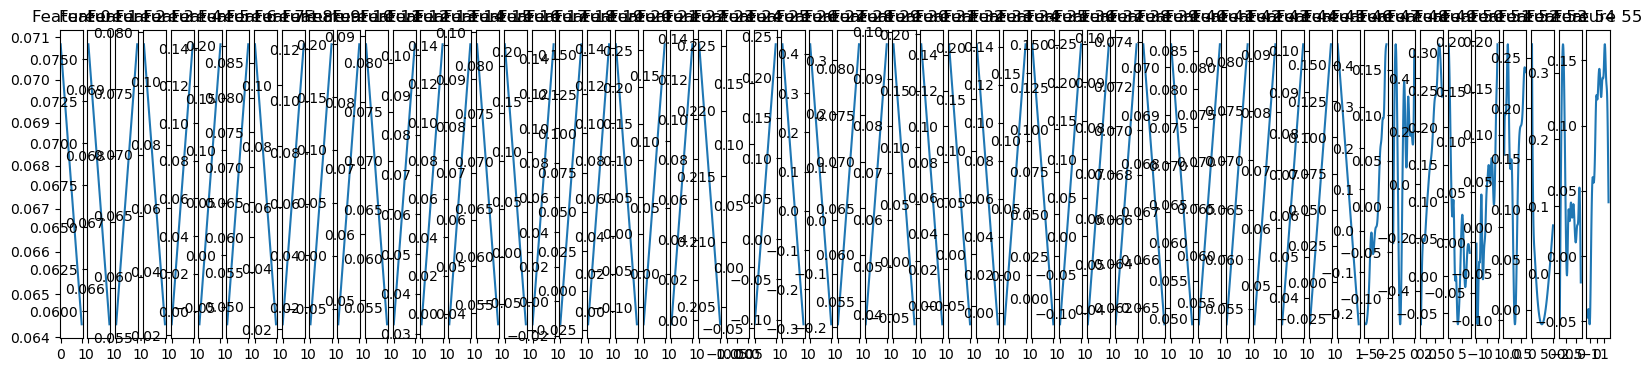

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    143.5126
Link Function:                     IdentityLink Log Likelihood:                                -14043.9329
Number of Samples:                         3628 AIC:                                            28376.8909
                                                AICc:                                           28388.9676
                                                GCV:                                                0.0963
                                                Scale:                                              0.0895
                                                Pseudo R-Squared:                                   0.5174
Feature Function                  Lam

C:\Users\mario\AppData\Local\Temp\ipykernel_3892\374020439.py:58: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [111]:
# Install pyGAM
# !pip install pygam
if GAM_fit:
    from pygam import LinearGAM, s, f, l

    X=X[['neighbourhood_cleansed_0',
                   'neighbourhood_cleansed_1', 'neighbourhood_cleansed_2',
                   'neighbourhood_cleansed_3', 'neighbourhood_cleansed_4',  'property_type_3', 'property_type_4',
                   'property_type_5', 'property_type_6', 'property_type_7',
                   'property_type_8', 'property_type_9', 'property_type_10',
                   'property_type_11', 'property_type_12', 'property_type_13',
                   'property_type_14', 'property_type_15', 'property_type_16',
                   'property_type_17', 'property_type_18', 'property_type_19',
                   'property_type_20', 'property_type_21', 'property_type_22',
                   'property_type_23', 'property_type_24', 'property_type_25',
                   'property_type_26', 'property_type_27', 'property_type_28',
                   'property_type_29', 'property_type_30', 'property_type_31',
                   'property_type_32', 'room_type_1', "bathrooms_2", 
                      "bathrooms_3", "bedrooms_2",  
                      "beds_2", "beds_3",  'TVs', 'Parking',
       'Child_Amenities', 'Bathroom_Amenities', 'Entertainment_Systems', 'Miscellaneous', "Bayesian_avg_H", 
           "location_score", "accommodates", "Review_count_H", "availability_365", 
                   "maximum_nights", "minimum_nights", 
                   "Bayes_mean_R", "TWI"]] #, "Bayesian_avg_mean_A_Z"
    X_test=X_test[['neighbourhood_cleansed_0',
                   'neighbourhood_cleansed_1', 'neighbourhood_cleansed_2',
                   'neighbourhood_cleansed_3', 'neighbourhood_cleansed_4',  'property_type_3', 'property_type_4',
                   'property_type_5', 'property_type_6', 'property_type_7',
                   'property_type_8', 'property_type_9', 'property_type_10',
                   'property_type_11', 'property_type_12', 'property_type_13',
                   'property_type_14', 'property_type_15', 'property_type_16',
                   'property_type_17', 'property_type_18', 'property_type_19',
                   'property_type_20', 'property_type_21', 'property_type_22',
                   'property_type_23', 'property_type_24', 'property_type_25',
                   'property_type_26', 'property_type_27', 'property_type_28',
                   'property_type_29', 'property_type_30', 'property_type_31',
                   'property_type_32', 'room_type_1', "bathrooms_2", 
                      "bathrooms_3", "bedrooms_2",  
                      "beds_2", "beds_3",  'TVs', 'Parking',
       'Child_Amenities', 'Bathroom_Amenities', 'Entertainment_Systems', 'Miscellaneous', "Bayesian_avg_H", 
           "location_score", "accommodates", "Review_count_H", "availability_365", 
                   "maximum_nights", "minimum_nights", 
                   "Bayes_mean_R", "TWI"]] #, "Bayesian_avg_mean_A_Z"
    gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + s(24) + s(25) + s(26) + s(27) + s(28) + s(29) + s(30) + s(31) + s(32) + s(33) + s(34) + s(35) + s(36) + s(37) + s(38) + s(39) + s(40) + s(41) + s(42) + s(43) + s(44) + s(45) + s(46) + s(47) + s(48) + s(49) + s(50) + s(51) + s(52) + s(53) + s(54) + s(55)).fit(X, y)

    y_pred_gam = gam.predict(X_test)
    r2_gam = r2_score(y_test, y_pred_gam)
    print(f"GAM R²: {r2_gam}")

    # Plot the partial dependence
    fig, axs = plt.subplots(1, X.shape[1], figsize=(20, 4))
    for i, ax in enumerate(axs):
        XX = gam.generate_X_grid(term=i)
        ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
        ax.set_title(f'Feature {i}')
    plt.tight_layout()
    plt.show()
    print(gam.summary())

#### Gradient Boosting

In [ ]:
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Define X and y data 
df_dummies_dropna = df_dummies.dropna(subset=["avg_price_log"])

var_considered = ['Bayesian_avg_H', 'location_score', 'accommodates',
       'minimum_nights', 'maximum_nights', 'availability_365',
       'TVs', 'Parking',
       'Child_Amenities', 'Bathroom_Amenities', 'Entertainment_Systems',
       'Miscellaneous', 'Bayes_mean_R', 'TWI',
       'neighbourhood_cleansed_0', 'neighbourhood_cleansed_1',
       'neighbourhood_cleansed_2', 'neighbourhood_cleansed_3',
       'neighbourhood_cleansed_4',
       'property_type_0', 'property_type_1',
       'property_type_3', 'property_type_4', 'property_type_5',
       'property_type_6', 'property_type_7', 'property_type_8',
       'property_type_9', 'property_type_10', 'property_type_11',
       'property_type_12', 'property_type_13', 'property_type_14',
       'property_type_15', 'property_type_16', 'property_type_17',
       'property_type_18', 'property_type_19', 'property_type_20',
       'property_type_21', 'property_type_22', 'property_type_23',
       'property_type_24', 'property_type_25', 'property_type_26',
       'property_type_27', 'property_type_28', 'property_type_29',
       'property_type_30', 'property_type_31', 'property_type_32', 
        'bathrooms_2', 'bathrooms_3', 'bedrooms_2', 'beds_2', 'beds_3']

X = df_dummies_dropna[var_considered]
y = df_dummies_dropna["avg_price_log"]

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the grid for Gradient Boosting parameters
param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': np.arange(3, 15),
    'min_samples_leaf': np.arange(3, 15)
}

# Create a Gradient Boosting regressor object
gb_regressor = GradientBoostingRegressor(random_state=42)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error")

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameter values
best_n_estimators = grid_search.best_params_["n_estimators"]
best_learning_rate = grid_search.best_params_["learning_rate"]
best_max_depth = grid_search.best_params_["max_depth"]
best_min_samples_leaf = grid_search.best_params_["min_samples_leaf"]

print(f"Best n_estimators: {best_n_estimators}")
print(f"Best learning_rate: {best_learning_rate}")
print(f"Best max_depth: {best_max_depth}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")

# Fit the final model with the best parameters
final_model = GradientBoostingRegressor(
    n_estimators=best_n_estimators, 
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    random_state=42
)
final_model.fit(X_train, y_train)

# Predict the test set
y_pred = final_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - len(var_considered) - 1)

print(f"MSE: {mse}")
print(f"R^2: {r2}")
print(f"Adj R^2: {adj_r2}")

#### Isochrone maps

C:\Users\mario\AppData\Local\Temp\ipykernel_8896\280278442.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_var)


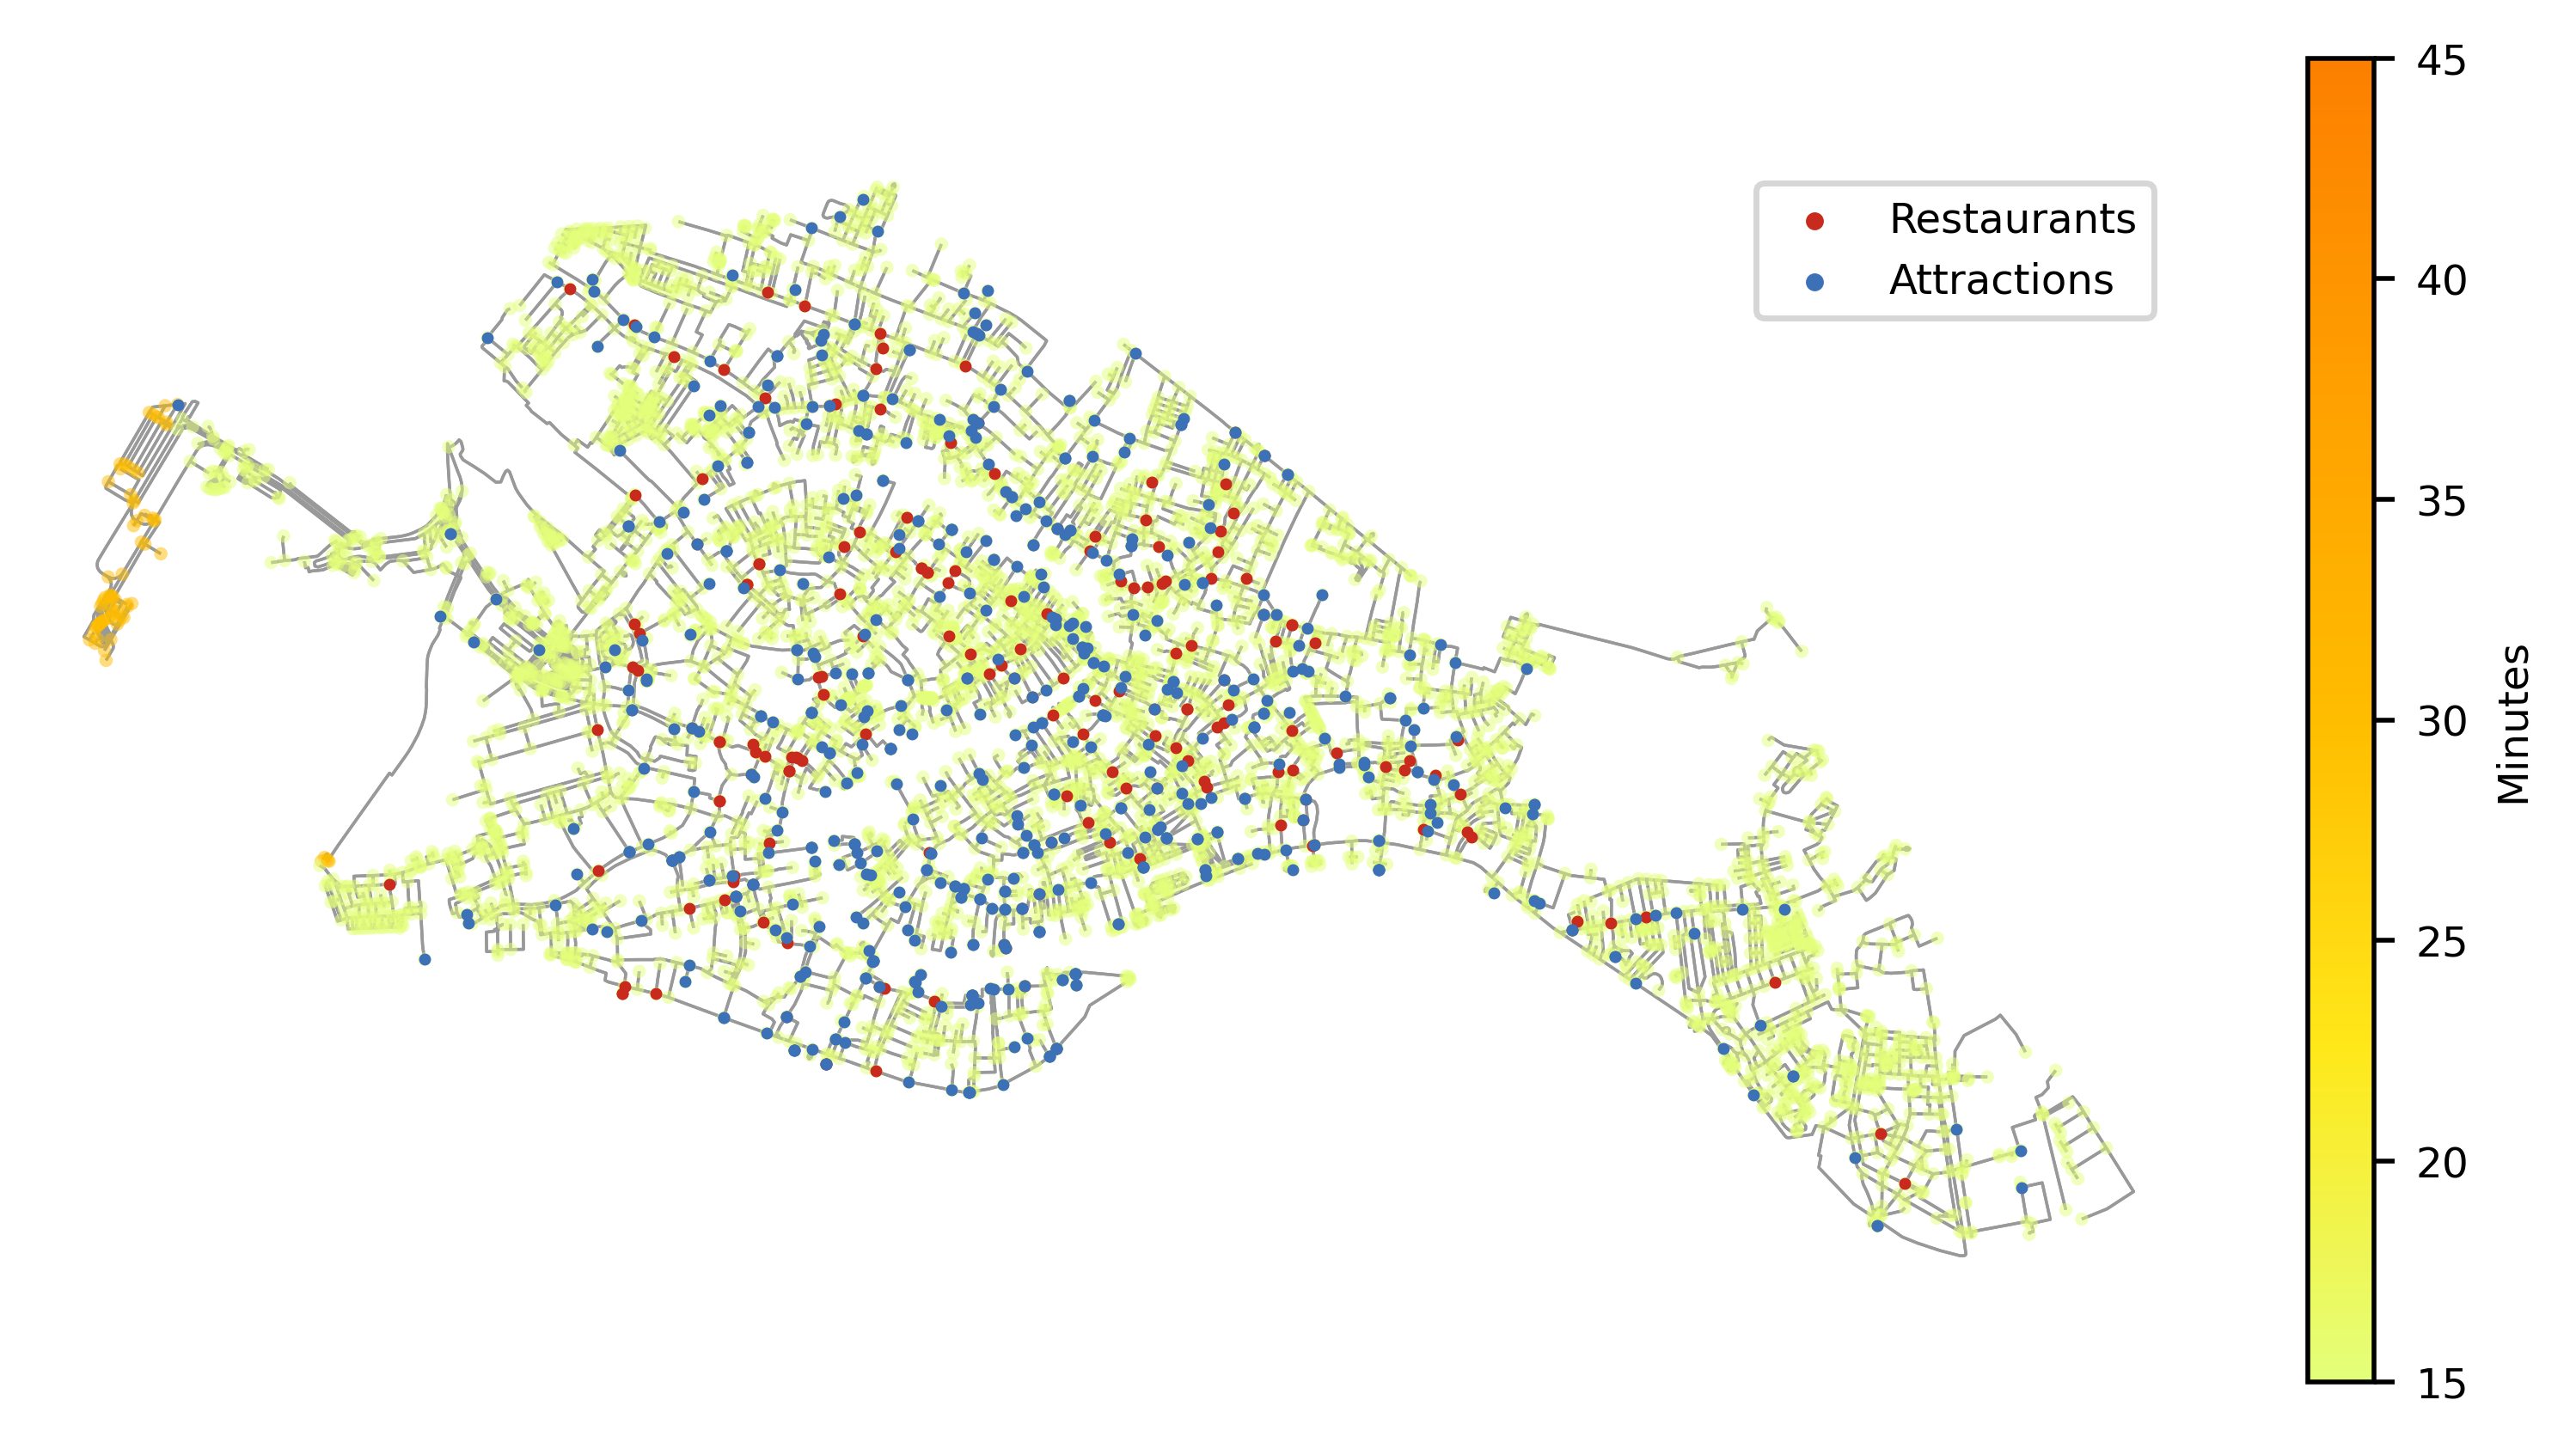

In [64]:
G2 = G
trip_times = [X_minutes, 30, 45]  # in minutes

cmap_var = "Wistia"#"Greens" #"Wistia"  #"summer" #
# add an edge attribute for time in minutes required to traverse each edge
for _, _, _, data in G2.edges(data=True, keys=True):
    data["time"] = data["length"] / speed_mm
    
# get one color for each isochrone (r, g, b, alpha)
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap=cmap_var, start=1, stop=0, alpha = 1)
# color the nodes according to isochrone then plot the street network
node_colors = {}
node_time = {}

for center_node in hotels_df["id_nearest_node_H"]:
    for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
        subgraph = nx.ego_graph(G2, center_node, radius=trip_time, distance="time")
        for node in subgraph.nodes():
            if node in node_time and trip_time < node_time[node]:
                node_colors[node] = color
                node_time[node] = trip_time
            elif node not in node_time:
                node_colors[node] = color
                node_time[node] = trip_time
nc = [node_colors[node] if node in node_colors else "none" for node in G2.nodes()]
ns = [5 if node in node_colors else 0 for node in G2.nodes()]
mpl.rcParams['figure.dpi'] = 500

cmap = plt.cm.get_cmap(cmap_var)
norm = plt.Normalize(vmin=np.min(trip_times), vmax=np.max(trip_times))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])


fig, ax = ox.plot_graph(G2, node_color=nc, node_size=ns, node_alpha=0.5,
                        edge_linewidth=0.5, edge_color="#999999", bgcolor="white", 
                        show=False, close=False)

    
# Adding Hotels, Restaurants, Attractions, and Tram/Metro stations
#ax.scatter(hotels_df["x_nearest_node_H"].values, hotels_df["y_nearest_node_H"].values, 
#           color='green', s=10, zorder=2, marker = 'o', label="Hotels")
ax.scatter(top_k_R_df["x_nearest_node_R"].values, top_k_R_df["y_nearest_node_R"].values, 
           color='#c82a1d', s=1, zorder=2, marker = 'o', label="Restaurants")
ax.scatter(top_k_A_df["x_nearest_node_A"].values, top_k_A_df["y_nearest_node_A"].values, 
           color='#3c71b7', s=1, zorder=2, marker = 'o', label="Attractions")
ax.legend(loc='upper right', fontsize = "x-small", markerscale = 2)

cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', shrink = 0.5)
cb.ax.tick_params(labelsize=7)
cb.set_label('Minutes', fontsize = 7)

plt.show()

#### For plotting some auxiliary images

In [ ]:
import osmnx as ox
import matplotlib as mpl


location_point = (45.3986490196774, 11.874350466689211)

place_name = "Padova, Italy"

mpl.rcParams['figure.dpi'] = 500
# create network from point, inside bounding box of N, S, E, W each 750m from point
#plt.title("Padova: All street network'")
#G_walk = ox.graph_from_point(location_point, dist=dist, dist_type="bbox", network_type="walk", simplify = False)

#Drive network
G_walk = ox.graph_from_point(location_point, dist=300, dist_type="bbox", network_type="walk", simplify = False)
#G_drive = ox.graph_from_place(place_name, network_type="walk", retain_all=True, simplify = False)

fig, ax = ox.plot_graph(G_walk, node_color="white", edge_color="gray", node_edgecolor = "blue",
                        edge_linewidth=1, node_size=1.5, bgcolor="white", 
                        figsize=(6, 6)) 

In [ ]:
plt.style.use('default')
xx = np.linspace(0, 10000, 10000)
zz_avg = 500
yy = xx/(xx + zz_avg)
fig,ax=plt.subplots(1,1)
ax.plot(xx, yy)
ax.plot(xx, (1-yy))
ax.set_ylabel("Weight value")
ax.set_xlabel("Number of reviews")
ax.legend(["POI review score weight", "Average of review scores weight"])
ax.axvline(x=zz_avg, ymax=0.5, linestyle = "--", color="gray")
ax.axhline(y=1, linestyle = "dotted", color="gray")
ax.axhline(y=0, linestyle = "dotted", color="gray")
ax.set_xticks([0, 500, 2000, 4000, 6000, 8000, 10000])

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(xx, yy*4.5 + (1-yy)*3)
ax.plot(xx, yy*3.5 + (1-yy)*3)
ax.axhline(y=4.5, linestyle = "dotted", color="#1f77b4") 
ax.axhline(y=3.5, linestyle = "dotted", color="#ff7f0e")
ax.set_yticks(np.arange(3, 5, 0.5))
ax.set_ylim([3, 4.6])
ax.set_xticks([0, 2000, 4000, 6000, 8000, 10000])
ax.set_ylabel("Bayesian average value")
ax.set_xlabel("Number of reviews")
ax.legend(["POI with review score 4.5", "POI with review score 3.5"])

In [65]:
df.Walkability.value_counts()

Walkability
Average     1468
Basic       1414
High         911
Poor         557
Excelent     501
Name: count, dtype: int64